# **Climate Project**
Analisi delle emissioni di CH4, CO2, GHG, N2O, NOx, SO2 e delle energie rinnovabili nei paesi dell'Unione Europea.

Utilizza dati mondiali sulla qualità dellʼaria dal 1990 al 2023. Ma focalizza l'analisi all'unione europea.



## Import librerie

In [272]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



## Definizione delle funzioni python utili

In [273]:
def load_datasets(dict_paths):
    '''
        Carica più dataset da un elenco di percorsi
    '''
    datasets = {}
    for name, path in dict_paths.items():
      try:
        df = pd.read_csv(path)
        datasets[name] = df
        print(f"Il dataset {name} è stato caricato con successo. Dimensioni: {df.shape}")
      except FileNotFoundError:
        print(f"Il file {path} non è stato trovato.")
    return datasets

In [274]:
def filter_eu_countries(df):
    '''
        Restituisce un nuovo DataFrame con solo i paesi dell'UE
        Reimposta gli indici del DataFrame in modo che ripartano da zero
    '''
    eu_countries = [
        'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
        'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
        'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia',
        'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
        'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
        'Spain', 'Sweden', 'Czechia'
    ]
    return df[df['Country'].isin(eu_countries)].reset_index(drop=True)

In [275]:
def convert_values_to_numeric(df):
    """
        Converte i valori di tutte le colonne (tranne 'Country') di un DataFrame in tipo numerico.
        I valori non convertibili li sostituisce con NaN.
    """
    df = df.copy() # Crea una copia per non modificare il df originale
    numeric_cols = []

    # Itera su tutte le colonne e converte i valori in numerici
    for col in df.columns:
        if col != 'Country':
            df[col] = pd.to_numeric(df[col], errors='coerce') # 'coerece' sostituisce con NaN i valori non validi
            numeric_cols.append(col) # lista delle colonne convertite
    return df, numeric_cols

def calculate_emissions(df, numeric_cols):
    '''
        Funzione che calcola le emissioni totali e medie di uno specifico gas serra.
        Restituisce un DF con due colonne contenenti totali e medie per paese.
    '''
    df = df.copy() # Crea una copia per non modificare il df originale

    df['TotalEmissions'] = df[numeric_cols].sum(axis=1) # somma delle emissioni di un paese
    df['AverageEmissions']=df[numeric_cols].mean(axis=1) # media delle emissioni
    return df

In [276]:
def plot_trend_by_country(df, gas):
    '''
        Plotta il trend delle emissioni nel tempo per ciascun Paese UE.
    '''
    plt.figure(figsize=(20,8))
    for country in df['Country']: # Plot di una linea per paese
        data = df[df['Country']==country]
        sns.lineplot(x = df.columns[1:-2], 
                     y= data.iloc[0, 1:-2],
                     label=country)
    plt.title(f'Trend delle emissioni di gas {gas} per paese', fontsize=18, fontweight='bold', color='#004b7f')
    plt.xlabel('Anni')
    plt.ylabel('Emissioni totali (in tonnellate)')
    plt.legend(title='Country', loc='upper left')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [277]:
def get_2005_data_and_above(df):
    '''
        Restituisce un nuovo DataFrame con solo i valori dal 2005 in poi.
    '''
    return list(df.loc[:, '2005':])

In [279]:
def calculate_correlation(df_gas, gas, df_renew):
    '''
        Calcola la correlazione tra le emissioni di un gas serra e l'utilizzo di Energie rinnovabili.
        Input:
            - un DataFrame contentente i dati relativi al gas in esame
            - una stringa contenente il nome del gas
    '''
    # Copia del df
    filtered_gas = df_gas.copy()

    # Anni dal 2005 in poi
    filtered_gas_2005 = filtered_gas[['Country']+get_2005_data_and_above(filtered_gas)].copy()
    # Nomi delle colonne numeriche
    num_2005_cols = filtered_gas_2005.select_dtypes(exclude='object').columns.tolist()
    # DataFrame con colonna delle emissioni totali e medie per paese
    df_calculate = calculate_emissions(filtered_gas_2005,num_2005_cols)

    # DataFrame ridotto
    df_emissions = df_calculate[['Country', 'AverageEmissions']]

    # DataFrame con paese, emissioni medie, utilizzo di energie rinnovaili medie
    df_renewable_mean = df_renew[num_2005_cols].mean(axis=1)
    df_renewable_mean=pd.DataFrame({'Renewable_Energy_Mean':df_renewable_mean.values}, index=df_renew['Country'])

    df_merged = pd.merge(df_emissions, df_renewable_mean, on='Country')

    # Correlazione
    correlation_value = df_merged['Renewable_Energy_Mean'].corr(df_merged['AverageEmissions'])
    print(f"La correlazione tra Energie Rinnovabili e {gas} è {correlation_value:.2f}")
    return df_merged, correlation_value  


In [280]:
def plot_historical_vs_predicted(df_hist, df_pred, title, ylabel, figsize=(20, 8)):
    """
    Plotta i dati storici (linea continua) e predetti (linea tratteggiata)
    per ciascun Paese UE.

    Parametri:
    - df_hist: DataFrame storico (Country + anni)
    - df_pred: DataFrame predizioni (Year + Country)
    - gas_name: nome del gas (string)
    - y_label: etichetta asse Y
    - figsize: dimensione della figura
    """

    plt.figure(figsize=figsize)

    countries = df_hist['Country']
    palette = plt.cm.tab20.colors

    color_map = {
        country: palette[i % len(palette)]
        for i, country in enumerate(countries)
    }

    years_hist = df_hist.columns[1:].astype(int)
    years_pred = df_pred['Year'].values

    # Linee storiche
    for country in df_hist['Country']:
        hist_values = (
            df_hist[df_hist['Country'] == country]
            .iloc[0, 1:]
            .values
            .flatten()
        )

        sns.lineplot(
            x=years_hist,
            y=hist_values,
            color=color_map[country],
            linewidth=2,
            label=f"{country} (historical)"
        )

    # Linee predette
    for country in df_pred.columns[1:]:
        sns.lineplot(
            x=years_pred,
            y=df_pred[country],
            color=color_map[country],
            linestyle='--',
            linewidth=2,
            label=f"{country} (future)"
        )

    plt.title(
        title,
        fontsize=18,
        fontweight='bold',
        color = '#004b7f'
    )
    plt.xlabel('Anni')
    plt.ylabel(ylabel)
    
    plt.legend(
        ncol=2,
        loc='upper left',
        bbox_to_anchor=(1, 1),
        fontsize=8
    )

    plt.tight_layout()
    plt.show()


In [281]:
def update_gas_column(df, gas_name):
    '''
    Aggiorna il DataFrame rimuovendo la colonna 'Country' e sostituendola con una colonna 'Gas'
    '''
    if 'Country' in df.columns:
        df = df.drop(columns=['Country'])
    df.insert(0, 'Gas', gas_name)
    df.reset_index(drop=True, inplace=True)

    return df

## **Esplorazione dei Dati sulle Emissioni di Gas Serra dei Paesi del’Unione Europea**

### Caricamento Datasets

In [282]:
datasets = {
    'CH4': 'Dataset/emission_dataset(1970-2023)/CH4_Emissions.csv',
    'CO2': 'Dataset/emission_dataset(1970-2023)/CO2_Emissions.csv',
    'N2O': 'Dataset/emission_dataset(1970-2023)/N2O_Emissions.csv',
    'NOx': 'Dataset/emission_dataset(1970-2023)/NOx_Emissions.csv',
    'SO2': 'Dataset/emission_dataset(1970-2023)/SO2_emissions.csv',
    'GHG':'Dataset/emission_dataset(1970-2023)/GHG_Emissions.csv', # Totale di tutti i gas
}

# Creazione dizionario contenente i dataframe caricati
df_emissions = load_datasets(datasets)

Il dataset CH4 è stato caricato con successo. Dimensioni: (190, 35)
Il dataset CO2 è stato caricato con successo. Dimensioni: (191, 35)
Il dataset N2O è stato caricato con successo. Dimensioni: (189, 35)
Il dataset NOx è stato caricato con successo. Dimensioni: (228, 35)
Il dataset SO2 è stato caricato con successo. Dimensioni: (144, 35)
Il dataset GHG è stato caricato con successo. Dimensioni: (192, 35)


### Filtraggio dati che riguardano l'unione europea

Lo studio si concentra solo sui paesi dell'Unione Europea

In [283]:
# Creo il dizionario che conterrà i dataframe filtrati
df_emissions_eu = {}

for gas, df in df_emissions.items():
    df_emissions_eu[gas] = filter_eu_countries(df)

CH4 - Metano

In [284]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['CH4'].shape}")
df_emissions_eu['CH4'].head()

Dimensioni del DataFrame: (27, 35)


Country    1990    1991    1992    1993    1994    1995    1996    1997  \
0   Austria  415.66  410.66  399.27  395.90  384.30  381.22  369.11  357.02   
1   Belgium  488.61  487.15  483.97  481.86  483.68  486.72  480.39  475.92   
2  Bulgaria  637.47  597.88  586.45  543.91  468.14  469.77  466.13  453.01   
3   Croatia  175.30  169.40  151.04  147.78  140.51  138.85  137.57  136.77   
4    Cyprus   26.46   26.92   27.65   28.63   29.16   30.00   30.68   30.85   

     1998  ...    2014    2015    2016    2017    2018    2019    2020  \
0  349.83  ...  271.10  268.08  265.70  265.04  257.55  204.87  140.56   
1  469.24  ...  324.76  325.09  324.05  317.28  313.95  227.98  157.12   
2  429.16  ...  298.39  298.02  288.53  280.05  270.15  219.99  150.86   
3  136.06  ...  154.18  157.86  163.40  162.76  155.55  163.85  112.40   
4   30.91  ...   32.83   33.30   34.33   35.01   35.38  143.64  100.78   

     2021    2022    2023  
0  135.87  215.11  194.14  
1  151.89  239.38  215.46  
2  145.11  230.99  204.78  
3  110.99  172.04  163.03  
4  101.21  152.00  152.60  

[5 rows x 35 columns]

CO2 - Anidride Carbonica

In [285]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['CO2'].shape}")
df_emissions_eu['CO2'].head()

Dimensioni del DataFrame: (27, 35)


Country       1990       1991       1992       1993       1994       1995  \
0   Austria   62124.70   65725.53   60204.07   60635.42   61002.44   64065.26   
1   Belgium  120309.34  123382.08  122507.84  121444.20  124816.90  125956.47   
2  Bulgaria   76698.98   61232.60   57010.43   57675.64   56083.53   57716.37   
3   Croatia   23329.25   17182.30   16506.08   16959.78   16214.22   16926.34   
4    Cyprus    4656.89    5146.61    5522.91    5766.97    6011.11    5882.27   

        1996       1997       1998  ...      2014       2015      2016  \
0   67421.59   67232.78   66875.15  ...  64084.43   66283.24  67112.27   
1  129496.58  124001.76  130227.11  ...  96811.32  100981.34  99806.94   
2   58108.02   55861.27   53275.22  ...  45169.33   48194.28  45353.72   
3   17515.27   18575.88   19278.90  ...  17704.99   17840.75  18105.04   
4    6233.23    6321.03    6614.65  ...   6934.59    6960.13   7368.23   

       2017       2018      2019      2020      2021      2022      2023  
0  69628.86   66719.68  52987.01  31852.71  31493.55  55636.36  50369.68  
1  99456.28  100207.84  85836.73  49974.71  48429.55  90128.57  76322.98  
2  47505.16   43551.60  44449.88  26910.67  26818.86  46672.37  44510.37  
3  18737.69   17718.65  14442.69   8673.47   9138.78  15164.82  14376.14  
4   7515.69    7332.76   8865.16   5368.65   5355.52   9308.42   9018.22  

[5 rows x 35 columns]

N2O - Protossido di azoto

In [286]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['N2O'].shape}")
df_emissions_eu['N2O'].head()

Dimensioni del DataFrame: (27, 35)


Country   1990   1991   1992   1993   1994   1995   1996   1997   1998  \
0   Austria  14.50  14.61  13.98  14.08  13.92  14.24  14.34  14.43  14.59   
1   Belgium  33.80  33.36  32.43  33.35  34.71  36.33  37.80  37.05  36.67   
2  Bulgaria  30.72  24.05  20.31  18.34  17.83  17.27  16.81  16.00  13.19   
3   Croatia   9.78   9.25   9.21   7.87   7.98   7.72   7.63   8.24   7.14   
4    Cyprus   0.98   0.99   1.09   1.15   1.13   1.27   1.19   1.17   1.25   

   ...   2014   2015   2016   2017   2018   2019   2020   2021   2022   2023  
0  ...  11.81  11.84  12.15  11.95  11.83  75.76  44.65  41.80  79.55  78.47  
1  ...  20.74  20.25  19.34  20.06  19.14  77.94  45.70  43.04  81.84  80.91  
2  ...  16.53  16.90  17.99  17.93  17.58  75.89  44.73  41.88  79.68  78.81  
3  ...   5.56   6.21   5.35   5.81   5.66  75.53  44.35  41.44  79.31  77.56  
4  ...   0.92   0.95   0.97   0.99   1.00  75.32  44.11  40.96  79.09  76.85  

[5 rows x 35 columns]

NOx - Ossidi di azoto

In [287]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['NOx'].shape}")
df_emissions_eu['NOx'].head()

Dimensioni del DataFrame: (27, 35)


Country    1990    1991    1992    1993    1994    1995    1996    1997  \
0   Austria  216.37  225.94  214.48  205.89  197.52  196.73  214.48  200.68   
1   Belgium  424.16  425.13  427.00  421.31  416.92  411.02  396.04  380.71   
2  Bulgaria  257.33  188.28  180.25  178.73  169.52  171.97  169.70  161.93   
3   Croatia  100.79   75.44   71.20   71.48   73.93   75.32   80.70   82.85   
4    Cyprus   16.99   17.22   19.32   19.66   20.82   19.71   20.31   20.58   

     1998  ...    2014    2015    2016    2017    2018    2019   2020   2021  \
0  212.37  ...  177.71  174.66  168.39  160.06  149.00  128.03  74.00  69.50   
1  381.52  ...  193.97  194.37  183.31  172.57  167.05  143.15  83.13  77.73   
2  165.03  ...  128.49  136.30  127.74  130.86  121.98  113.79  62.42  59.98   
3   85.35  ...   51.04   51.06   50.69   49.99   45.92   41.42  23.66  22.11   
4   20.94  ...   17.88   15.55   15.22   15.22   14.80   12.23   7.00   6.46   

     2022    2023  
0  134.43  124.32  
1  150.31  137.91  
2  119.48  103.31  
3   43.49   37.11  
4   12.84   11.86  

[5 rows x 35 columns]

SO2 - Anidride solforosa

In [288]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['SO2'].shape}")
df_emissions_eu['SO2'].head()

Dimensioni del DataFrame: (27, 35)


Country    1990    1991    1992    1993    1994    1995    1996    1997  \
0   Austria   73.63   70.66   54.13   52.75   47.11   46.73   43.87   40.34   
1   Belgium  364.75  367.21  358.34  332.91  290.48  257.94  247.67  225.80   
2  Bulgaria  446.05  375.10  386.88  385.18  373.25  377.05  380.79  420.16   
3   Croatia  168.12   99.60  104.35  111.96   99.24   77.00   61.47   76.90   
4    Cyprus   31.75   33.05   37.91   40.12   42.65   39.70   41.68   44.00   

     1998  ...    2014    2015    2016    2017    2018    2019    2020  \
0   35.57  ...   14.44   13.88   13.22   12.75   11.67    4.39    2.32   
1  212.24  ...   40.43   40.80   39.80   38.35   37.97   18.48    9.34   
2  403.68  ...  393.11  427.55  378.60  410.04  359.55  360.68  175.77   
3   95.34  ...   13.87   15.69   14.58   12.48   10.16    4.65    2.82   
4   47.31  ...   16.98   13.07   16.26   16.54   17.71    4.33    2.31   

     2021    2022    2023  
0    2.20    4.61    4.23  
1    8.89   19.40   15.46  
2  160.62  378.71  256.41  
3    2.77    5.03    5.07  
4    2.31    4.55    4.30  

[5 rows x 35 columns]

GHG - Aggregato di tutti i gas


In [289]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['GHG'].shape}")
df_emissions_eu['GHG'].head()

Dimensioni del DataFrame: (27, 35)


Country       1990       1991       1992       1993       1994       1995  \
0   Austria   78492.61   82157.14   75524.00   75771.05   76016.83   79382.99   
1   Belgium  146410.76  149137.37  148737.28  147741.14  152361.11  154495.96   
2  Bulgaria  101794.34   83349.88   77727.07   76742.25   73107.41   74614.54   
3   Croatia   31875.85   25034.42   23037.60   23009.78   22116.19   22739.43   
4    Cyprus    5690.44    6207.65    6662.69    6944.99    7204.88    7143.86   

        1996       1997       1998  ...       2014       2015       2016  \
0   82605.50   82175.96   81511.96  ...   76346.01   78509.78   79467.29   
1  158184.69  149720.79  154897.83  ...  115215.77  119418.39  118172.44   
2   74782.90   71967.78   67955.96  ...   58679.25   61920.68   59345.03   
3   23288.23   24534.40   24923.52  ...   23697.28   24125.31   24275.34   
4    7490.33    7581.99    7909.48  ...    8291.26    8345.50    8794.10   

        2017       2018       2019      2020      2021       2022       2023  
0   82023.36   78950.34   80476.22  47429.41  55335.86   85385.34   86896.84  
1  118005.10  118455.74  115141.91  67314.87  76993.86  120899.01  117968.09  
2   61682.76   57815.59   60892.06  34922.25  41584.47   64247.25   63465.12  
3   25032.08   23792.80   18188.67  10377.08  11534.15   19098.10   16543.42  
4    8974.40    8811.61    9890.10   5725.00   6576.09   10384.61   10117.41  

[5 rows x 35 columns]

## **Analisi Descrittive sui Gas Serra**

### Identificazione dei Paesi più Inquinanti

C:\Users\Mariapaola\AppData\Local\Temp\ipykernel_15184\2207886985.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


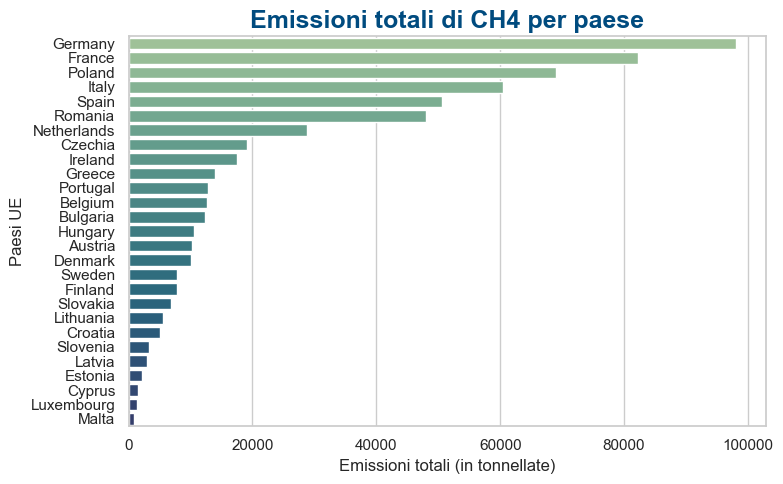

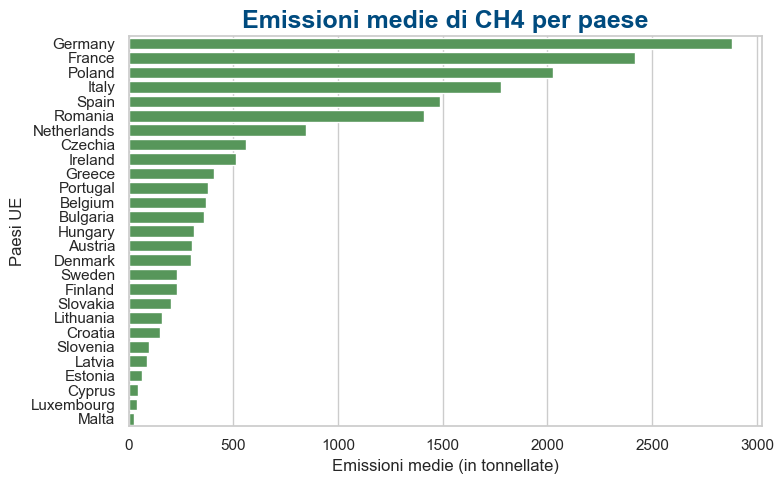

C:\Users\Mariapaola\AppData\Local\Temp\ipykernel_15184\2207886985.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


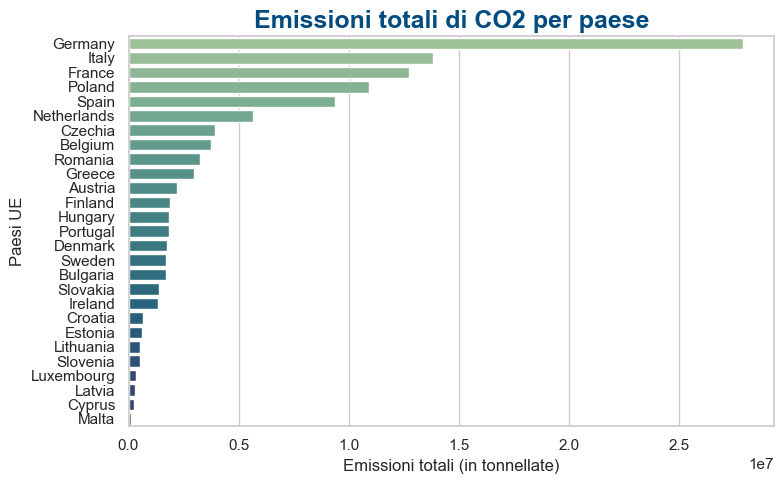

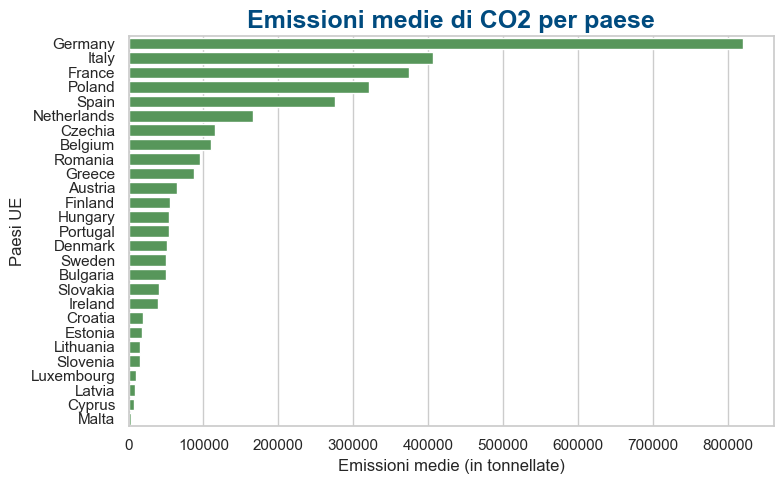

C:\Users\Mariapaola\AppData\Local\Temp\ipykernel_15184\2207886985.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


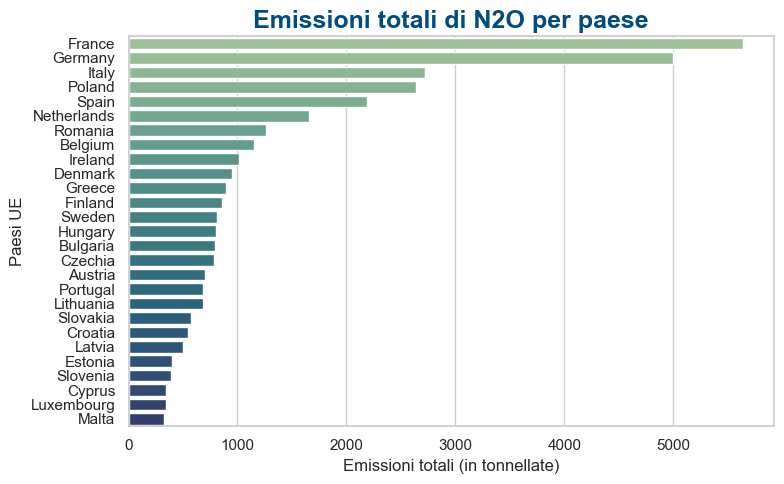

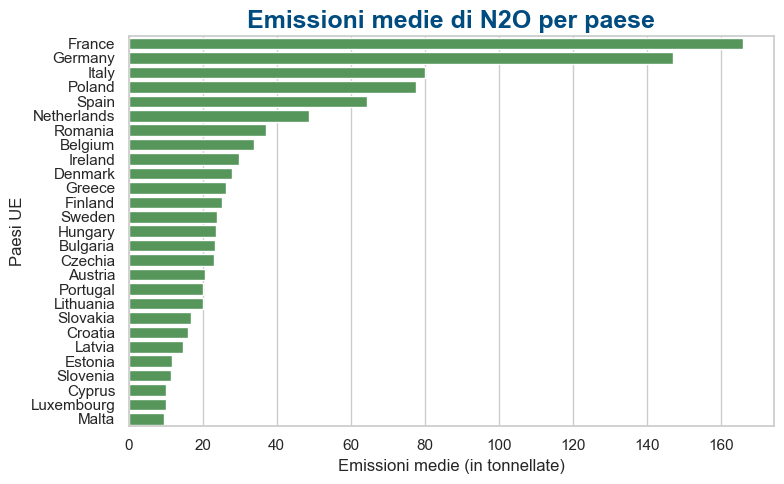

C:\Users\Mariapaola\AppData\Local\Temp\ipykernel_15184\2207886985.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


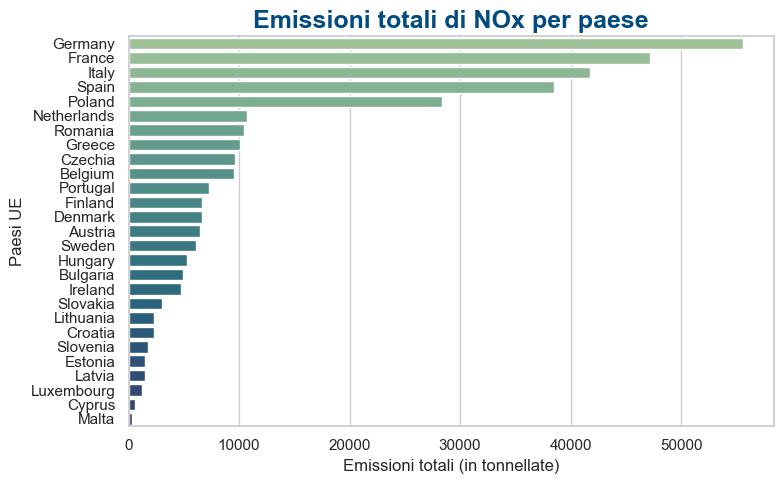

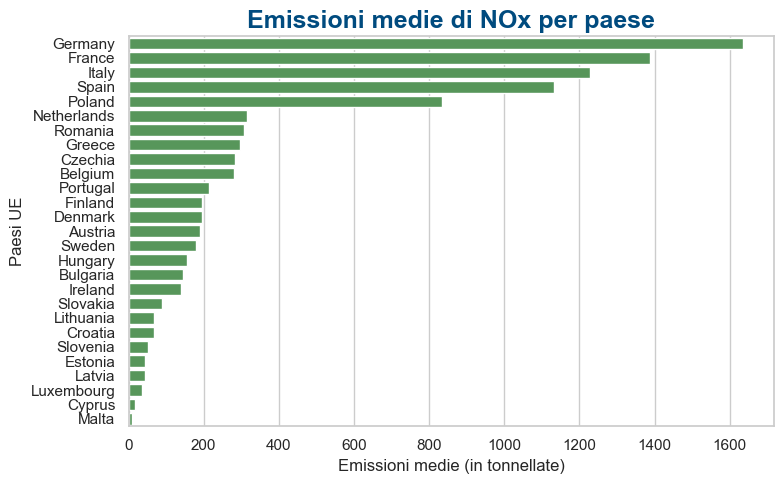

C:\Users\Mariapaola\AppData\Local\Temp\ipykernel_15184\2207886985.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


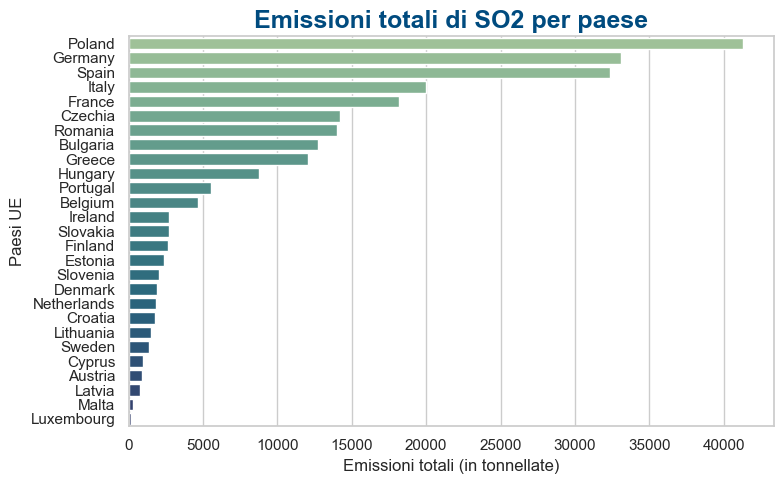

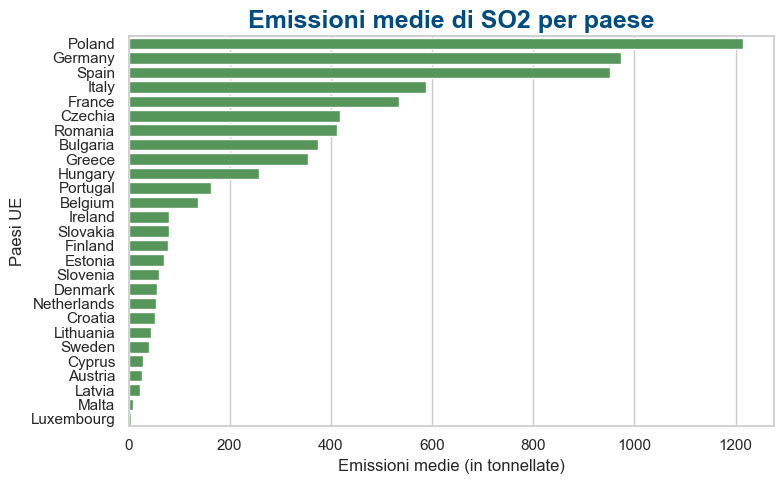

C:\Users\Mariapaola\AppData\Local\Temp\ipykernel_15184\2207886985.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


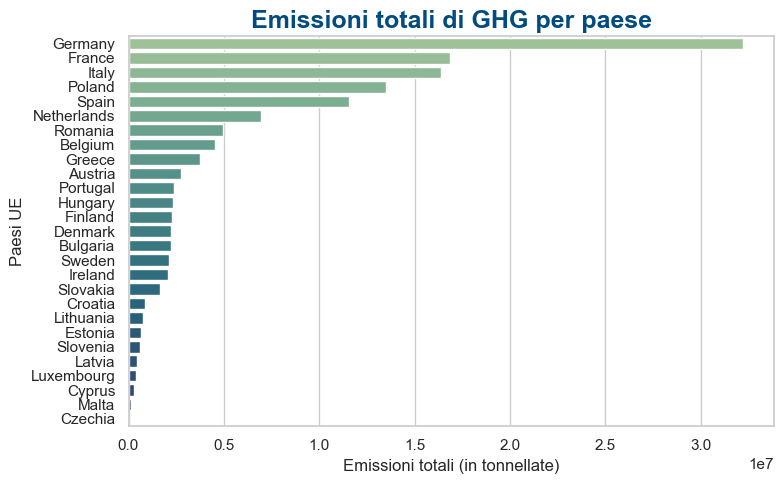

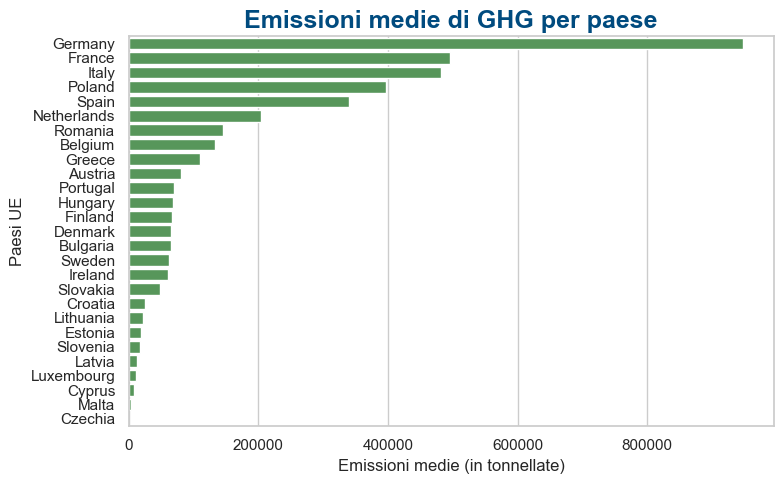

In [290]:
df_emissions_clean = {} # Nuovo dizionario che conterrà i dataframe puliti e con le colonne Total ed Average Emissions

for gas, df in df_emissions_eu.items():
    df_clean, cols_converted = convert_values_to_numeric(df)
    df_emissions_clean[gas] = calculate_emissions(df_clean,cols_converted)
    
    # Ordiniamo per totale delle emissioni
    sorted = df_emissions_clean[gas].sort_values(by='TotalEmissions', ascending=False)

    # Istogramma totale delle emissioni
    # quante emissioni totali ha prodotto ciascun Paese nel periodo 1990–2023
    plt.figure(figsize=(8, 5))
    
    sns.barplot(
        data = sorted,
        x = 'TotalEmissions',
        y = 'Country',
        palette='crest'
    )
    plt.title(f'Emissioni totali di {gas} per paese', fontsize=18, fontweight='bold', color='#004b7f')
    plt.xlabel('Emissioni totali (in tonnellate)')
    plt.ylabel('Paesi UE')
    plt.tight_layout()
    plt.show()

    # Istogramma media delle emissioni
    # Quanto ha emesso in media ogni anno ogni Paese
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data = sorted,
        x = 'AverageEmissions',
        y = 'Country',
        # hue = 'Country', per fare la scala di colori 
        color="#4DA051"
    )
    plt.title(f'Emissioni medie di {gas} per paese', fontsize=18, fontweight='bold', color='#004b7f')
    plt.xlabel('Emissioni medie (in tonnellate)')
    plt.ylabel('Paesi UE')
    plt.tight_layout()
    plt.show()






### Trend delle Emissioni di Gas Serra dal 1990 al 2023

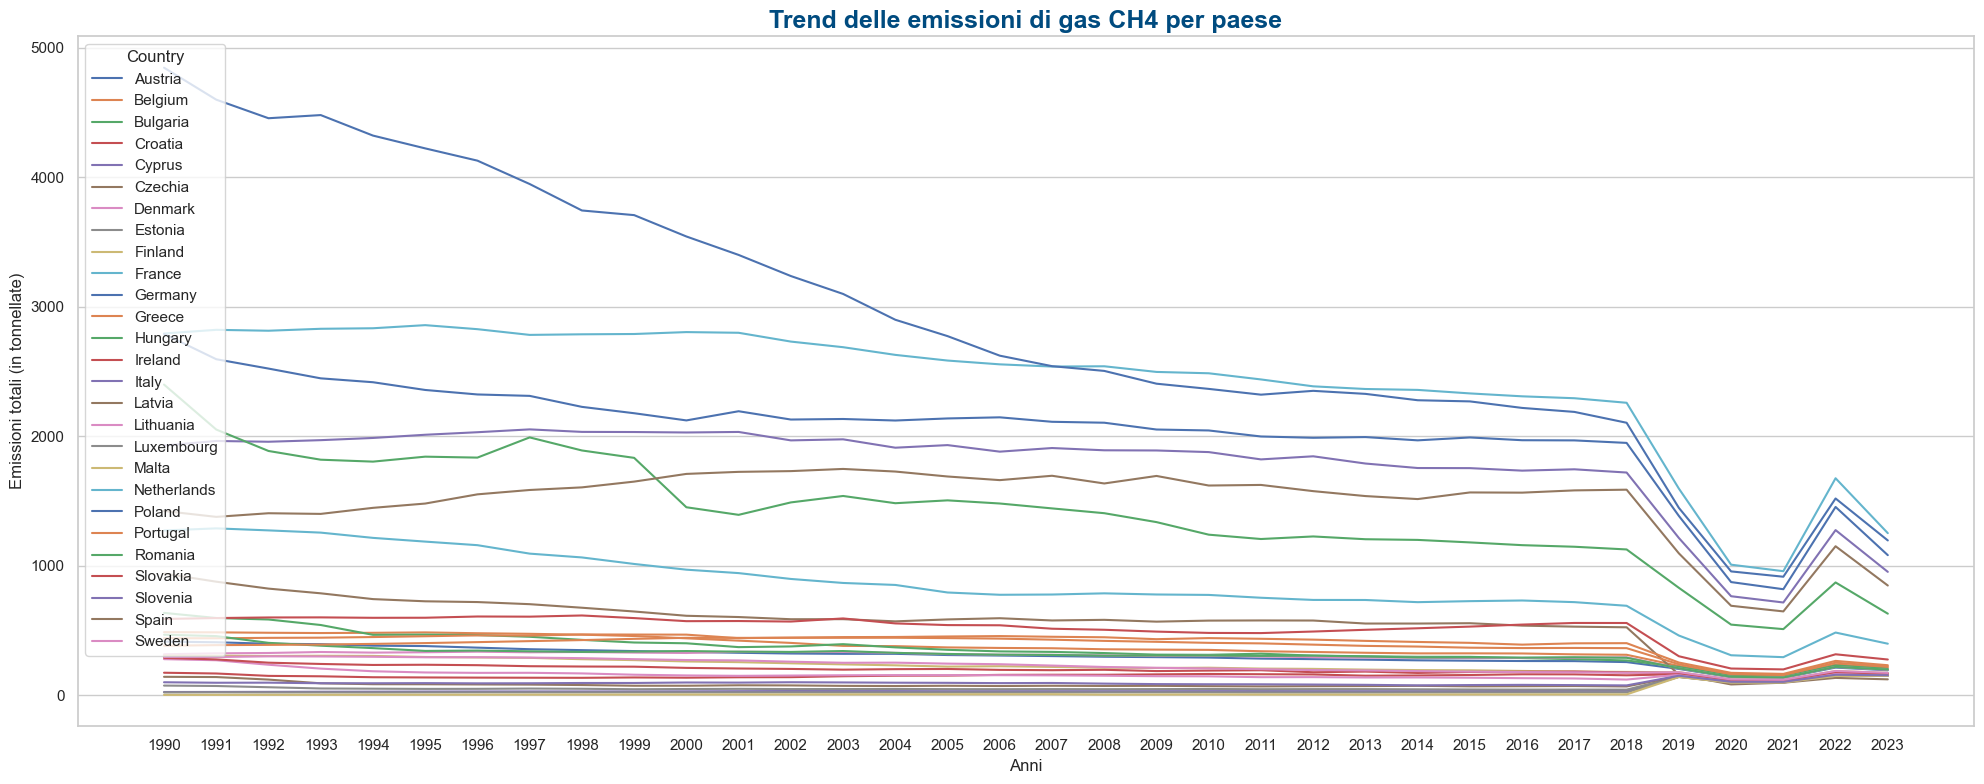

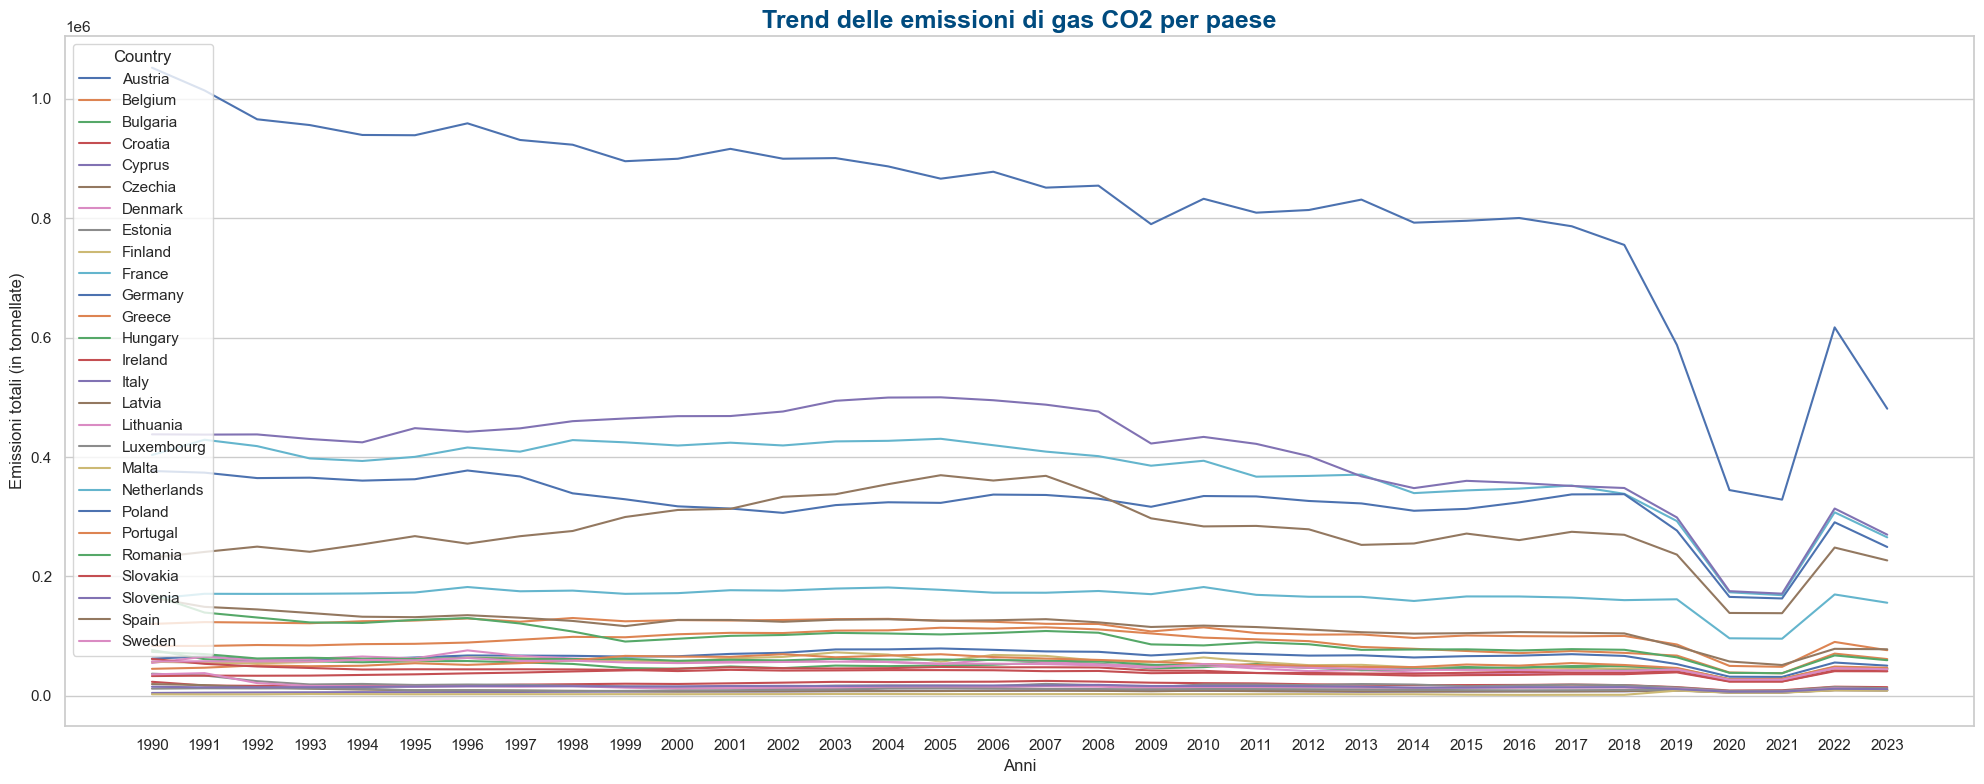

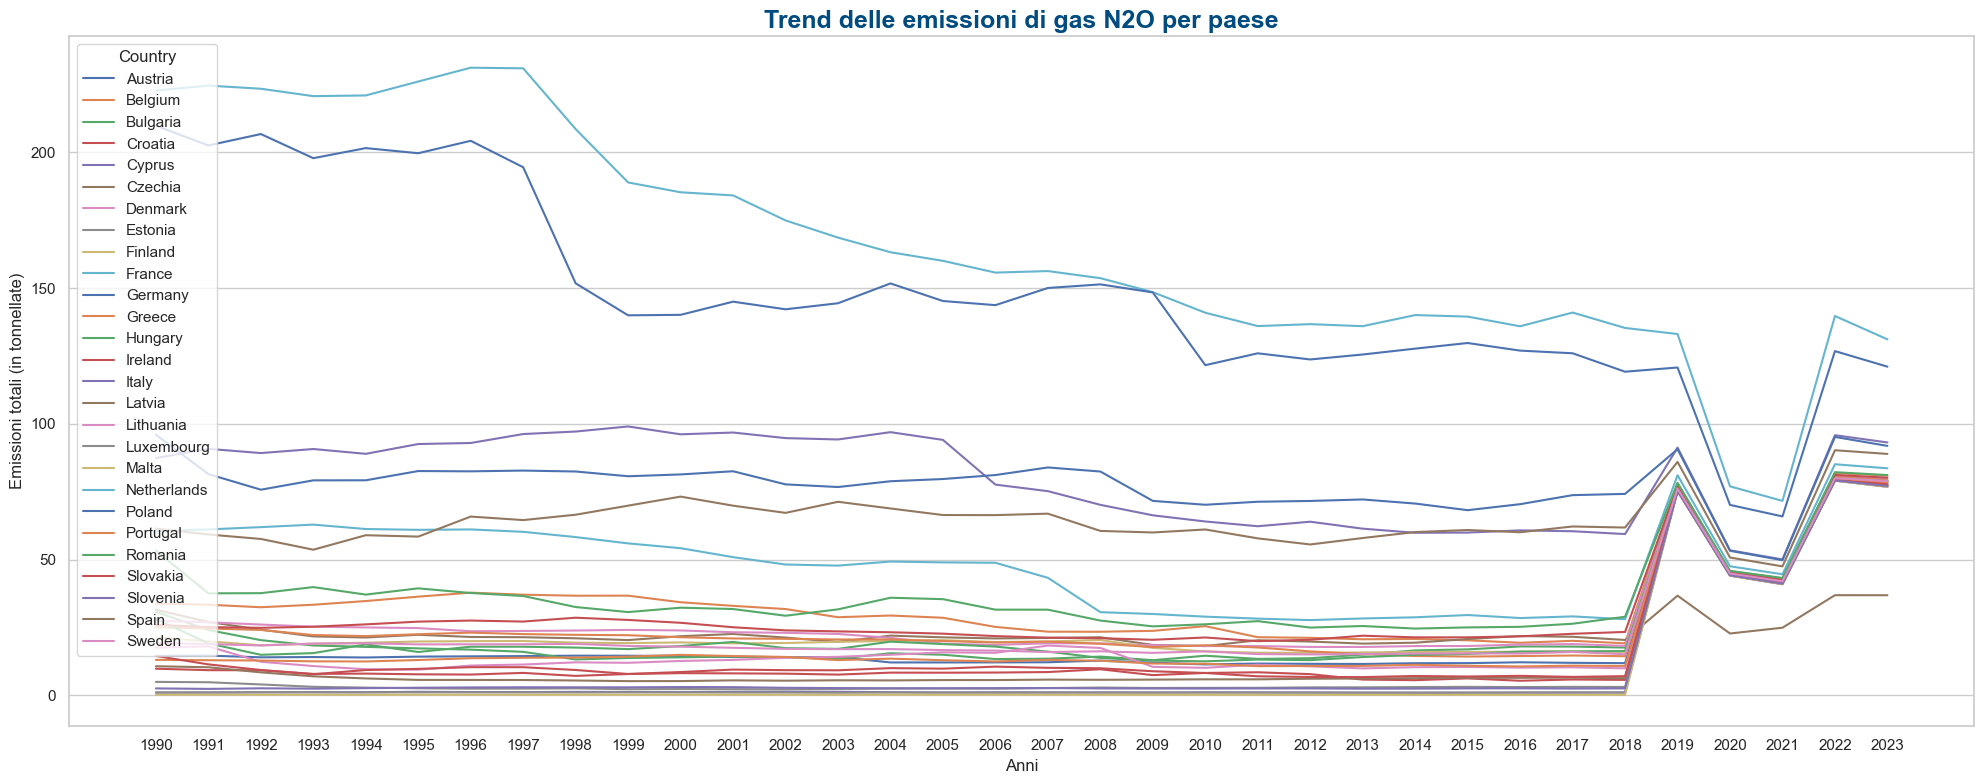

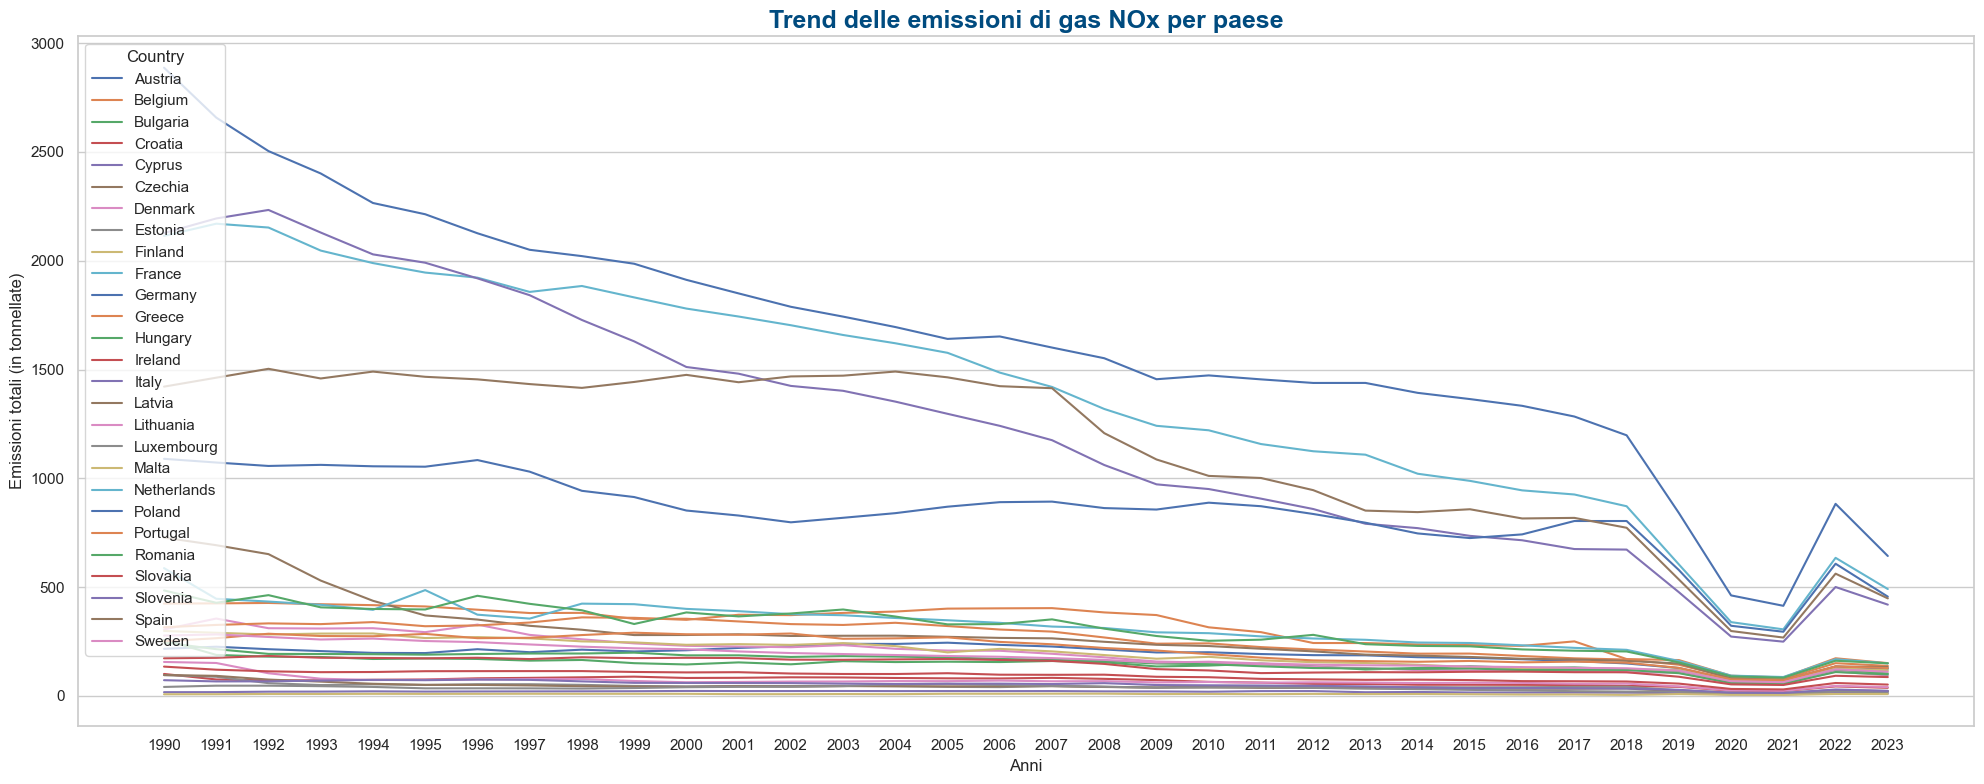

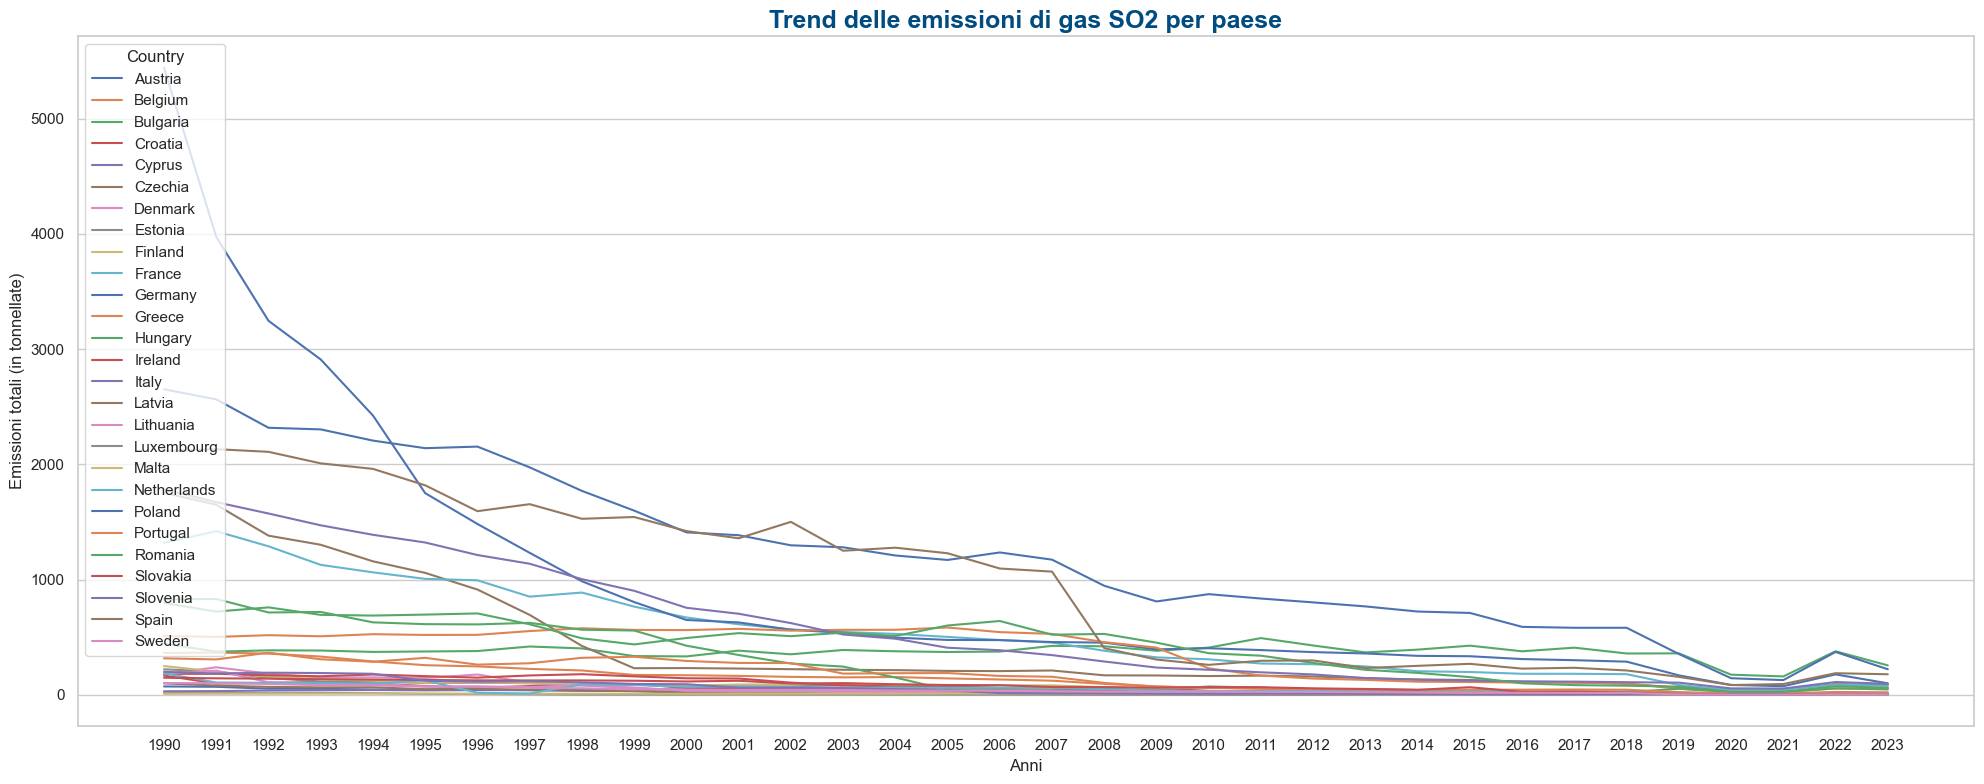

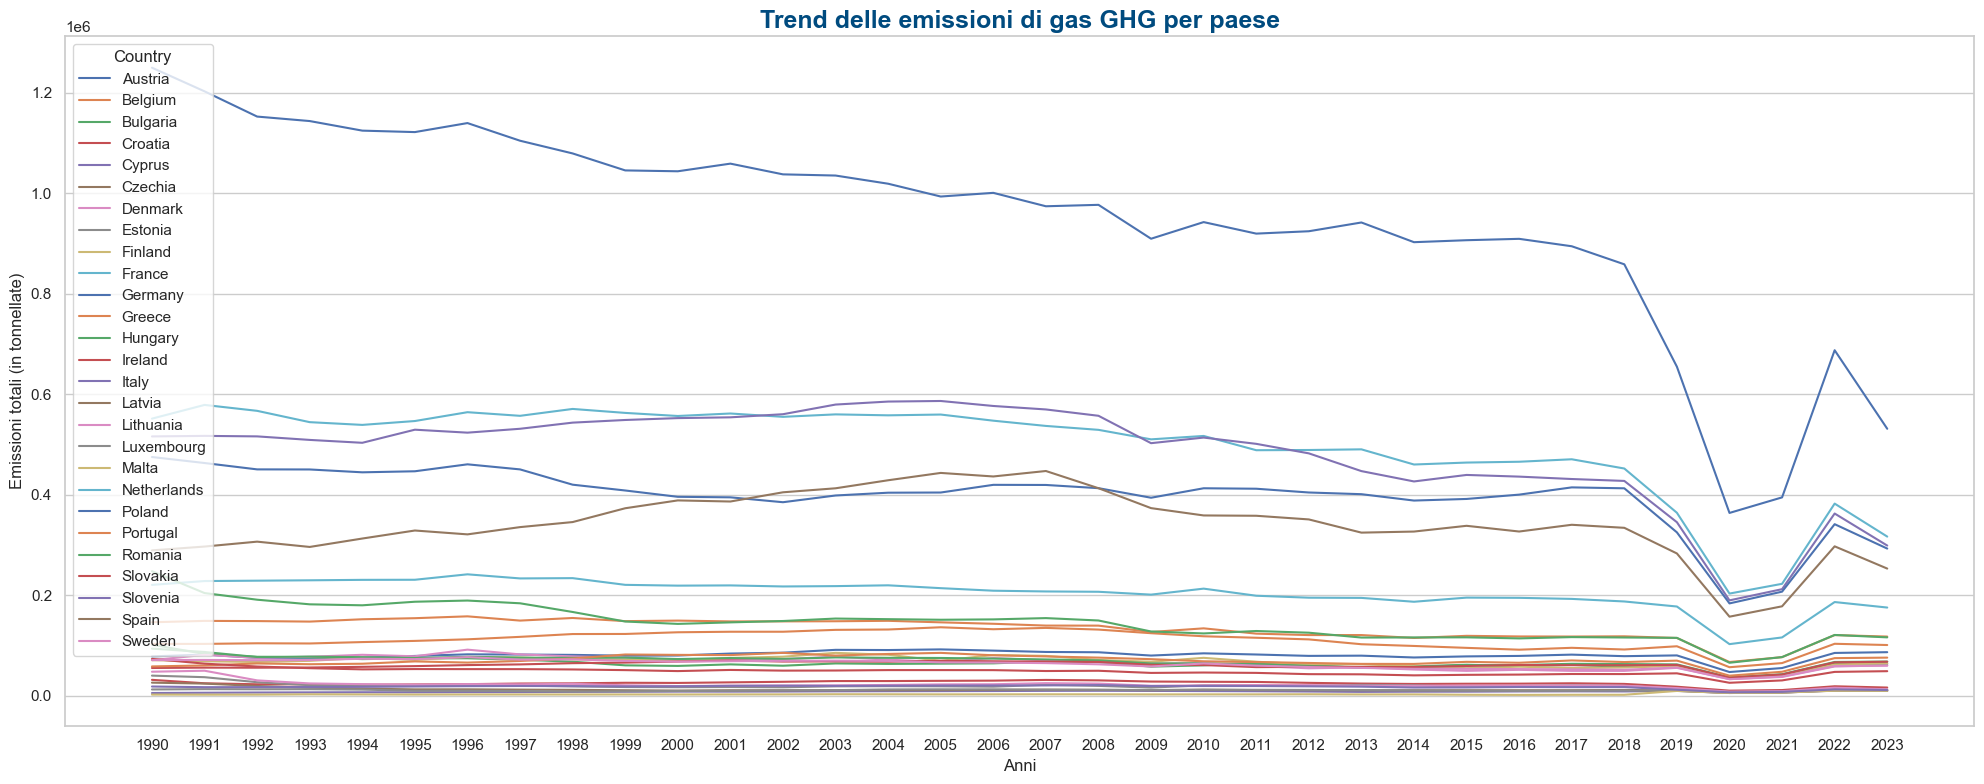

In [291]:
for gas, df in df_emissions_eu.items():
    plot_trend_by_country(df_emissions_clean[gas], gas)

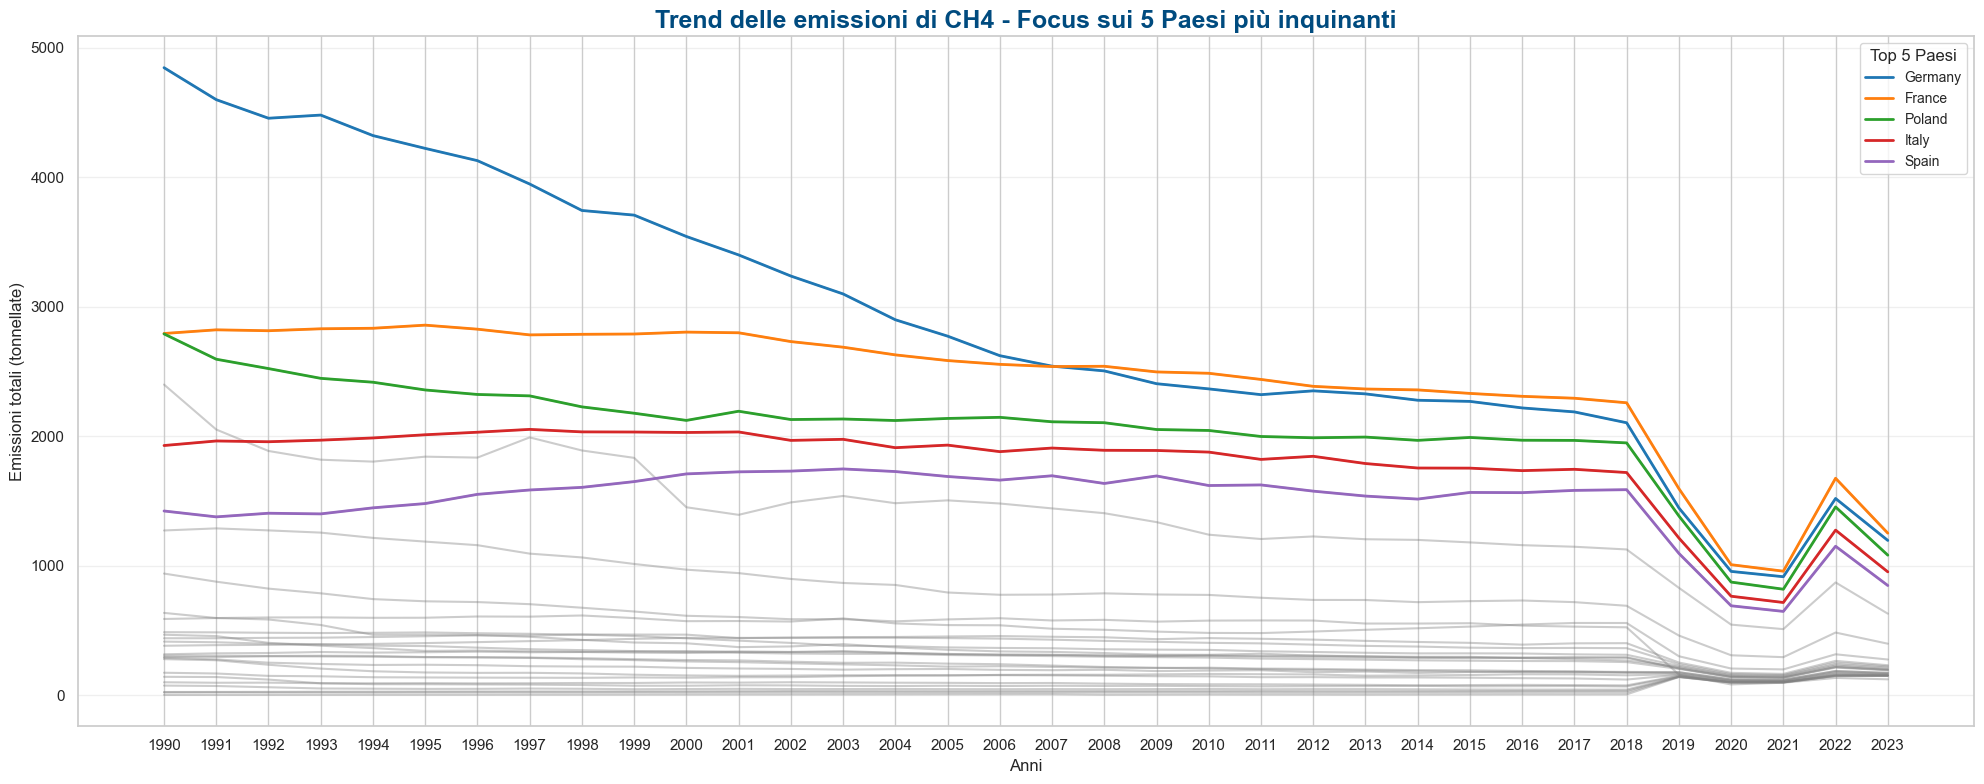

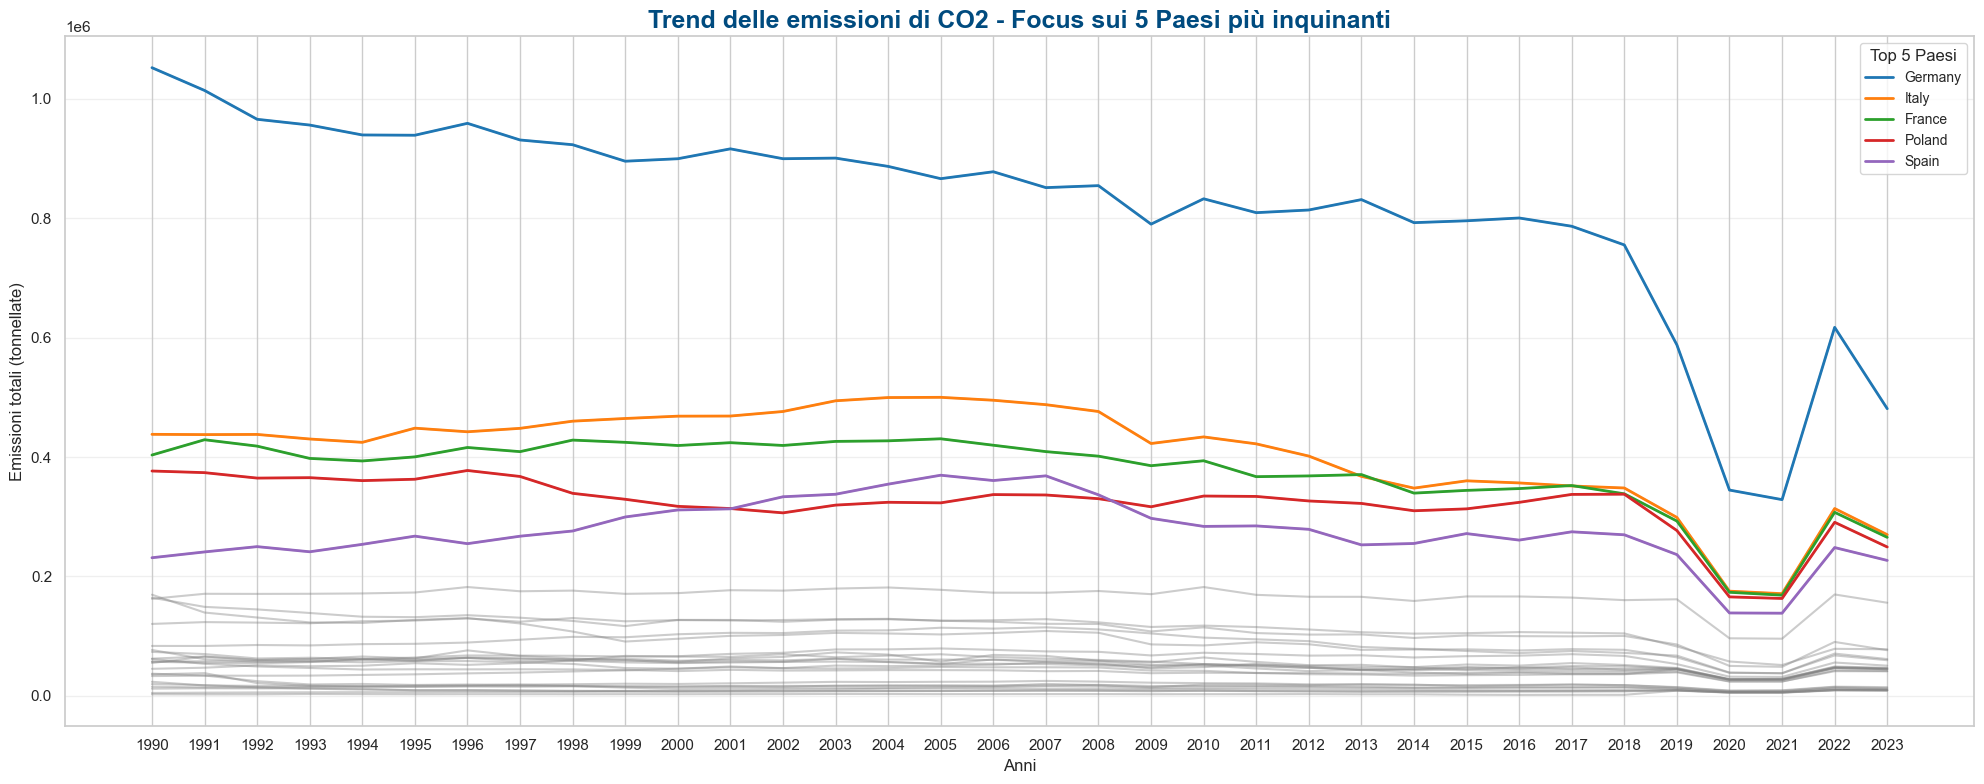

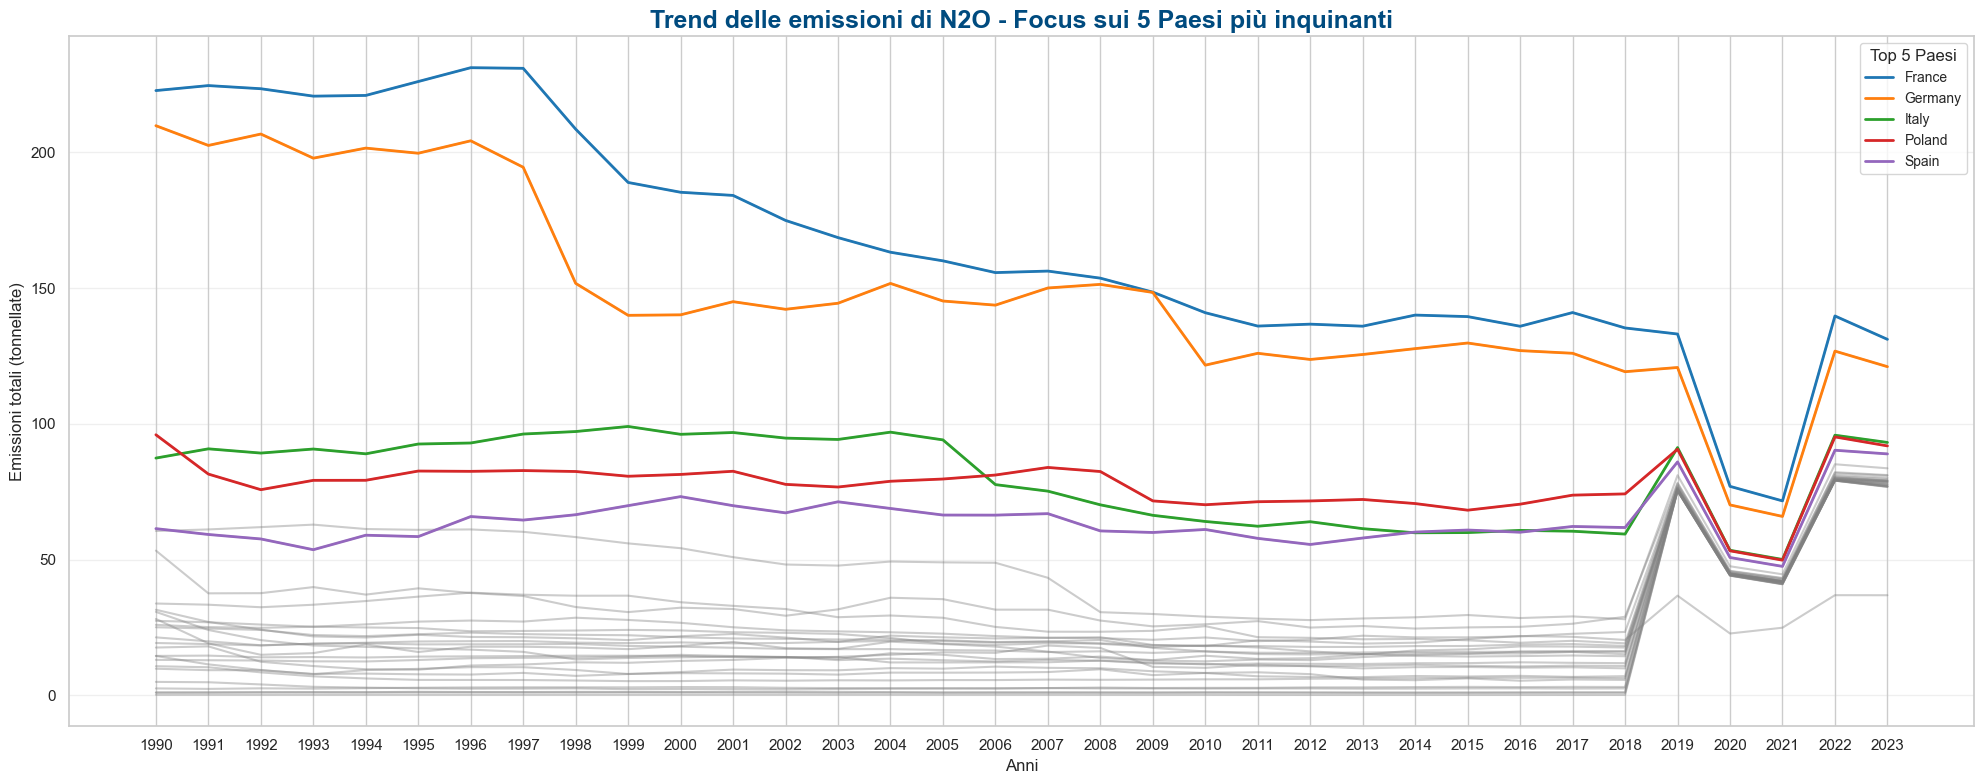

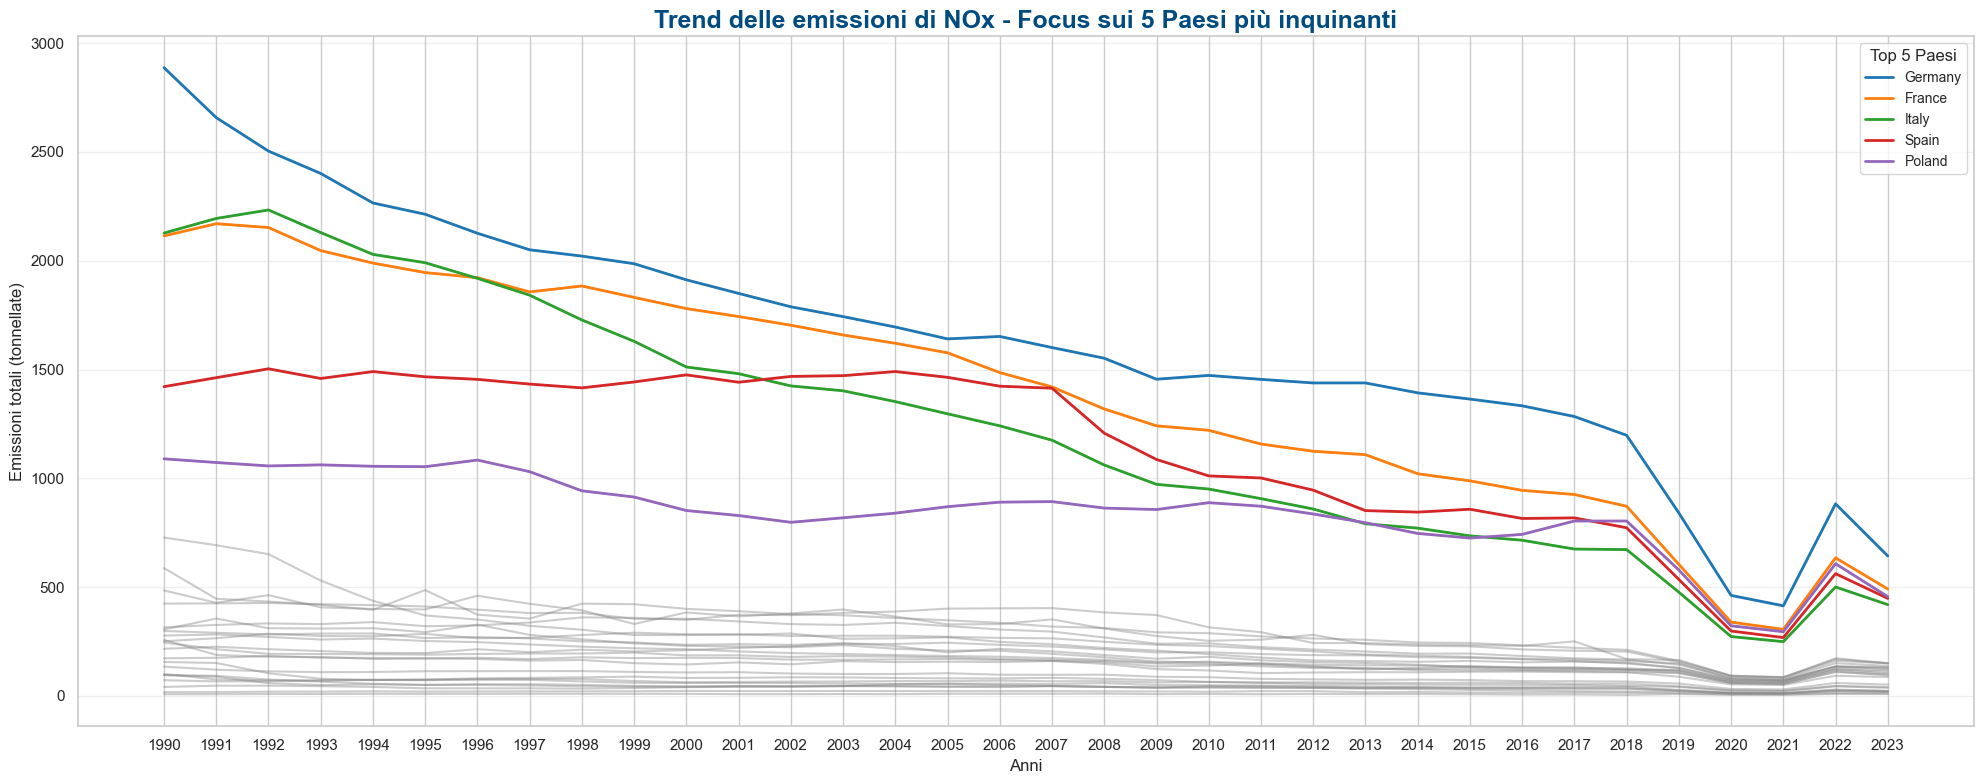

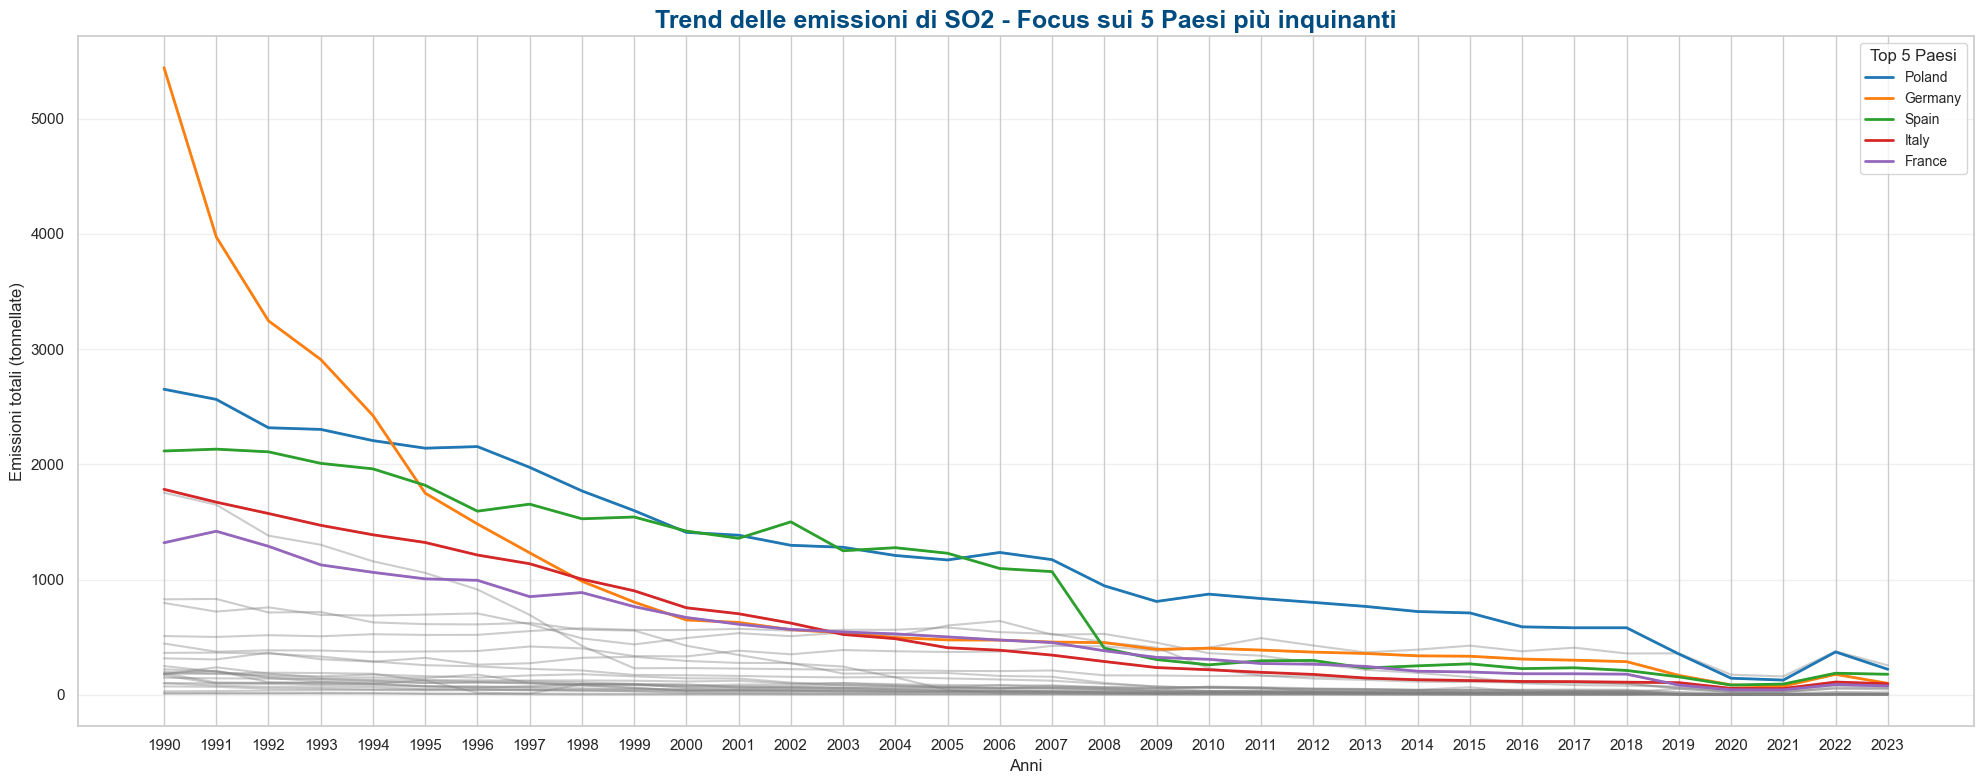

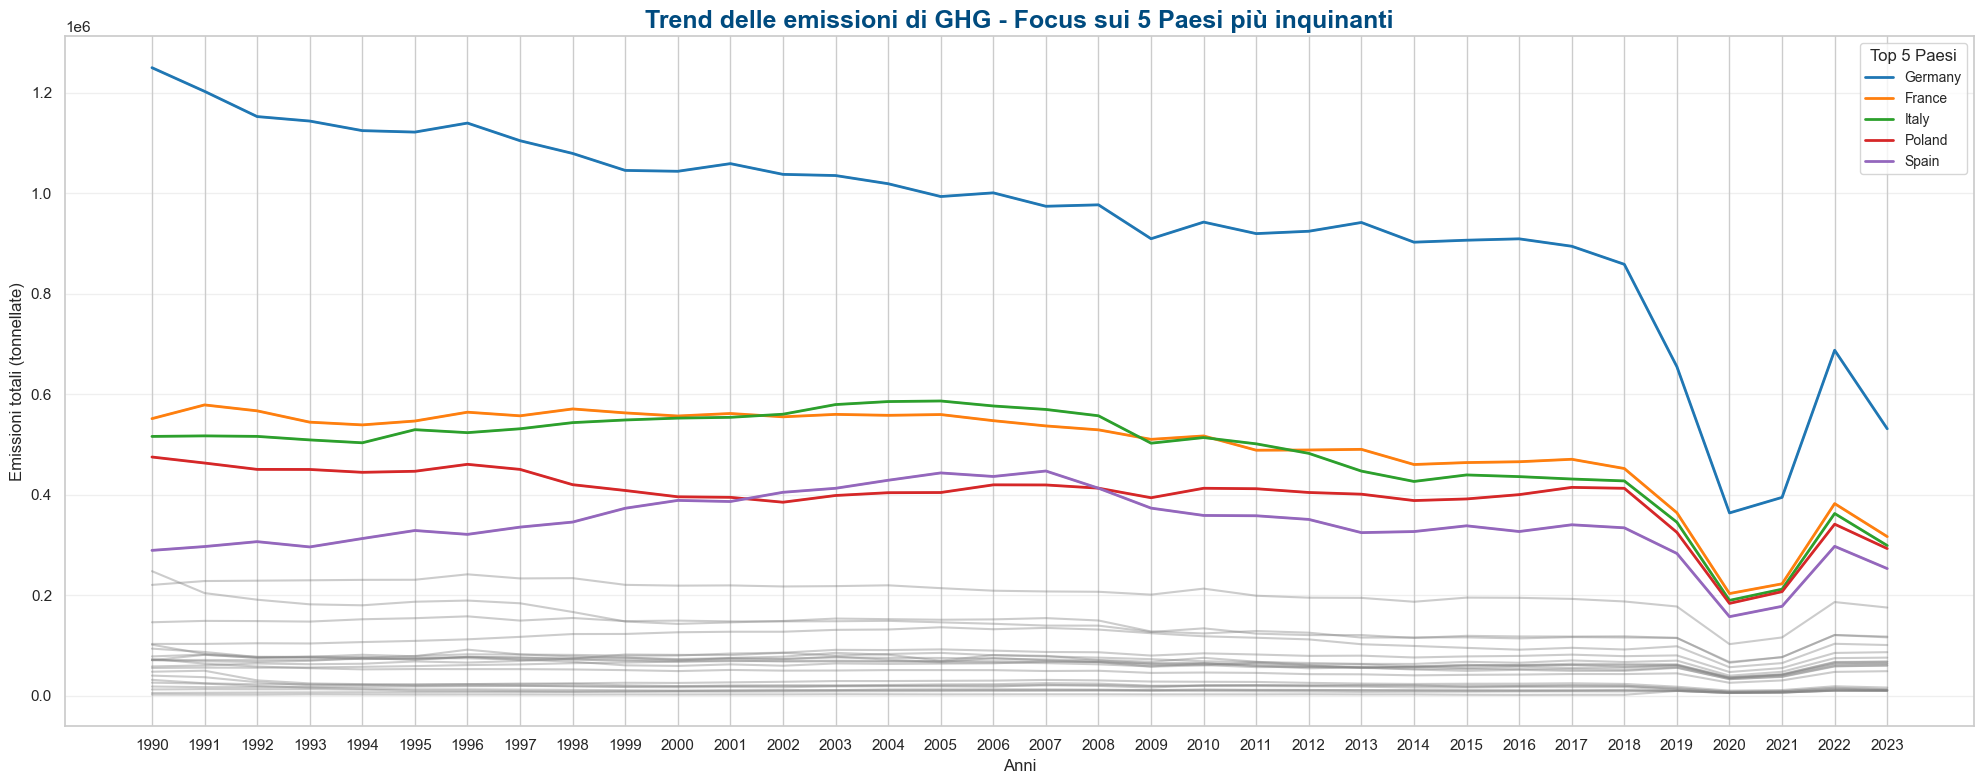

In [292]:
def plot_trend_top5(df, gas, top_n=5):
    plt.figure(figsize=(20, 8))
    sns.set_style("whitegrid")

    years = df.columns[1:-2]

    # Calcolo Top 5 per emissioni totali
    df_tmp = df.copy()
    df_tmp['Total'] = df_tmp.iloc[:, 1:-2].sum(axis=1)
    top_countries = (
        df_tmp.sort_values('Total', ascending=False)
        .head(top_n)['Country']
        .tolist()
    )

    # Palette coerente
    palette = sns.color_palette("tab10", top_n)
    color_map = dict(zip(top_countries, palette))

    # Tutti i paesi (sfondo)
    for country in df['Country']:
        data = df[df['Country'] == country]
        sns.lineplot(
            x=years,
            y=data.iloc[0, 1:-2],
            color='grey',
            linewidth=1.5,
            alpha=0.4,
            legend=False
        )

    # Top 5 evidenziati
    for country in top_countries:
        data = df[df['Country'] == country]
        sns.lineplot(
            x=years,
            y=data.iloc[0, 1:-2],
            label=country,
            linewidth=2,
            color=color_map[country]
        )

    plt.title(
        f'Trend delle emissioni di {gas} - Focus sui 5 Paesi più inquinanti',
        fontsize=18,
        fontweight='bold',
        color='#004b7f'
    )
    plt.xlabel('Anni')
    plt.ylabel('Emissioni totali (tonnellate)')
    plt.legend(title='Top 5 Paesi', fontsize=10)
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

for gas, df in df_emissions_eu.items():
    plot_trend_top5(df_emissions_clean[gas], gas)

### Analisi della correlazione tra energie rinnovabili e riduzione delle emissioni.

Caricamento del dataset sulle Energie Rinnovabili.

In [293]:
try:
      path = 'Dataset/Renewable_Electricity_Production_Dataset.csv'
      df_r = pd.read_csv(path)
      print(f"Il dataset è stato caricato con successo. Dimensioni: {df_r.shape}")
except FileNotFoundError:
      print(f"Il file {path} non è stato trovato.")


df_r.head()

Il dataset è stato caricato con successo. Dimensioni: (224, 35)


Country and area   1990    1991    1992    1993    1994    1995    1996  \
0      Afghanistan  67.73   67.98   67.99   68.35   68.70   69.04   70.37   
1          Albania  87.61   95.07   95.89   95.12   96.62   95.24   96.63   
2          Algeria   0.84    1.69    1.09    1.82    0.83    0.98    0.63   
3          Andorra  100.0  100.00  100.00  100.00  100.00  100.00  100.00   
4           Angola  86.21   82.66   88.70   93.68   93.72   93.75   89.98   

     1997    1998  ...    2014    2015    2016    2017   2018   2019   2020  \
0   72.39   74.44  ...   85.32   86.07   86.15   84.70    NaN    NaN    NaN   
1   96.99   97.10  ...  100.00  100.00  100.00  100.78  100.0  99.74  99.71   
2    0.35    0.42  ...    0.40    0.32    0.25    0.84    NaN    NaN    NaN   
3  100.00  100.00  ...   88.98   86.87   84.85   83.82   84.5  83.92  83.95   
4   76.35   80.42  ...   53.18   53.18   56.12   71.40    NaN    NaN    NaN   

     2021   2022    2023  
0     NaN    NaN     NaN  
1  100.00  99.79  100.00  
2     NaN    NaN     NaN  
3   83.74  83.35   83.34  
4     NaN    NaN     NaN  

[5 rows x 35 columns]

Pulizia e filtraggio del dataset

In [294]:
# Rinominiamo la colonna 'Country and area' in 'Country'
renewable_df = df_r.copy()
renewable_df.rename(columns={'Country and area': 'Country'}, inplace=True)
renewable_df.head(10)

Country   1990    1991    1992    1993    1994    1995    1996  \
0          Afghanistan  67.73   67.98   67.99   68.35   68.70   69.04   70.37   
1              Albania  87.61   95.07   95.89   95.12   96.62   95.24   96.63   
2              Algeria   0.84    1.69    1.09    1.82    0.83    0.98    0.63   
3              Andorra  100.0  100.00  100.00  100.00  100.00  100.00  100.00   
4               Angola  86.21   82.66   88.70   93.68   93.72   93.75   89.98   
5             Anguilla   0.00    0.00    0.00    0.00    0.00    0.00    0.00   
6  Antigua and Barbuda   0.00    0.00    0.00    0.00    0.00    0.00    0.00   
7            Argentina  35.62   30.40   34.78   39.05   42.12   40.23   32.90   
8              Armenia    NaN     NaN   33.80   68.19   62.11   34.51   25.31   
9                Aruba   0.00    0.00    0.00    0.00    0.00    0.00    0.00   

     1997    1998  ...    2014    2015    2016    2017   2018   2019   2020  \
0   72.39   74.44  ...   85.32   86.07   86.15   84.70    NaN    NaN    NaN   
1   96.99   97.10  ...  100.00  100.00  100.00  100.78  100.0  99.74  99.71   
2    0.35    0.42  ...    0.40    0.32    0.25    0.84    NaN    NaN    NaN   
3  100.00  100.00  ...   88.98   86.87   84.85   83.82   84.5  83.92  83.95   
4   76.35   80.42  ...   53.18   53.18   56.12   71.40    NaN    NaN    NaN   
5    0.00    0.00  ...    0.00    0.00    0.96    0.00    NaN    NaN    NaN   
6    0.00    0.00  ...    0.59    2.02    2.55    2.55    NaN    NaN    NaN   
7   38.62   35.76  ...   30.29   28.94   26.37   29.03    NaN    NaN    NaN   
8   23.08   24.83  ...   25.75   28.34   32.17   29.28    NaN    NaN    NaN   
9    0.00    0.00  ...   15.05   14.81   14.57   14.11    NaN    NaN    NaN   

     2021   2022    2023  
0     NaN    NaN     NaN  
1  100.00  99.79  100.00  
2     NaN    NaN     NaN  
3   83.74  83.35   83.34  
4     NaN    NaN     NaN  
5     NaN    NaN     NaN  
6     NaN    NaN     NaN  
7     NaN    NaN     NaN  
8     NaN    NaN     NaN  
9     NaN    NaN     NaN  

[10 rows x 35 columns]

In [295]:
# Filtraggio per selezionare solo i paesi dell'UE
renewable_df_filtered = filter_eu_countries(renewable_df)
print(f"Dimensioni:{renewable_df_filtered.shape}")
renewable_df_filtered.head()

Dimensioni:(27, 35)


Country   1990   1991   1992   1993   1994   1995   1996   1997   1998  \
0   Austria  64.63  63.60  70.52  72.03  69.13  67.79  64.74  65.51  67.19   
1   Belgium   1.27   1.37   1.61   1.45   1.65   1.67   1.59   1.63   1.81   
2  Bulgaria   4.46   5.97   5.79   5.11   3.85   5.54   6.83   6.86   7.98   
3   Croatia    NaN    NaN  48.85  47.57  61.95  61.27  70.38  57.22  52.61   
4    Cyprus    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...   2014   2015   2016   2017   2018   2019   2020   2021   2022   2023  
0  ...  75.61  71.04  72.15  70.77  69.88  70.26  69.95  69.61  70.60  70.48  
1  ...  12.88  15.03  12.27  14.13  13.43  13.43  14.84  13.26  13.81  13.11  
2  ...  16.34  18.29  16.37  14.04  13.71  14.34  13.64  14.56  13.17  14.53  
3  ...  72.97  64.97  63.48  56.54  56.86  57.86  56.41  57.11  58.18  57.59  
4  ...   6.11   7.65   7.61   8.09   6.85   8.27   7.69   7.68   7.48   7.67  

[5 rows x 35 columns]

In [296]:
renewable_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 35 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  27 non-null     object 
 1   1990     17 non-null     object 
 2   1991     18 non-null     float64
 3   1992     25 non-null     float64
 4   1993     25 non-null     float64
 5   1994     25 non-null     float64
 6   1995     25 non-null     float64
 7   1996     25 non-null     float64
 8   1997     25 non-null     float64
 9   1998     25 non-null     float64
 10  1999     25 non-null     float64
 11  2000     25 non-null     float64
 12  2001     25 non-null     float64
 13  2002     25 non-null     float64
 14  2003     25 non-null     float64
 15  2004     25 non-null     float64
 16  2005     27 non-null     float64
 17  2006     27 non-null     float64
 18  2007     27 non-null     float64
 19  2008     27 non-null     float64
 20  2009     27 non-null     float64
 21  2010     27 non-nu

Si può notare che solo dal 2005 si hanno informazioni su tutti i Paesi dell'Unione Europea, negli anni precedenti sono presenti valori nulli. Quindi decidiamo di far partire l'analisi dal 2005 in poi.

In [297]:
renew_2005 = get_2005_data_and_above(renewable_df_filtered)
# Creazione del dataset contenente i dati sulle energie rinnovabili a partire dal 2005
cleaned_renewable_df = renewable_df_filtered[['Country']+renew_2005]
cleaned_renewable_df.head()

Country   2005   2006   2007   2008   2009   2010   2011   2012   2013  \
0   Austria  61.04  61.91  63.42  63.91  66.13  61.48  60.63  69.57  72.57   
1   Belgium   2.41   2.63   2.73   3.16   3.29   3.97   5.58   8.18  10.10   
2  Bulgaria  10.67  10.03   7.58   7.55  10.03  13.72   9.21  12.73  17.23   
3   Croatia  54.33  51.81  38.55  46.01  56.10  62.88  47.16  49.56  65.86   
4    Cyprus   0.02   0.02   0.04   0.06   0.08   0.71   2.56   4.39   6.48   

    2014   2015   2016   2017   2018   2019   2020   2021   2022   2023  
0  75.61  71.04  72.15  70.77  69.88  70.26  69.95  69.61  70.60  70.48  
1  12.88  15.03  12.27  14.13  13.43  13.43  14.84  13.26  13.81  13.11  
2  16.34  18.29  16.37  14.04  13.71  14.34  13.64  14.56  13.17  14.53  
3  72.97  64.97  63.48  56.54  56.86  57.86  56.41  57.11  58.18  57.59  
4   6.11   7.65   7.61   8.09   6.85   8.27   7.69   7.68   7.48   7.67

#### Top Paesi Virtuosi sulle Energie Rinnovabili al 2023

Visualizziamo i Paesi più virtuosi in materia sulle Energie Rinnovabili al 2023.

In [298]:
# Selezione dei soli dati del 2023
renew_2023 = cleaned_renewable_df[['Country', '2023']].copy().sort_values(by='2023', ascending=False)
renew_2023.head()

Country   2023
17  Luxembourg  78.47
0      Austria  70.48
16   Lithuania  68.26
15      Latvia  59.84
3      Croatia  57.59

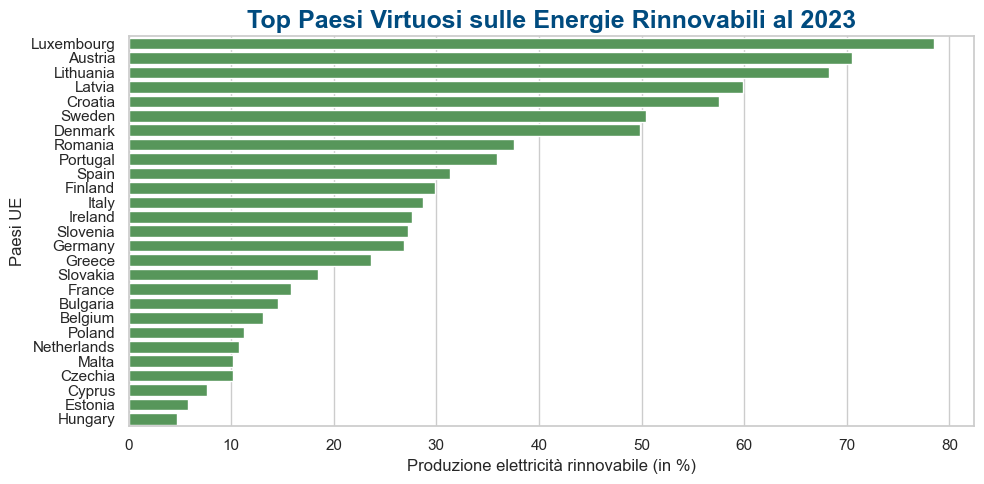

In [299]:
# Visualizzazione dei dati in ordine crescente
plt.figure(figsize=(10, 5))
sns.barplot(
    data = renew_2023,
    x = '2023',
    y = 'Country',
    color="#4DA051"
)
plt.title(f'Top Paesi Virtuosi sulle Energie Rinnovabili al 2023', fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Produzione elettricità rinnovabile (in %)')
plt.ylabel('Paesi UE')
plt.tight_layout()
plt.show()

#### Trend della Produzione di Elettricità da Fonti Rinnovabili per Paese dal 2005 al 2023

Visualizziamo il trend negli anni di produzione di elettricità da fonti rinnovabili per ogni Paese.

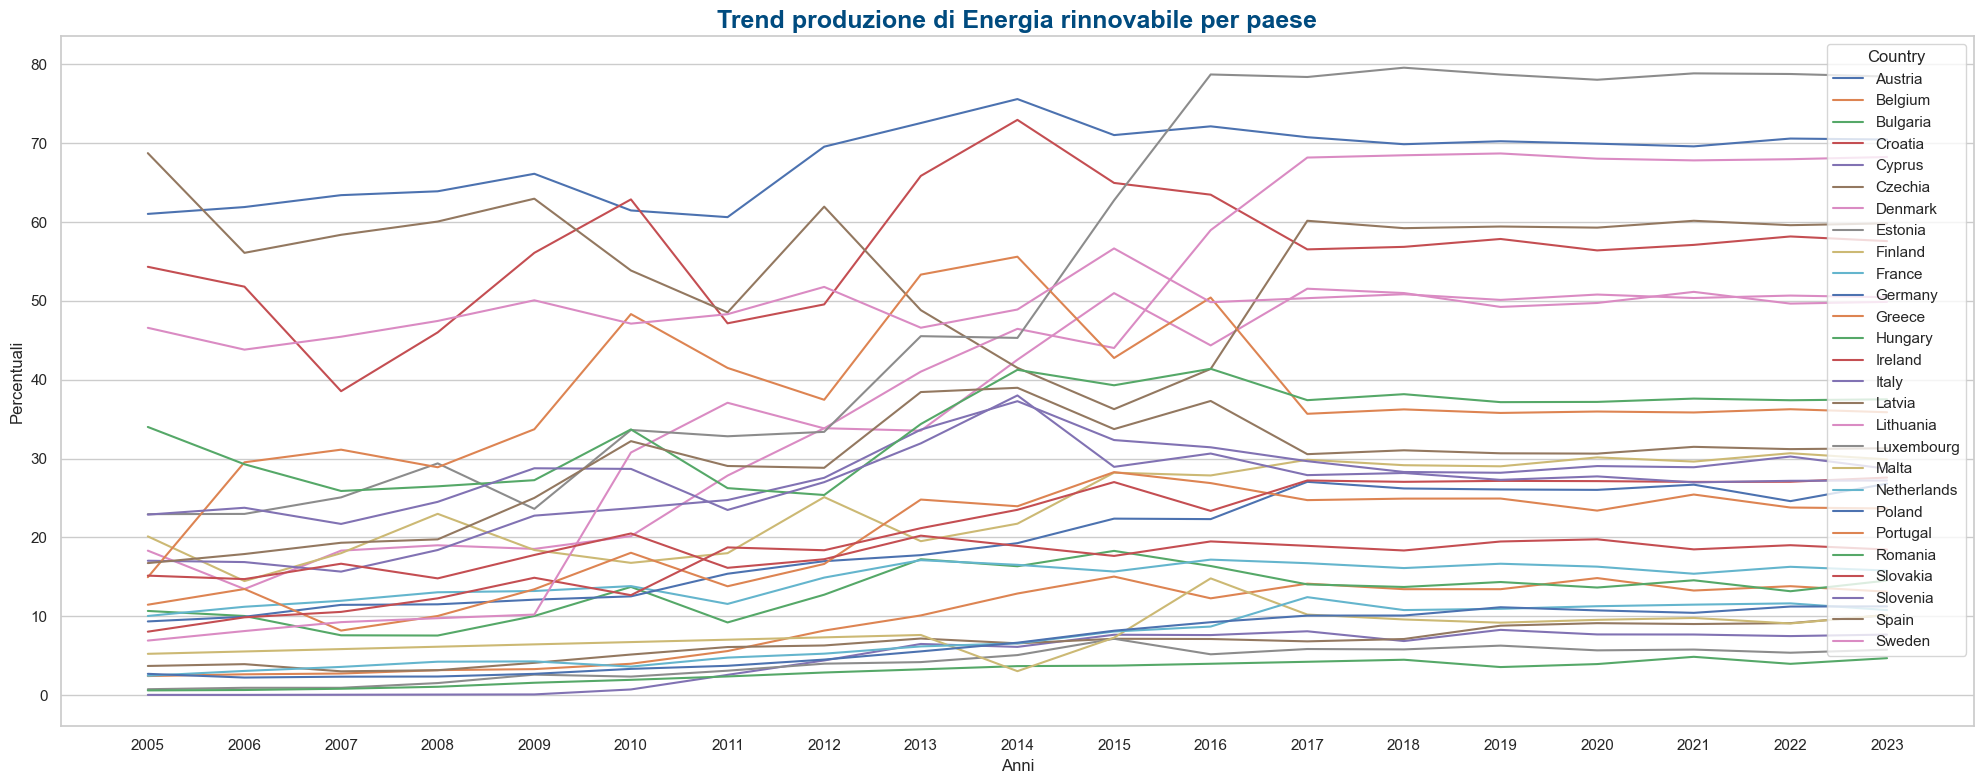

In [300]:
plt.figure(figsize=(20,8))
for country in cleaned_renewable_df['Country']: # Plot di una linea per paese
    data = cleaned_renewable_df[cleaned_renewable_df['Country']==country]
    sns.lineplot(x = cleaned_renewable_df.columns[1:], 
                y= data.iloc[0, 1:],
                label=country)
plt.title(f'Trend produzione di Energia rinnovabile per paese', fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Anni')
plt.ylabel('Percentuali')
plt.legend(title='Country', loc='upper right')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#### Correlazione tra Energie Rinnovabili ed Emissioni di Gas Serra

Vediamo se c'è una correlazione tra l'utilizzo di Energie Rinnovabili e le Emissioni di Gas Serra.

In [301]:
correlation_results = {}

merged_data = {}

for gas, df in df_emissions_eu.items():
    df_merge, corr = calculate_correlation(df, gas, cleaned_renewable_df)
    correlation_results[gas] = corr
    merged_data[gas] = df_merge

La correlazione tra Energie Rinnovabili e CH4 è -0.21
La correlazione tra Energie Rinnovabili e CO2 è -0.21
La correlazione tra Energie Rinnovabili e N2O è -0.20
La correlazione tra Energie Rinnovabili e NOx è -0.18
La correlazione tra Energie Rinnovabili e SO2 è -0.30
La correlazione tra Energie Rinnovabili e GHG è -0.22


Poichè i valori del CO2 e del GHG sono molto fuori scala rispetto agli altri conviene riportarli in un grafico separato.

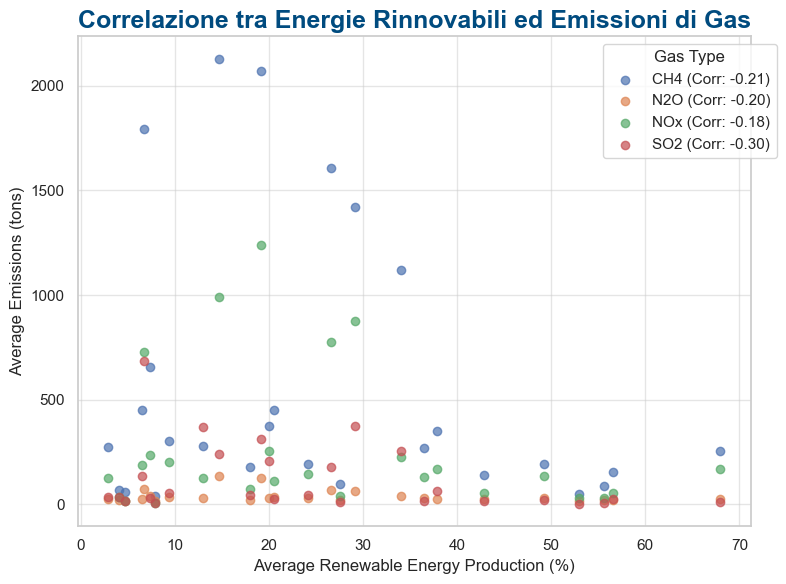

In [302]:
plt.figure(figsize=(8, 6))

for gas in merged_data.keys():
    if gas != 'CO2' and gas != 'GHG':
        df_corr = merged_data[gas]
        corr_value = correlation_results[gas]

        plt.scatter(
            df_corr['Renewable_Energy_Mean'],
            df_corr['AverageEmissions'],
            label=f'{gas} (Corr: {corr_value:.2f})',
            alpha=0.7
        )

plt.title(
    'Correlazione tra Energie Rinnovabili ed Emissioni di Gas',
    fontsize=18, fontweight='bold', color='#004b7f'
)
plt.xlabel('Average Renewable Energy Production (%)', fontsize=12)
plt.ylabel('Average Emissions (tons)', fontsize=12)

plt.legend(title='Gas Type', bbox_to_anchor=(1.05, 1), loc='best')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


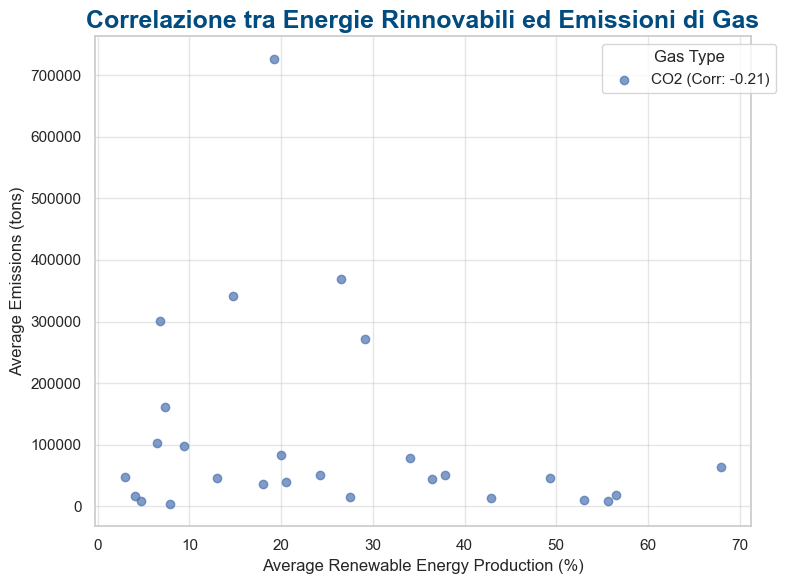

In [303]:
plt.figure(figsize=(8, 6))

for gas in merged_data.keys():
    if gas == 'CO2':
        df_corr = merged_data[gas]
        corr_value = correlation_results[gas]

        plt.scatter(
            df_corr['Renewable_Energy_Mean'],
            df_corr['AverageEmissions'],
            label=f'{gas} (Corr: {corr_value:.2f})',
            alpha=0.7
        )

plt.title(
    'Correlazione tra Energie Rinnovabili ed Emissioni di Gas',
    fontsize=18, fontweight='bold', color='#004b7f'
)
plt.xlabel('Average Renewable Energy Production (%)', fontsize=12)
plt.ylabel('Average Emissions (tons)', fontsize=12)

plt.legend(title='Gas Type', bbox_to_anchor=(1.05, 1), loc='best')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

## **Analisi predittive**

Qual è il futuro della sostenibilità ambientale fino al 2035?

Prediciamo la produzione di CO2 dei Paesi dell'Unione e la produzione di energia da fonti rinnovabili.

### Predizione sulla produzione di CO2 dei Paesi dellʼUnione Europea al 2035

In [304]:
# Dati disponibili sulla produzione di CO2
df_emissions_eu['CO2'].tail()

Country       1990       1991       1992       1993       1994  \
22   Romania  169285.87  139370.25  131072.28  122832.31  121961.46   
23  Slovakia   61633.46   53437.90   49029.14   46484.22   43878.72   
24  Slovenia   15093.84   14001.24   14006.75   14303.47   14642.67   
25     Spain  231213.56  240953.02  249813.19  241195.18  253661.39   
26    Sweden   57348.82   57707.22   57451.49   57493.45   59953.81   

         1995       1996       1997       1998  ...       2014       2015  \
22  127032.86  130095.93  121074.67  107561.54  ...   77432.42   77725.63   
23   44322.41   44186.12   44313.68   44073.14  ...   33654.50   34484.24   
24   15254.25   15916.61   16244.92   15961.13  ...   13531.94   13617.54   
25  267416.72  254795.33  267306.44  276021.58  ...  255100.21  271687.35   
26   59366.21   63302.78   58212.55   58696.67  ...   43337.56   43336.76   

         2016       2017       2018       2019       2020       2021  \
22   75812.80   78077.49   76951.22   64315.82   38356.57   37711.23   
23   34921.79   36087.34   36087.84   39128.92   23663.27   23800.10   
24   14416.66   14264.75   14487.84   11119.68    6634.59    6853.85   
25  260759.56  274671.26  269654.25  236455.77  138683.94  138295.80   
26   42972.57   42306.82   41766.18   44184.39   26765.43   26849.85   

         2022       2023  
22   67531.61   59525.86  
23   41085.37   40948.98  
24   11675.66   10994.74  
25  248278.56  226716.02  
26   46393.61   44346.89  

[5 rows x 35 columns]

#### Regressione Lineare

Un problema di regressione consiste nel prevedere un valore numerico continuo a partire da un insieme di feature.

La regressione lineare è il modello più semplice e intuitivo. Serve per trovare una relazione tra due o più variabili, assumendo che tale relazione sia lineare, cioè rappresentabile da una retta.

In [305]:
# Preprocessing dei dati
df_co2 = df_emissions_eu['CO2'].copy() # creiamo una copia dei dati (storici)
years = np.array([int(year) for year in df_co2.columns[1:]]).reshape(-1,1)
future_years = np.array(range(2024, 2036)).reshape(-1, 1)

In [306]:
# Struttura dati per le predizioni
predictions = pd.DataFrame({'Year' : range(2024, 2036)})

# DataFrame per memorizzare i risulati 
metrics_df = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Addestramento di un modello di regressione lineare per ogni paese per predire i valori futuri
for country in df_co2['Country']:
    # Estrazione dati storici per Paese
    country_data = df_co2[df_co2['Country']==country].iloc[:,1:].values.flatten()
    
    # Addestramento modello
    model = LinearRegression()
    model.fit(years, country_data)

    # Predizione sullo stesso set di dati
    y_pred = model.predict(years)

    # Calcolo metriche
    mse = mean_squared_error(country_data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(country_data, y_pred)

    # Salvataggio metriche
    metrics_df.loc[len(metrics_df)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

    # Predizione valori futuri
    future_pred = model.predict(future_years)

    # Aggiunta presizioni al DF
    predictions[country] = future_pred

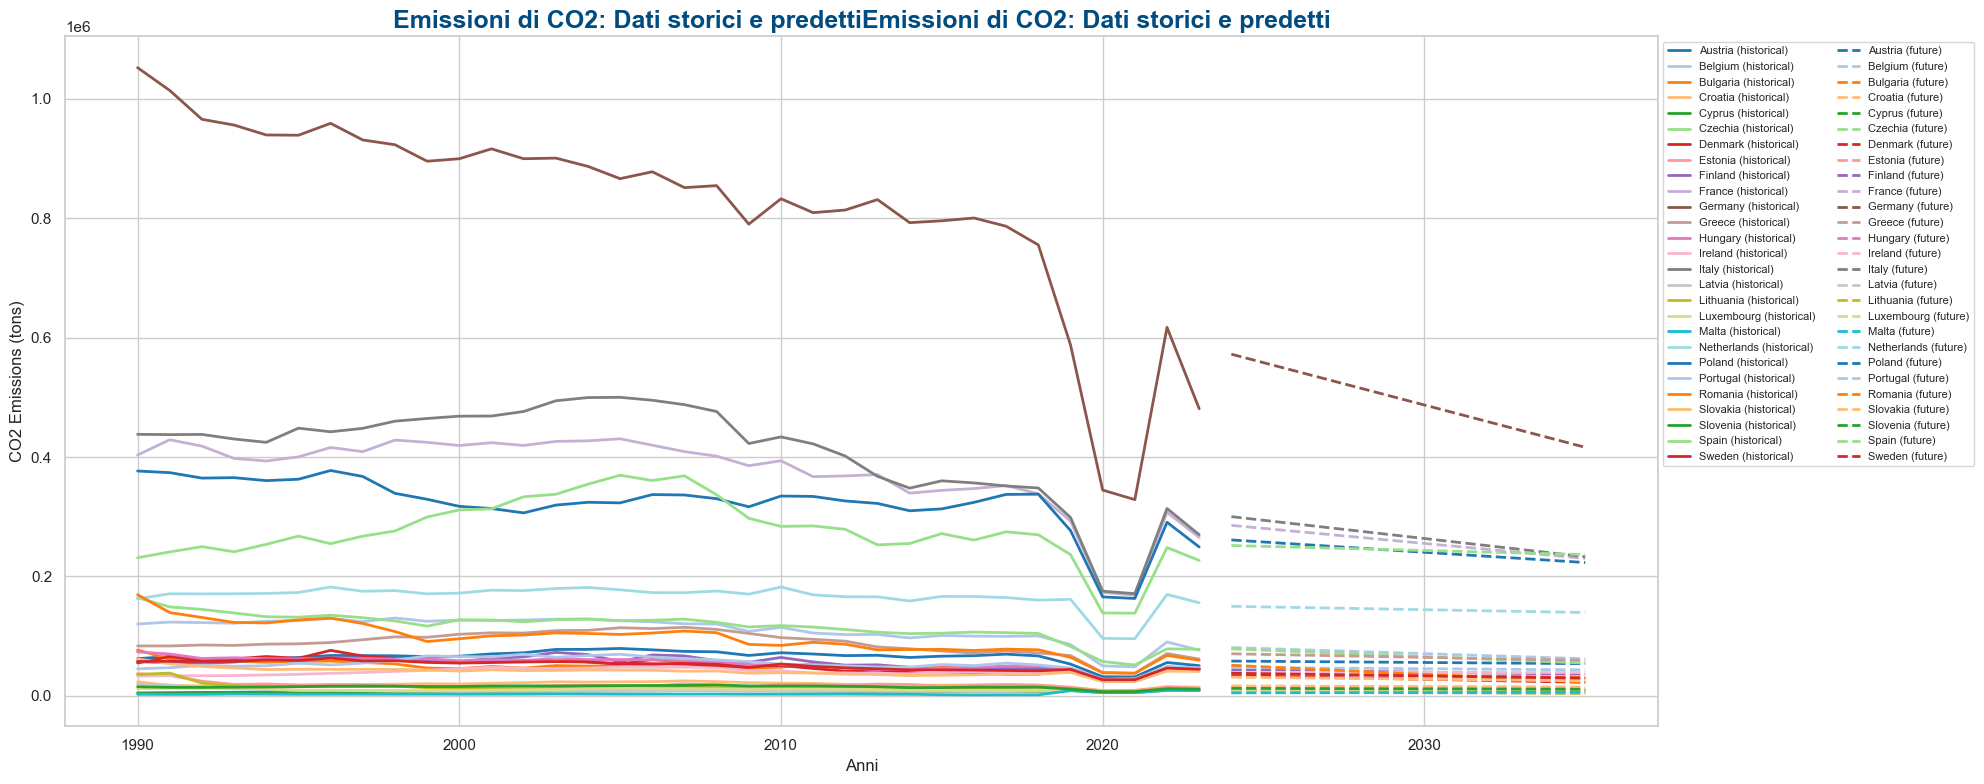

In [307]:
plot_historical_vs_predicted(df_hist=df_co2, df_pred=predictions, title='Emissioni di CO2: Dati storici e predettiEmissioni di CO2: Dati storici e predetti', ylabel='CO2 Emissions (tons)', figsize=(20, 8))

#### Regressione Lineare Polinomiale

La regressione polinomiale è una generalizzazione della regressione lineare che, invece di una linea retta, permette di utilizzare curve
(polinomi) per rappresentare la relazione tra variabili.

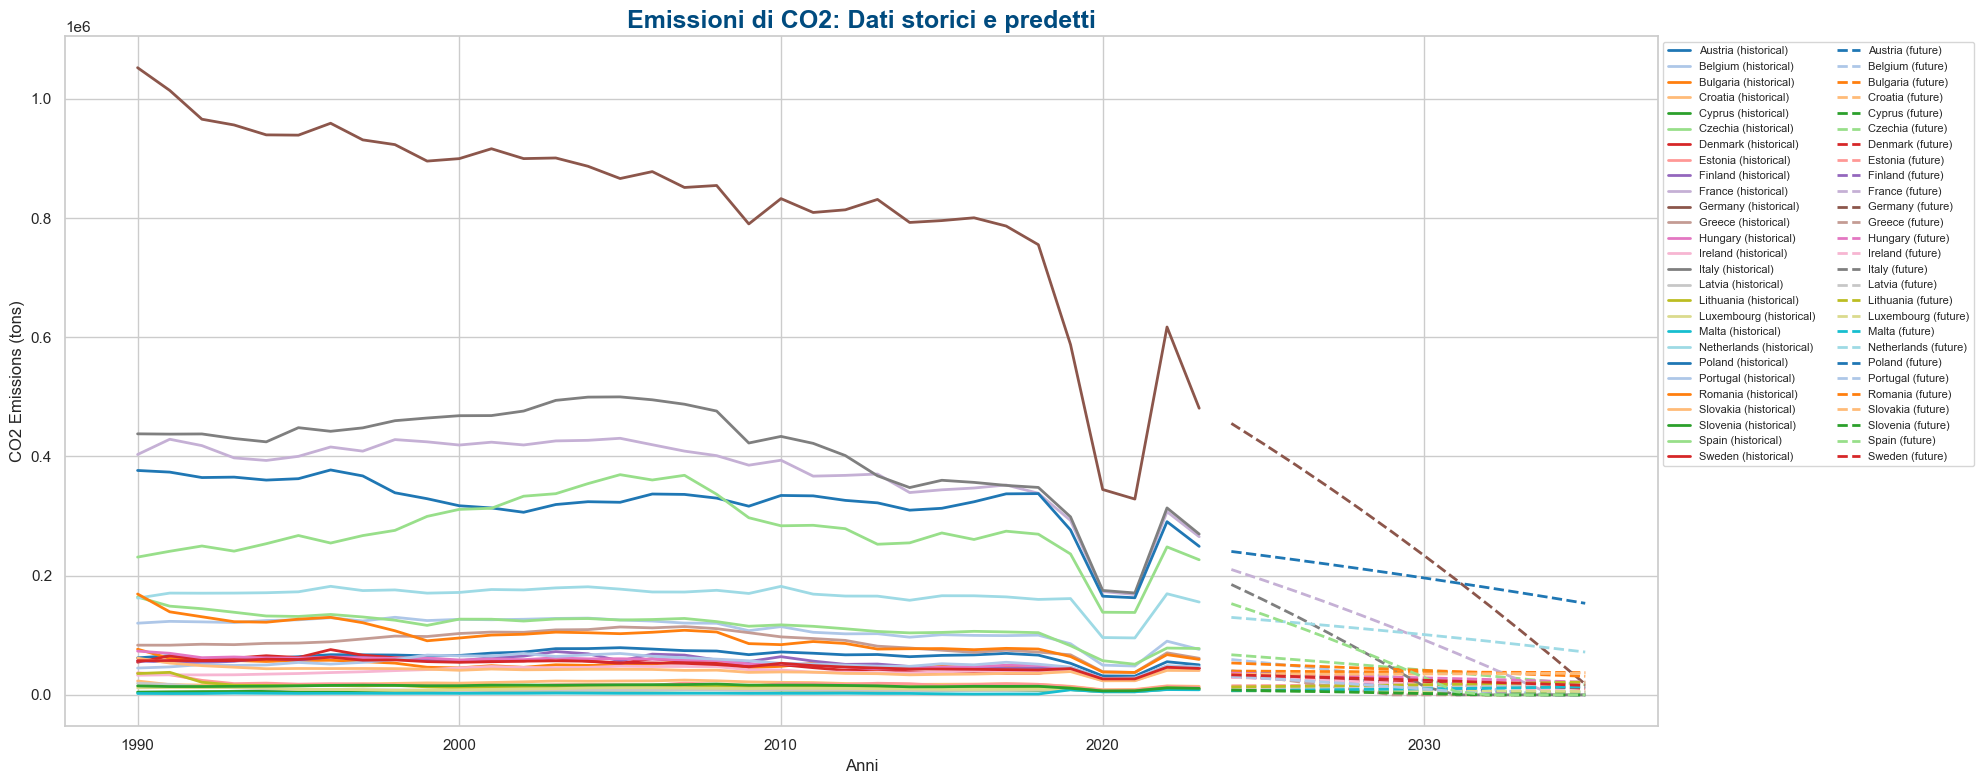

In [308]:
# Struttura dati per le predizioni
predictions_co2 = pd.DataFrame({'Year' : range(2024, 2036)})

# Grado del polinomio
degree =  2

# DataFrame per memorizzare le metriche
metrics_df_poly = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Addestramento di un modello di regressione polinomiale per ogni paese 
for country in df_co2['Country']:
    # Estrazione dati storici per Paese
    country_data = df_co2[df_co2['Country']==country].iloc[:,1:].values.flatten()
    
    # Trasformazione anni in formato polinomiale
    poly = PolynomialFeatures(degree=degree)
    years_poly = poly.fit_transform(years)

    # Addestramento modello
    model = LinearRegression()
    model.fit(years_poly, country_data)

    # Predizione sullo stesso set di dati
    y_pred = model.predict(years_poly)

    # Calcolo metriche
    mse = mean_squared_error(country_data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(country_data, y_pred)

    # Salvataggio metriche
    metrics_df_poly.loc[len(metrics_df_poly)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

    # Predizione valori futuri
    future_years_poly = poly.transform(future_years)
    future_pred = model.predict(future_years_poly)

    # Impostazione valori negativi a zero
    future_pred = np.maximum(future_pred, 0)

    # Aggiunta presizioni al DF
    predictions_co2[country] = future_pred

# Grafico
plot_historical_vs_predicted(df_hist=df_co2, df_pred=predictions_co2, title='Emissioni di CO2: Dati storici e predetti', ylabel='CO2 Emissions (tons)', figsize=(20, 8))

#### LSTM

LSTM è un tipo di rete neurale progettata per lavorare con sequenze di dati. È particolarmente utile per analizzare dati dove lʼordine e la dipendenza temporale tra i valori sono importanti.

In [309]:
# Preprocessing dei dati
def prepare_lstm_data(data, sequence_length):
    '''
    Funzione di preprocessing per lstm.
    Parametri: 
    - data: array o lista contenente i dati da cui estrarre le sequenze temporali
    - sequence_length: lunghezza della sequenza temporale
    '''
    X,y = [],[]
    for i in range(len(data)-sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Parametri
sequence_length = 5 # lunghezza finestra temporale
future_steps = 12 # numero di anni futuri da predire

# Struttura dati per le predizioni
predictions = pd.DataFrame({'Year' : range(2024, 2024+future_steps)})

# DataFrame per memorizzare le metriche
metrics_df_lstm = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Addestramento di un modello LSTM per ogni paese 
for country in df_co2['Country']:
    # Estrazione dati storici per Paese
    country_data = df_co2[df_co2['Country']==country].iloc[:,1:].values.flatten()
    years = df_co2.columns[1:].astype(int)
    
    # Normalizzazione dei dati
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(country_data.reshape(-1,1)).flatten()

    # Sequenze temporali
    X,y = prepare_lstm_data(scaled_data, sequence_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Creazione modello
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length,1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Addestramento modello
    model.fit(X, y, epochs=50, batch_size=16, verbose=0)

    # Predizione valori futuri
    future_input = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
    future_predictions = []

    for _ in range(future_steps):
        pred = model.predict(future_input, verbose=0)[0, 0]
        future_predictions.append(pred)
        future_input = np.append(future_input.flatten()[1:], pred).reshape(1, sequence_length, 1)
    
    # Inversione della scalatura
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1)).flatten()

    # Aggiunta presizioni al DF
    predictions[country] = future_predictions

    # Calcolo metriche di valutazione
    y_train_pred_scaled = model.predict(X, verbose=0).flatten()
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1,1)).flatten()
    y_train = scaler.inverse_transform(y.reshape(-1,1)).flatten()

    mse = np.mean((y_train-y_train_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - (np.sum((y_train-y_train_pred) ** 2)) / np.sum((y_train-np.mean(y_train)) ** 2)

    # Salvataggio metriche
    metrics_df_lstm.loc[len(metrics_df_lstm)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

print(predictions.head())



c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola

   Year       Austria       Belgium      Bulgaria       Croatia       Cyprus  \
0  2024  50274.601562  75952.687500  42465.781250  14480.596680  7683.977539   
1  2025  50386.773438  75355.750000  42379.062500  14488.084961  7556.917480   
2  2026  52269.664062  78362.281250  43649.417969  15304.071289  7829.922852   
3  2027  54380.292969  81808.976562  45054.492188  16133.229492  8142.704590   
4  2028  54355.761719  81020.523438  44931.515625  16244.004883  7981.786621   

        Czechia       Denmark       Estonia       Finland  ...   Luxembourg  \
0  76883.593750  41143.460938  13836.021484  44267.664062  ...  8586.263672   
1  76862.046875  40836.554688  13909.391602  44239.433594  ...  8526.705078   
2  79280.601562  42450.363281  14352.919922  46007.718750  ...  8733.762695   
3  82443.164062  44327.656250  14789.417969  47958.585938  ...  8968.951172   
4  83102.242188  44023.773438  14827.602539  47921.140625  ...  8907.504883   

         Malta    Netherlands        Poland 

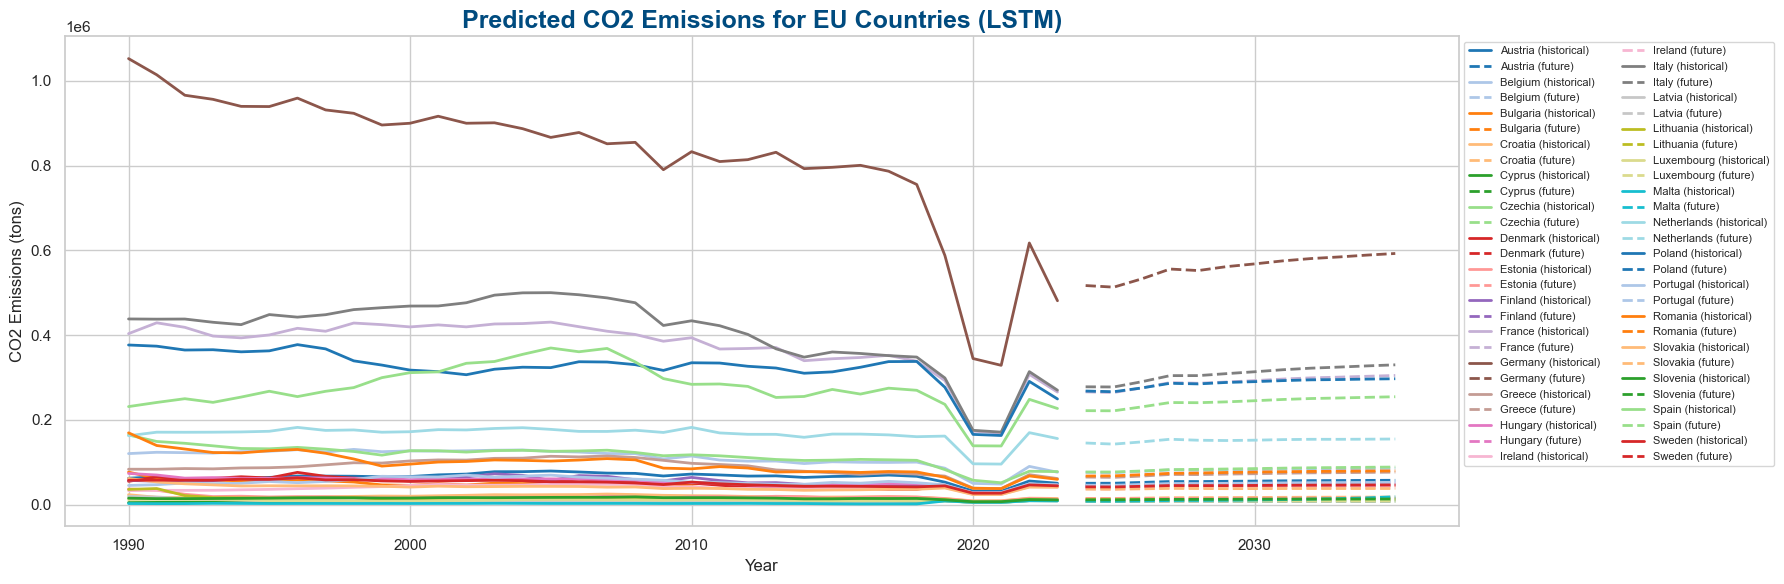

In [310]:
plt.figure(figsize=(18, 6))

countries = df_co2['Country']
palette = plt.cm.tab20.colors

color_map = {
    country: palette[i % len(palette)]
    for i, country in enumerate(countries)
}

years_pred = predictions['Year'].values

for country in countries:
    # Dati storici
    hist_values = (df_co2[df_co2['Country'] == country].iloc[0, 1:].values.flatten())

    sns.lineplot(
        x=years,
        y=hist_values,
        color=color_map[country],
        linewidth=2,
        label=f'{country} (historical)'
    )

    # Predizioni future
    sns.lineplot(
        x=years_pred,
        y=predictions[country],
        color=color_map[country],
        linestyle='--',
        linewidth=2,
        label=f'{country} (future)'
    )

plt.title(
    'Predicted CO2 Emissions for EU Countries (LSTM)',
    fontsize=18, fontweight='bold', color='#004b7f'
)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (tons)')

plt.legend(
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()

#### Visualizzazione metriche per confrontare i modelli

In [311]:
# Regressione Lineare
print(metrics_df)

        Country          RMSE        R2
0       Austria   9794.724758  0.134555
1       Belgium  12352.978660  0.645648
2      Bulgaria   5758.002782  0.563676
3       Croatia   3443.809527  0.140745
4        Cyprus    997.912061  0.288493
5       Czechia  10934.613219  0.788213
6       Denmark   6059.601943  0.731392
7       Estonia   4211.393300  0.379060
8       Finland   7731.677096  0.413629
9        France  42881.650945  0.571467
10      Germany  90112.124010  0.704625
11       Greece  16295.264958  0.269919
12      Hungary   4862.535704  0.768604
13      Ireland   5964.575186  0.002095
14        Italy  58113.377776  0.515387
15       Latvia   2322.464983  0.361709
16    Lithuania   4697.268666  0.393876
17   Luxembourg   1527.445965  0.183370
18        Malta   1621.478950  0.243229
19  Netherlands  16303.399181  0.243699
20       Poland  33913.245845  0.498271
21     Portugal   9052.938558  0.138176
22      Romania  11014.103773  0.839795
23     Slovakia   4210.573668  0.625005


In [312]:
# Regressione Lineare Polinomiale
print(metrics_df_poly)

        Country          RMSE        R2
0       Austria   6424.656257  0.627647
1       Belgium   8731.871800  0.822946
2      Bulgaria   5699.219211  0.572540
3       Croatia   2353.891608  0.598564
4        Cyprus    855.959829  0.476518
5       Czechia   9956.418489  0.824411
6       Denmark   5896.293415  0.745676
7       Estonia   3987.262617  0.443394
8       Finland   5674.342773  0.684168
9        France  29882.136717  0.791904
10      Germany  76373.585669  0.787825
11       Greece   8615.014406  0.795939
12      Hungary   4782.669892  0.776143
13      Ireland   4432.012941  0.449024
14        Italy  34127.690881  0.832869
15       Latvia   1645.768940  0.679478
16    Lithuania   4193.000702  0.517030
17   Luxembourg   1504.492922  0.207729
18        Malta   1349.652055  0.475693
19  Netherlands  14144.170002  0.430762
20       Poland  32871.204249  0.528630
21     Portugal   6099.059992  0.608830
22      Romania  10967.295150  0.841154
23     Slovakia   3977.659675  0.665345


In [313]:
# LSTM
print(metrics_df_lstm)

        Country           RMSE        R2
0       Austria    9116.702526  0.347754
1       Belgium   12807.952836  0.654654
2      Bulgaria    5875.907946  0.304530
3       Croatia    2904.426774  0.431369
4        Cyprus     939.295628  0.143536
5       Czechia   12296.396994  0.673216
6       Denmark    6940.578117  0.649485
7       Estonia    2604.607063  0.159865
8       Finland    7583.401300  0.511095
9        France   43239.363482  0.607210
10      Germany  101123.570762  0.612985
11       Greece   13467.464090  0.572045
12      Hungary    5874.677404  0.609680
13      Ireland    5235.382242  0.209062
14        Italy   52762.705655  0.652959
15       Latvia     868.292686  0.152129
16    Lithuania    1981.830879  0.209192
17   Luxembourg    1437.742931  0.160823
18        Malta    1579.976994  0.371951
19  Netherlands   17820.396804  0.222296
20       Poland   41377.223658  0.234994
21     Portugal    8042.310400  0.382887
22      Romania   13902.556662  0.612375
23     Slovakia 

Nonostante l’uso di un modello LSTM, tipicamente adatto a serie temporali, i risultati mostrano che per dataset di dimensioni limitate e caratterizzati da trend strutturali di lungo periodo, modelli più semplici come la regressione polinomiale risultano più efficaci e stabili.

### Predizione sull'utilizzo di Energie Rinnovabili dei Paesi dell'Unione Europea al 2035


In [314]:
df_renw = cleaned_renewable_df.copy()
years = np.array([int(year) for year in df_renw.columns[1:]]).reshape(-1,1)
future_years = np.array(range(2024, 2036)).reshape(-1, 1)
df_renw.head()

Country   2005   2006   2007   2008   2009   2010   2011   2012   2013  \
0   Austria  61.04  61.91  63.42  63.91  66.13  61.48  60.63  69.57  72.57   
1   Belgium   2.41   2.63   2.73   3.16   3.29   3.97   5.58   8.18  10.10   
2  Bulgaria  10.67  10.03   7.58   7.55  10.03  13.72   9.21  12.73  17.23   
3   Croatia  54.33  51.81  38.55  46.01  56.10  62.88  47.16  49.56  65.86   
4    Cyprus   0.02   0.02   0.04   0.06   0.08   0.71   2.56   4.39   6.48   

    2014   2015   2016   2017   2018   2019   2020   2021   2022   2023  
0  75.61  71.04  72.15  70.77  69.88  70.26  69.95  69.61  70.60  70.48  
1  12.88  15.03  12.27  14.13  13.43  13.43  14.84  13.26  13.81  13.11  
2  16.34  18.29  16.37  14.04  13.71  14.34  13.64  14.56  13.17  14.53  
3  72.97  64.97  63.48  56.54  56.86  57.86  56.41  57.11  58.18  57.59  
4   6.11   7.65   7.61   8.09   6.85   8.27   7.69   7.68   7.48   7.67

#### Regressione Lineare 

In [315]:
# Struttura dati per le predizioni
predictions = pd.DataFrame({'Year' : range(2024, 2036)})

# DataFrame per memorizzare i risulati 
metrics_df = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Evitare warning su fillna
pd.set_option('future.no_silent_downcasting',True)

# Addestramento di un modello di regressione lineare per ogni paese per predire i valori futuri
for country in df_renw['Country']:
    # Estrazione dati storici per Paese
    country_data = df_renw[df_renw['Country']==country].iloc[0,1:].fillna(0).values.flatten()
    
    # Addestramento modello
    model = LinearRegression()
    model.fit(years, country_data)

    # Predizione sullo stesso set di dati
    y_pred = model.predict(years)

    # Calcolo metriche
    mse = mean_squared_error(country_data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(country_data, y_pred)

    # Salvataggio metriche
    metrics_df.loc[len(metrics_df)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

    # Predizione valori futuri
    future_pred = model.predict(future_years)

    # Aggiunta presizioni al DF
    predictions[country] = future_pred

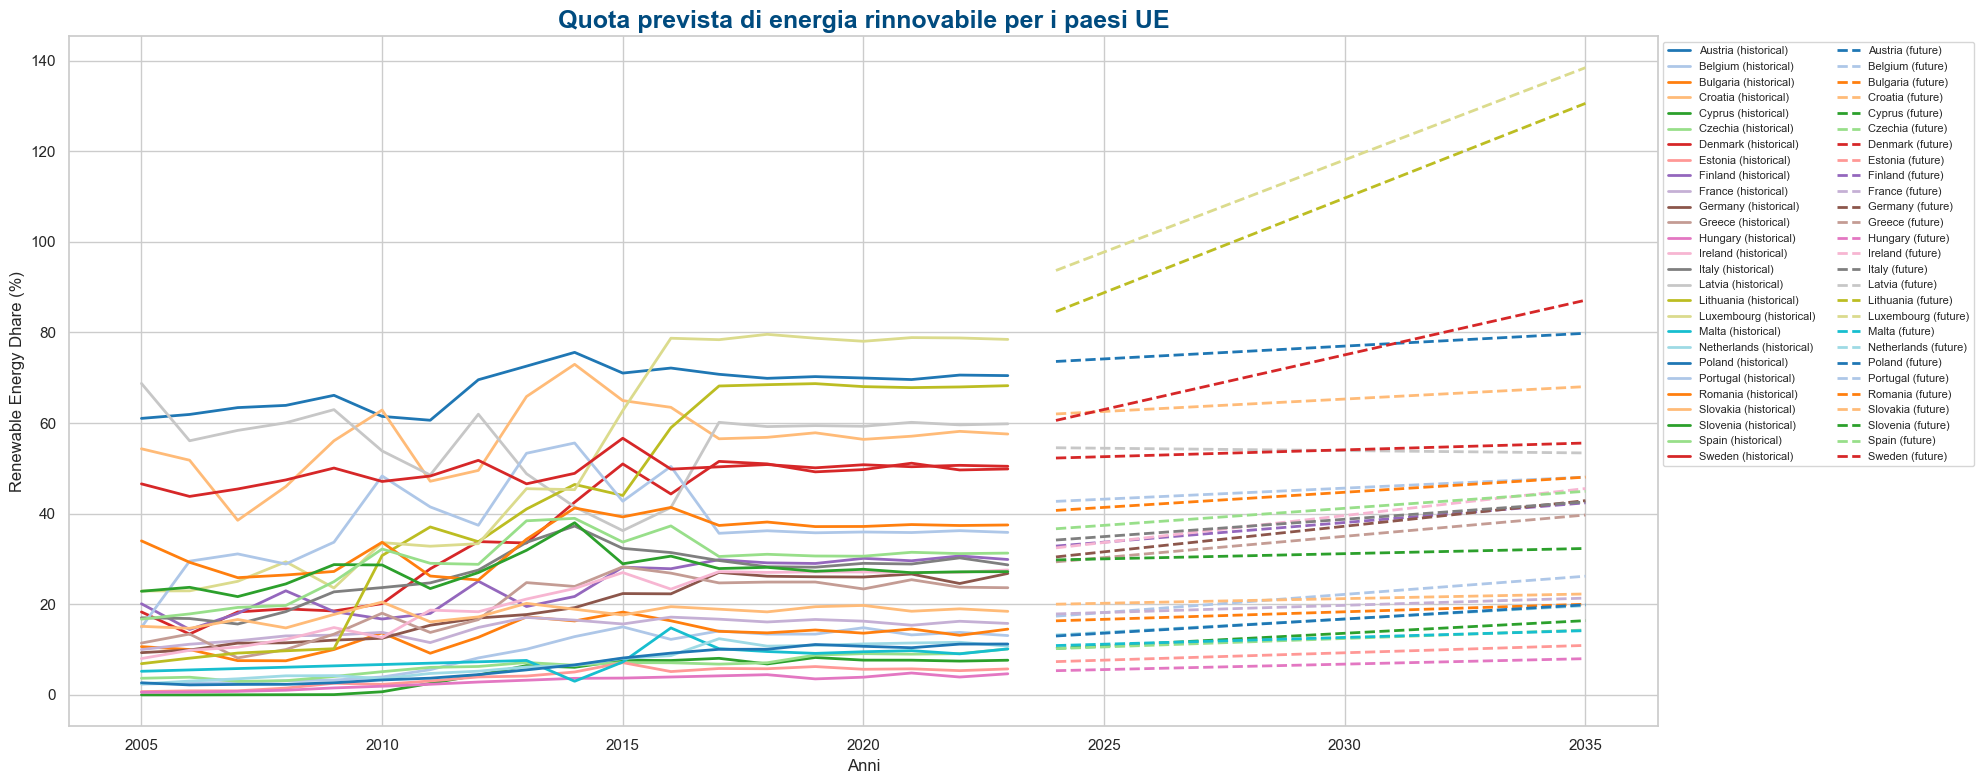

In [316]:
plot_historical_vs_predicted(df_hist=df_renw, df_pred=predictions, title='Quota prevista di energia rinnovabile per i paesi UE', ylabel='Renewable Energy Dhare (%)', figsize=(20, 8))

#### Regressione Lineare Polinomiale

In [317]:
# Struttura dati per le predizioni
predictions_poly = pd.DataFrame({'Year' : range(2024, 2036)})

# Grado del polinomio
degree =  2

# DataFrame per memorizzare le metriche
metrics_df_poly = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Addestramento di un modello di regressione polinomiale per ogni paese 
for country in df_renw['Country']:
    # Estrazione dati storici per Paese
    country_data = df_renw[df_renw['Country']==country].iloc[0,1:].fillna(0).values.flatten()
    
    # Trasformazione anni in formato polinomiale
    poly = PolynomialFeatures(degree=degree)
    years_poly = poly.fit_transform(years)

    # Addestramento modello
    model = LinearRegression()
    model.fit(years_poly, country_data)

    # Predizione sullo stesso set di dati
    y_pred = model.predict(years_poly)

    # Calcolo metriche
    mse = mean_squared_error(country_data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(country_data, y_pred)

    # Salvataggio metriche
    metrics_df_poly.loc[len(metrics_df_poly)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

    # Predizione valori futuri
    future_years_poly = poly.transform(future_years)
    future_pred = model.predict(future_years_poly)

    # Impostazione valori negativi a zero
    future_pred = np.maximum(future_pred, 0)

    # Aggiunta presizioni al DF
    predictions[country] = future_pred


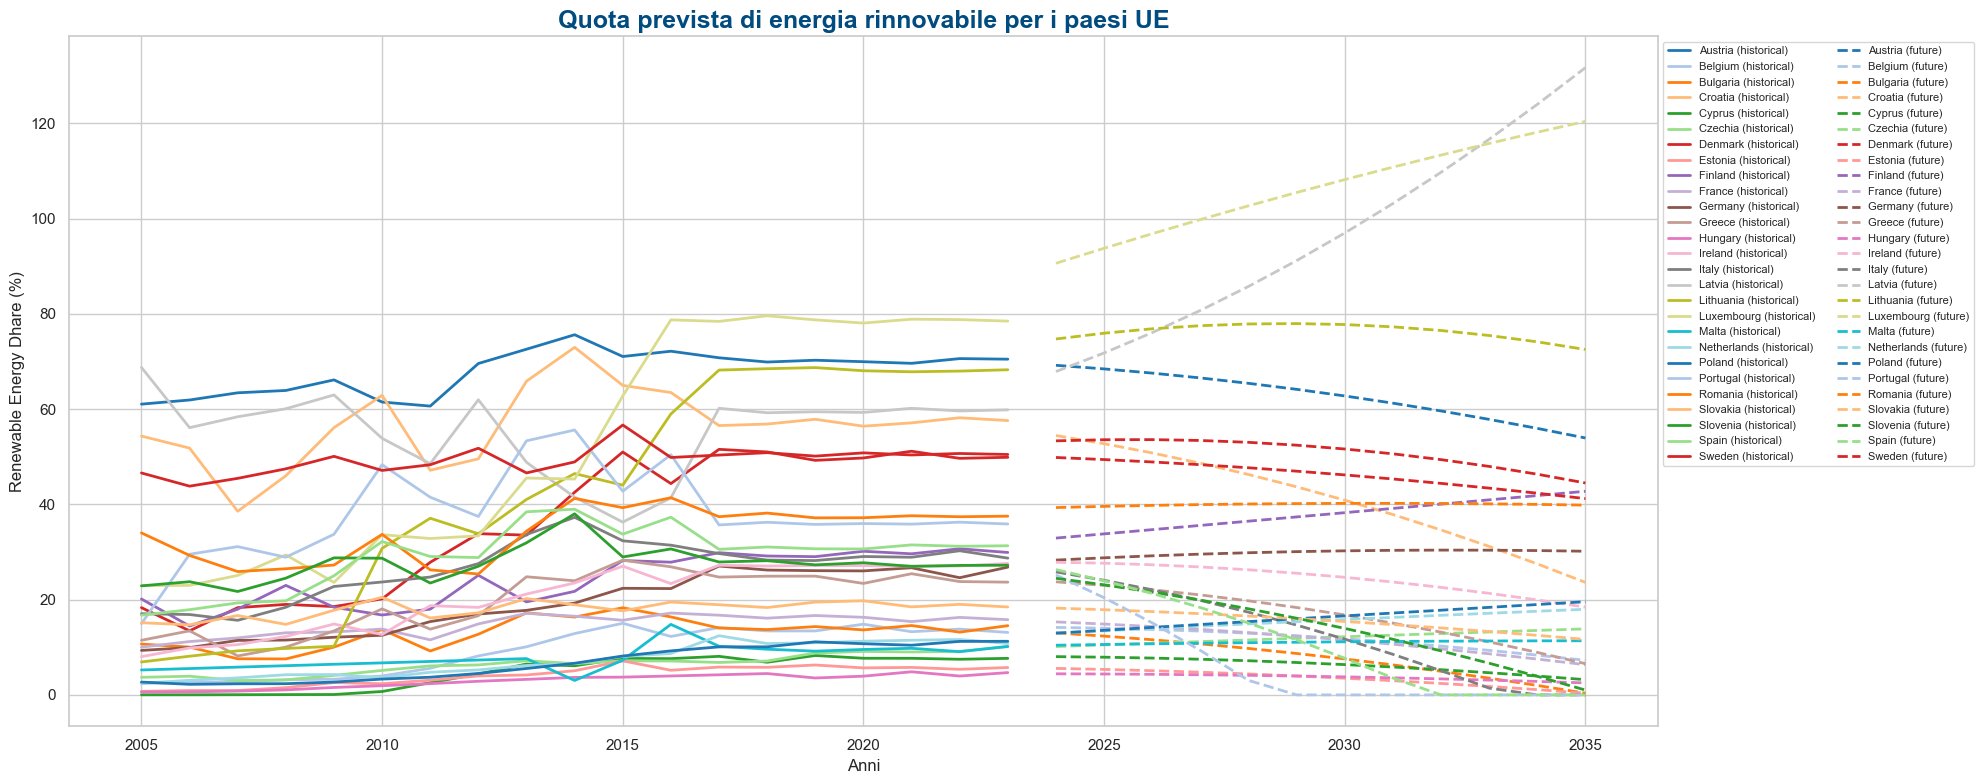

In [318]:
plot_historical_vs_predicted(df_hist=df_renw, df_pred=predictions, title='Quota prevista di energia rinnovabile per i paesi UE', ylabel='Renewable Energy Dhare (%)', figsize=(20, 8))

#### LSTM


In [319]:
# Parametri
sequence_length = 5 # lunghezza finestra temporale
future_steps = 12 # numero di anni futuri da predire

# Struttura dati per le predizioni
predictions = pd.DataFrame({'Year' : range(2024, 2024+future_steps)})

# DataFrame per memorizzare le metriche
metrics_df_lstm = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Addestramento di un modello LSTM per ogni paese 
for country in df_renw['Country']:
    # Estrazione dati storici per Paese
    country_data = df_renw[df_renw['Country']==country].iloc[0,1:].values.flatten()
    years = df_renw.columns[1:].astype(int)
    
    # Normalizzazione dei dati
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(country_data.reshape(-1,1)).flatten()

    # Sequenze temporali
    X,y = prepare_lstm_data(scaled_data, sequence_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Creazione modello
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length,1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Addestramento modello
    model.fit(X, y, epochs=100, batch_size=16, verbose=0)

    # Predizione valori futuri
    future_input = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
    future_predictions = []

    for _ in range(future_steps):
        pred = model.predict(future_input, verbose=0)[0, 0]
        future_predictions.append(pred)
        future_input = np.append(future_input.flatten()[1:], pred).reshape(1, sequence_length, 1)
    
    # Inversione della scalatura
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1)).flatten()

    # Aggiunta presizioni al DF
    predictions[country] = future_predictions

    # Calcolo metriche di valutazione
    y_train_pred_scaled = model.predict(X, verbose=0).flatten()
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1,1)).flatten()
    y_train = scaler.inverse_transform(y.reshape(-1,1)).flatten()

    mse = np.mean((y_train-y_train_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - (np.sum((y_train-y_train_pred) ** 2)) / np.sum((y_train-np.mean(y_train)) ** 2)

    # Salvataggio metriche
    metrics_df_lstm.loc[len(metrics_df_lstm)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

print(predictions.head())



c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola

   Year    Austria    Belgium   Bulgaria    Croatia    Cyprus    Czechia  \
0  2024  70.470055  14.476995  14.544299  58.860668  8.195494  10.171583   
1  2025  70.490158  14.704576  14.577408  58.892998  8.198206  10.445177   
2  2026  70.552635  14.740143  14.678581  59.115833  8.271025  10.720884   
3  2027  70.665192  14.979604  14.699063  59.306973  8.337776  11.104018   
4  2028  70.673164  15.163798  14.849409  59.392258  8.464354  11.566669   

     Denmark   Estonia    Finland  ...  Luxembourg     Malta  Netherlands  \
0  54.137596  6.149866  31.656687  ...   83.881653  9.538319    12.241946   
1  54.808659  6.140889  32.188351  ...   84.780853  9.590616    12.507697   
2  55.635860  6.215659  32.565056  ...   86.087753  9.604720    12.758922   
3  56.235889  6.289127  33.196835  ...   87.362778  9.581137    13.015992   
4  57.544949  6.429996  33.706142  ...   88.935036  9.650635    13.298667   

      Poland   Portugal    Romania   Slovakia   Slovenia      Spain     Sweden  

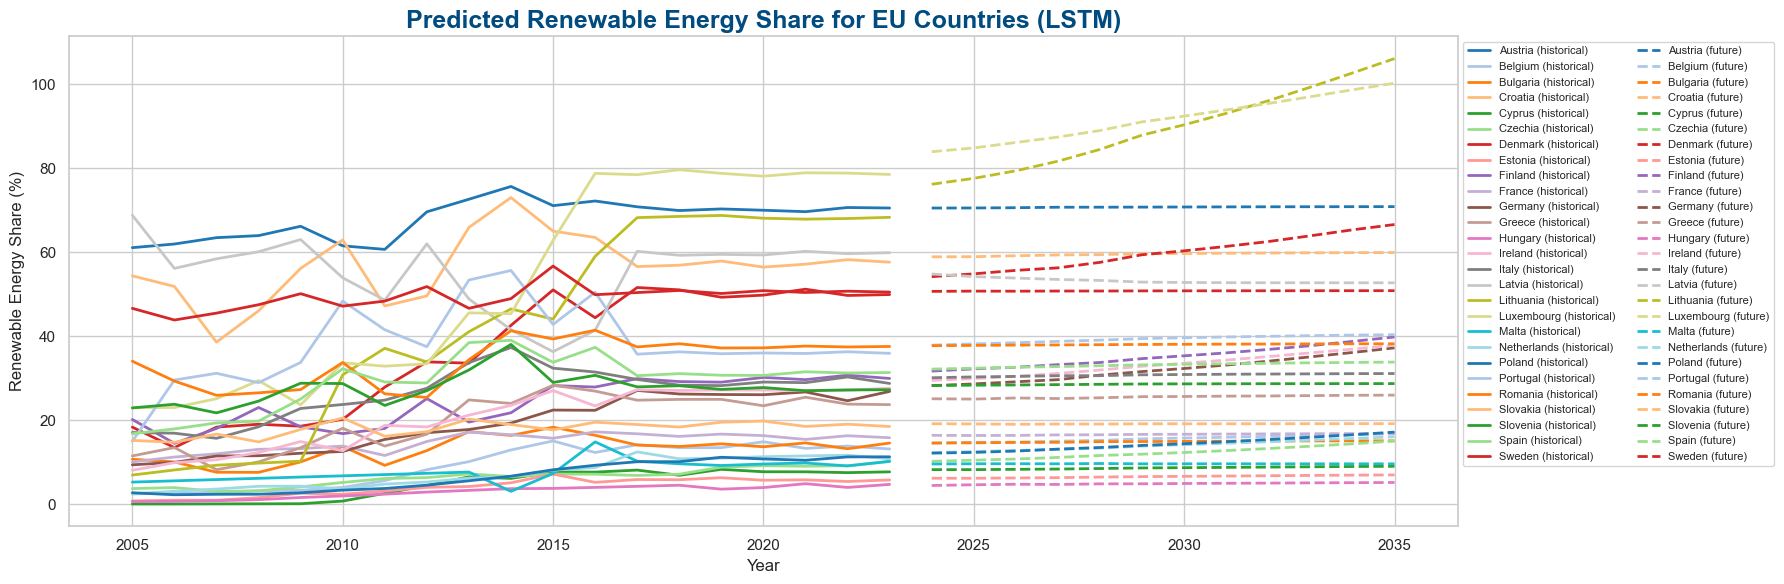

In [320]:
plt.figure(figsize=(18, 6))

countries = df_renw['Country']
palette = plt.cm.tab20.colors

color_map = {
    country: palette[i % len(palette)]
    for i, country in enumerate(countries)
}

years_pred = predictions['Year'].values

for country in countries:
    # Dati storici
    hist_values = df_renw[df_renw['Country'] == country].iloc[0, 1:].values.flatten()

    sns.lineplot(
        x=years,
        y=hist_values,
        color=color_map[country],
        linewidth=2,
        label=f'{country} (historical)'
    )

for country in predictions.columns[1:]:
    # Predizioni future
    sns.lineplot(
        x=years_pred,
        y=predictions[country],
        color=color_map[country],
        linestyle='--',
        linewidth=2,
        label=f'{country} (future)'
    )

plt.title(
    'Predicted Renewable Energy Share for EU Countries (LSTM)',
    fontsize=18, fontweight='bold', color='#004b7f'
)
plt.xlabel('Year')
plt.ylabel('Renewable Energy Share (%)')

plt.legend(
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()

#### Visualizzazione metriche per confrontare i modelli

In [321]:
# Regressione Lineare
print(metrics_df)

        Country      RMSE        R2
0       Austria  3.116639  0.496923
1       Belgium  2.051643  0.820725
2      Bulgaria  2.416969  0.362329
3       Croatia  7.069715  0.152781
4        Cyprus  1.408474  0.824316
5       Czechia  0.596186  0.921627
6       Denmark  5.202135  0.865690
7       Estonia  0.912999  0.791871
8       Finland  2.586226  0.771390
9        France  1.309668  0.638156
10      Germany  1.784761  0.923098
11       Greece  3.578838  0.673957
12      Hungary  0.486504  0.880485
13      Ireland  2.305087  0.888882
14        Italy  4.181062  0.500492
15       Latvia  8.208951  0.004794
16    Lithuania  6.826949  0.918235
17   Luxembourg  8.066665  0.884117
18        Malta  1.895627  0.427271
19  Netherlands  1.062002  0.901780
20       Poland  0.923317  0.932345
21     Portugal  8.847559  0.083304
22      Romania  3.919876  0.465446
23     Slovakia  1.321839  0.419423
24     Slovenia  3.327384  0.124719
25        Spain  4.948656  0.409091
26       Sweden  2.164760  0

In [322]:
# Regressione Lineare Polinomiale
print(metrics_df_poly)

        Country      RMSE        R2
0       Austria  2.623081  0.643643
1       Belgium  1.640243  0.885414
2      Bulgaria  2.051002  0.540816
3       Croatia  6.452748  0.294200
4        Cyprus  1.116464  0.889611
5       Czechia  0.595369  0.921842
6       Denmark  4.402418  0.903810
7       Estonia  0.601233  0.909744
8       Finland  2.586129  0.771407
9        France  0.871603  0.839736
10      Germany  1.581310  0.939631
11       Greece  2.856437  0.792298
12      Hungary  0.330057  0.944992
13      Ireland  1.483551  0.953973
14        Italy  2.689798  0.793267
15       Latvia  6.442078  0.387100
16    Lithuania  5.689029  0.943221
17   Luxembourg  7.980976  0.886566
18        Malta  1.886642  0.432687
19  Netherlands  1.056042  0.902879
20       Poland  0.923063  0.932382
21     Portugal  5.778199  0.609012
22      Romania  3.883088  0.475433
23     Slovakia  1.126115  0.578626
24     Slovenia  2.631395  0.452589
25        Spain  2.966265  0.787692
26       Sweden  1.951937  0

In [323]:
# LSTM
print(metrics_df_lstm)

        Country       RMSE        R2
0       Austria   3.440157  0.186581
1       Belgium   1.945431  0.659440
2      Bulgaria   2.194640 -0.058400
3       Croatia   6.533926 -0.054108
4        Cyprus   1.163374  0.716799
5       Czechia   0.613061  0.806110
6       Denmark   5.618308  0.677272
7       Estonia   0.796863  0.588196
8       Finland   2.905792  0.630191
9        France   1.217422  0.286728
10      Germany   2.176460  0.787658
11       Greece   3.080130  0.380344
12      Hungary   0.413048  0.740331
13      Ireland   2.305273  0.731060
14        Italy   3.359422 -0.021326
15       Latvia   7.801079  0.125312
16    Lithuania   6.242325  0.817152
17   Luxembourg  10.012775  0.732272
18        Malta   2.358781  0.121369
19  Netherlands   1.366135  0.773093
20       Poland   1.085468  0.855049
21     Portugal   8.086408 -0.309166
22      Romania   3.950745  0.270858
23     Slovakia   1.238073 -0.184979
24     Slovenia   3.198524 -0.006692
25        Spain   4.175305 -0.693058
2

# Focus sull'Italia

## Analisi descrittiva

In [324]:
df_ch4_it = df_emissions.get('CH4')[df_emissions.get('CH4')['Country']=='Italy'].copy()
df_nox_it = df_emissions.get('NOx')[df_emissions.get('NOx')['Country']=='Italy'].copy()
df_co2_it = df_emissions.get('CO2')[df_emissions.get('CO2')['Country']=='Italy'].copy()
df_n2o_it = df_emissions.get('N2O')[df_emissions.get('N2O')['Country']=='Italy'].copy()
df_so2_it = df_emissions.get('SO2')[df_emissions.get('SO2')['Country']=='Italy'].copy()

In [325]:
df_ch4_it.head()

Country    1990     1991     1992     1993     1994     1995     1996  \
82   Italy  1929.9  1965.06  1959.08  1971.34  1988.34  2013.03  2032.67   

       1997     1998  ...     2014     2015     2016     2017     2018  \
82  2054.56  2035.22  ...  1756.19  1755.34  1735.97  1746.32  1721.31   

       2019    2020    2021     2022    2023  
82  1215.95  766.13  717.73  1276.75  954.28  

[1 rows x 35 columns]

In [326]:
df_ch4_it = update_gas_column(df_ch4_it, 'CH4')
df_nox_it = update_gas_column(df_nox_it, 'NOx')
df_co2_it = update_gas_column(df_co2_it, 'CO2')
df_n2o_it = update_gas_column(df_n2o_it, 'N2O')
df_so2_it = update_gas_column(df_so2_it, 'SO2')



In [327]:
df_italy = pd.concat([df_ch4_it,df_nox_it,df_co2_it,df_n2o_it,df_so2_it], ignore_index=True)

df_italy.head()

Gas       1990       1991       1992       1993       1994       1995  \
0  CH4    1929.90    1965.06    1959.08    1971.34    1988.34    2013.03   
1  NOx    2127.05    2194.19    2233.25    2129.41    2029.14    1990.80   
2  CO2  438008.80  437538.60  437829.80  430179.96  424581.72  448332.91   
3  N2O      87.37      90.78      89.22      90.71      88.94      92.55   
4  SO2    1783.86    1672.65    1574.23    1471.75    1389.49    1322.67   

        1996       1997       1998  ...       2014       2015       2016  \
0    2032.67    2054.56    2035.22  ...    1756.19    1755.34    1735.97   
1    1918.96    1841.48    1727.59  ...     770.96     735.43     715.21   
2  442277.41  448044.94  460049.20  ...  347860.80  360088.18  356556.20   
3      92.93      96.23      97.15  ...      59.85      59.93      60.74   
4    1213.90    1138.37    1004.29  ...     131.58     124.49     116.95   

        2017       2018       2019       2020       2021       2022       2023  
0    1746.32    1721.31    1215.95     766.13     717.73    1276.75     954.28  
1     674.80     672.30     476.51     272.51     249.20     500.34     419.31  
2  351473.93  348085.03  298743.62  175214.36  171009.02  313680.80  269866.00  
3      60.43      59.38      91.24      53.41      50.03      95.80      93.13  
4     115.42     110.45     106.48      56.82      55.58     111.80      96.91  

[5 rows x 35 columns]

In [328]:
# Calcolco del totale delle emissioni
tot_emissions = df_italy.iloc[:, 1:].sum(axis=0)
tot_emissions.index = tot_emissions.index.astype(int)

tot_emissions.head()

1990    443936.98
1991    443461.28
1992    443685.58
1993    435843.17
1994    430077.63
dtype: float64

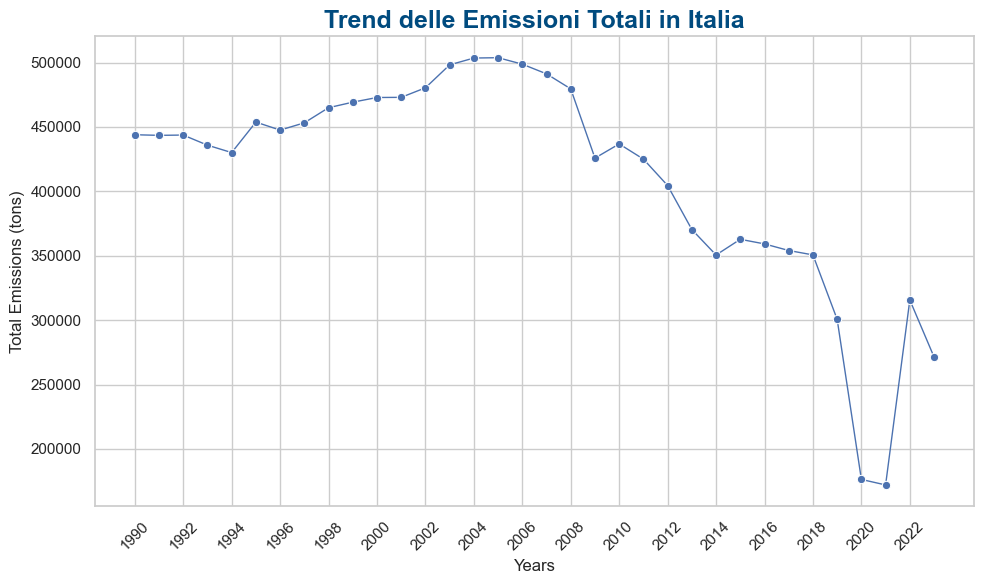

In [329]:
plt.figure(figsize=(10,6))

sns.lineplot(x = tot_emissions.index, 
            y= tot_emissions.values,
            marker='o',
            markersize=6,
            linewidth=1,
            )
plt.title('Trend delle Emissioni Totali in Italia', fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Years')
plt.ylabel('Total Emissions (tons)')
plt.grid(True)
years = tot_emissions.index
plt.xticks(np.arange(years.min(), years.max()+1, step=2), rotation=45)
plt.tight_layout()
plt.show()

### Trend del’Emissione dei Gas Serra senza CO2

In [330]:
# Valore massimo per ogni gas
df_max_values = df_italy.set_index('Gas').max(axis=1).reset_index()
df_max_values.columns = ['Gas', 'Valore massimo']

print(df_max_values)   

   Gas  Valore massimo
0  CH4         2054.56
1  NOx         2233.25
2  CO2       500005.68
3  N2O           99.02
4  SO2         1783.86


In [331]:
# Rimozione del CO2
df_no_co2 = df_italy[df_italy['Gas']!='CO2']
df_no_co2_melted = df_no_co2.melt(id_vars=['Gas'], var_name='Year', value_name='Emissions')

df_no_co2_melted.head()

Gas  Year  Emissions
0  CH4  1990    1929.90
1  NOx  1990    2127.05
2  N2O  1990      87.37
3  SO2  1990    1783.86
4  CH4  1991    1965.06

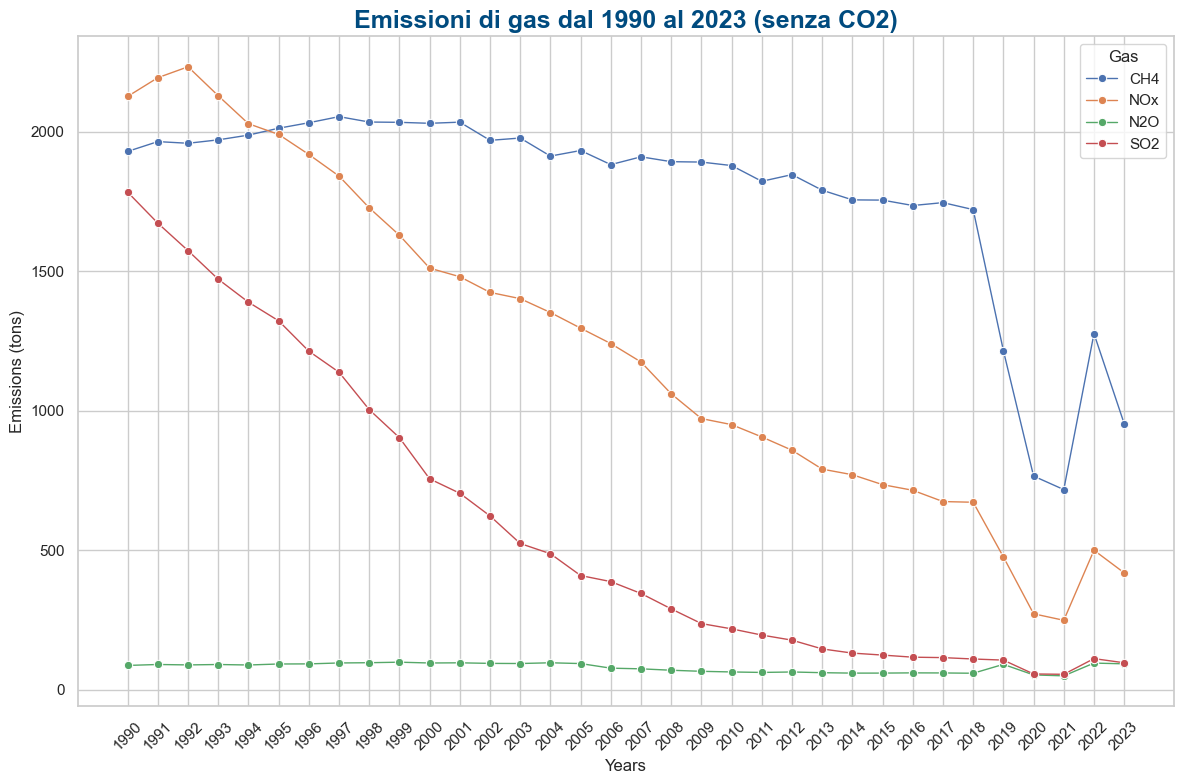

In [332]:
# Diagramma a linee
plt.figure(figsize=(12, 8))

for gas in df_no_co2['Gas']:
    data = df_no_co2_melted[df_no_co2_melted['Gas']==gas]
    sns.lineplot(x = data['Year'], 
                y= data['Emissions'],
                marker='o',
                markersize=6,
                linewidth=1,
                label=gas
                )
plt.title('Emissioni di gas dal 1990 al 2023 (senza CO2)', fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Years')
plt.ylabel('Emissions (tons)')
plt.legend(title='Gas')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Trend del’Utilizzo di Energie Rinnovabili in Italia dal 1990 al 2023

In [333]:
df_italy_renew = renewable_df[renewable_df['Country']=='Italy']

df_italy_renew.head()

Country   1990  1991   1992   1993  1994   1995   1996   1997   1998  ...  \
100   Italy  17.69  22.0  21.91  21.78  22.2  18.94  20.96  20.39  20.23  ...   

      2014   2015   2016   2017  2018  2019   2020  2021   2022   2023  
100  37.28  32.35  31.43  29.67  28.3  28.2  29.05  28.9  30.26  28.71  

[1 rows x 35 columns]

In [334]:
# Trasformazione delle date in numeri
df_italy_renew.columns = ['Country']+[int(col) for col in df_italy_renew.columns[1:]]

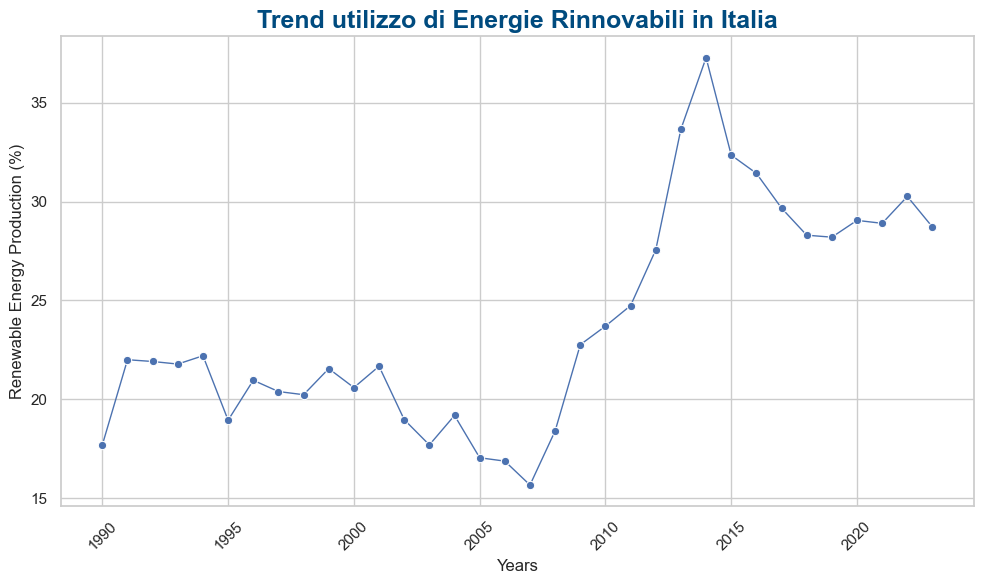

In [335]:
plt.figure(figsize=(10,6))

sns.lineplot(x = df_italy_renew.columns[1:], 
            y= df_italy_renew.iloc[0, 1:].astype(float),
            marker='o',
            markersize=6,
            linewidth=1
            )
plt.title('Trend utilizzo di Energie Rinnovabili in Italia', fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Years')
plt.ylabel('Renewable Energy Production (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Confronto con la media dell’Unione Europea dal 2005 al 2023

In [336]:
# Media delle colonne numeriche
df_eu_mean = cleaned_renewable_df.iloc[:, 1:].mean(axis=0).reset_index()
df_eu_mean.columns = ['Year', 'Mean Renewable Energy']

df_eu_mean.head()

Year  Mean Renewable Energy
0  2005              18.042963
1  2006              17.707407
2  2007              17.621481
3  2008              18.795185
4  2009              20.369259

In [337]:
df_italy_renew.head(10)

Country   1990  1991   1992   1993  1994   1995   1996   1997   1998  ...  \
100   Italy  17.69  22.0  21.91  21.78  22.2  18.94  20.96  20.39  20.23  ...   

      2014   2015   2016   2017  2018  2019   2020  2021   2022   2023  
100  37.28  32.35  31.43  29.67  28.3  28.2  29.05  28.9  30.26  28.71  

[1 rows x 35 columns]

In [338]:
df_italy_renew = df_italy_renew.loc[:, 2005:]
df_italy_renew.head(10)

2005   2006   2007  2008   2009  2010   2011   2012   2013   2014  \
100  17.04  16.87  15.66  18.4  22.76  23.7  24.74  27.56  33.67  37.28   

      2015   2016   2017  2018  2019   2020  2021   2022   2023  
100  32.35  31.43  29.67  28.3  28.2  29.05  28.9  30.26  28.71

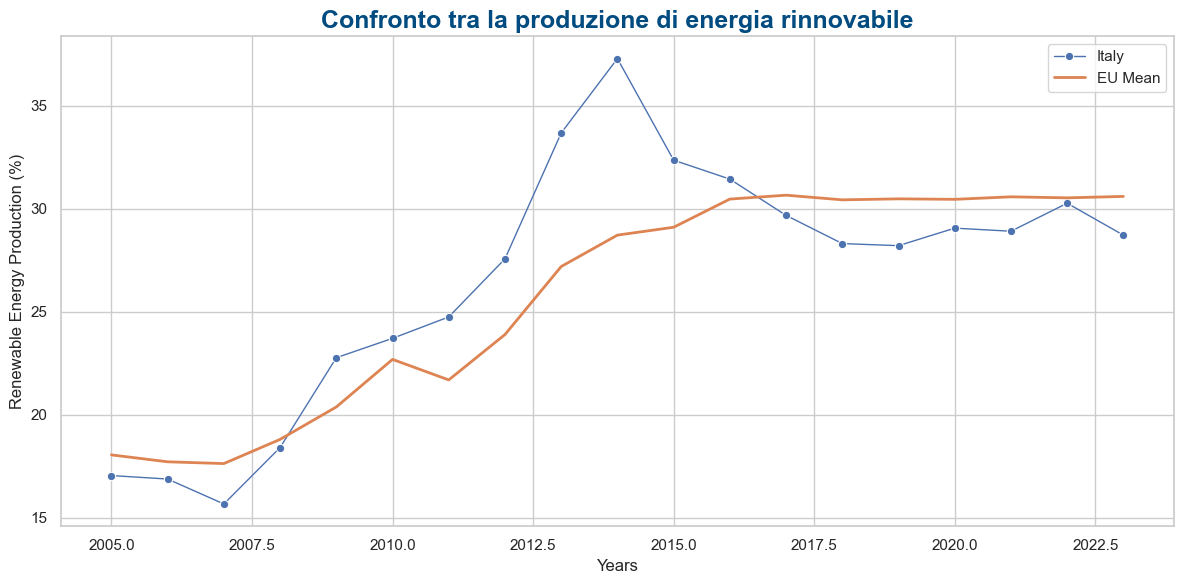

In [339]:
plt.figure(figsize=(12,6))
years = df_italy_renew.columns[0:].astype(int)
italy_val = df_italy_renew.iloc[0,:].astype(float)
eu_val = df_eu_mean['Mean Renewable Energy']

sns.lineplot(x = years, 
            y= italy_val,
            linewidth=1,
            label = 'Italy',
            marker='o'
            )
sns.lineplot(x = years, 
            y= eu_val,
            linewidth=2,
            label = 'EU Mean'
            )
plt.title('Confronto tra la produzione di energia rinnovabile', fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Years')
plt.ylabel('Renewable Energy Production (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Analisi predittiva

### Emissioni di Gas Serra senza CO2 in Italia

#### Regressione lineare

In [340]:
# Preparazione dei dati
years = np.array([int(year) for year in df_no_co2.columns[1:]]).reshape(-1,1)
future_years = np.array(range(2024, 2036)).reshape(-1,1)

In [341]:
# Struttura dati per le predizioni
predictions = pd.DataFrame({'Year' : range(2024, 2036)})

# DataFrame per memorizzare i risulati 
metrics_df = pd.DataFrame(columns=['Gas', 'RMSE', 'R2'])

# Addestramento di un modello di regressione lineare per ogni paese per predire i valori futuri
for gas in df_no_co2['Gas']:
    # Estrazione dati storici per Paese
    data = df_no_co2[df_no_co2['Gas']==gas].iloc[:,1:].values.flatten()
    
    # Addestramento modello
    model = LinearRegression()
    model.fit(years, data)

    y_pred = model.predict(years)

    # Predizione valori futuri
    future_pred = model.predict(future_years)

    # Aggiunta presizioni al DF
    predictions[gas] = future_pred

    # Calcolo metriche
    mse = mean_squared_error(data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(data, y_pred)

    # Salvataggio metriche
    metrics_df.loc[len(metrics_df)]={
        'Gas':gas,
        'RMSE':rmse,
        'R2':r2
    }

    

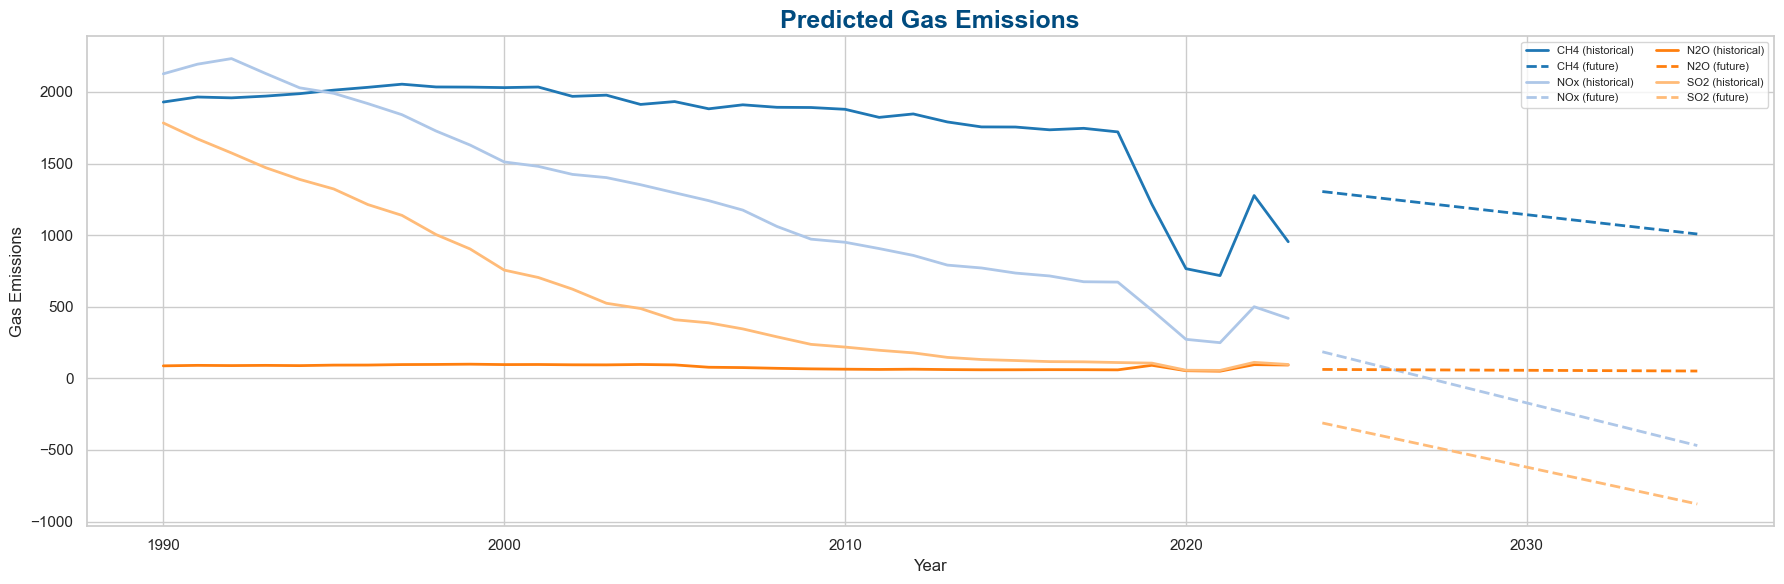

In [342]:
plt.figure(figsize=(18,6))

gases = df_no_co2['Gas']
palette = plt.cm.tab20.colors
color_map = {
    gas: palette[i % len(palette)]
    for i, gas in enumerate(gases)
}

years_hist = years.flatten()

# Linee storiche
for gas in gases:
    hist_values = (
        df_no_co2[df_no_co2['Gas'] == gas]
        .iloc[:, 1:]
        .values
        .flatten()
    )

    sns.lineplot(
        x=years_hist,
        y=hist_values,
        color=color_map[gas],
        linewidth=2,
        label=f"{gas} (historical)"
    )

    sns.lineplot(
        x=predictions['Year'],
        y=predictions[gas],
        color=color_map[gas],
        linestyle='--',
        linewidth=2,
        label=f"{gas} (future)"
    )

plt.title('Predicted Gas Emissions', fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Year')
plt.ylabel('Gas Emissions')

plt.legend(
    ncol=2,
    loc='best',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()


#### Regressione Lineare Polinomiale

In [343]:
# Struttura dati per le predizioni
predictions_poly = pd.DataFrame({'Year' : range(2024, 2036)})

# Grado del polinomio
degree =  2

# DataFrame per memorizzare le metriche
metrics_df_poly = pd.DataFrame(columns=['Gas', 'RMSE', 'R2'])

# Addestramento di un modello di regressione polinomiale per ogni paese 
for gas in df_no_co2['Gas']:
    # Estrazione dati storici per Paese
    data = df_no_co2[df_no_co2['Gas']==gas].iloc[:,1:].values.flatten()
    
    # Trasformazione anni in formato polinomiale
    poly = PolynomialFeatures(degree=degree)
    years_poly = poly.fit_transform(years)

    # Addestramento modello
    model = LinearRegression()
    model.fit(years_poly, data)

    # Predizione sullo stesso set di dati
    y_pred = model.predict(years_poly)

    # Calcolo metriche
    mse = mean_squared_error(data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(data, y_pred)

    # Salvataggio metriche
    metrics_df_poly.loc[len(metrics_df_poly)]={
        'Gas':gas,
        'RMSE':rmse,
        'R2':r2
    }

    # Predizione valori futuri
    future_years_poly = poly.transform(future_years)
    future_pred = model.predict(future_years_poly)

    # Aggiunta presizioni al DF
    predictions[gas] = future_pred



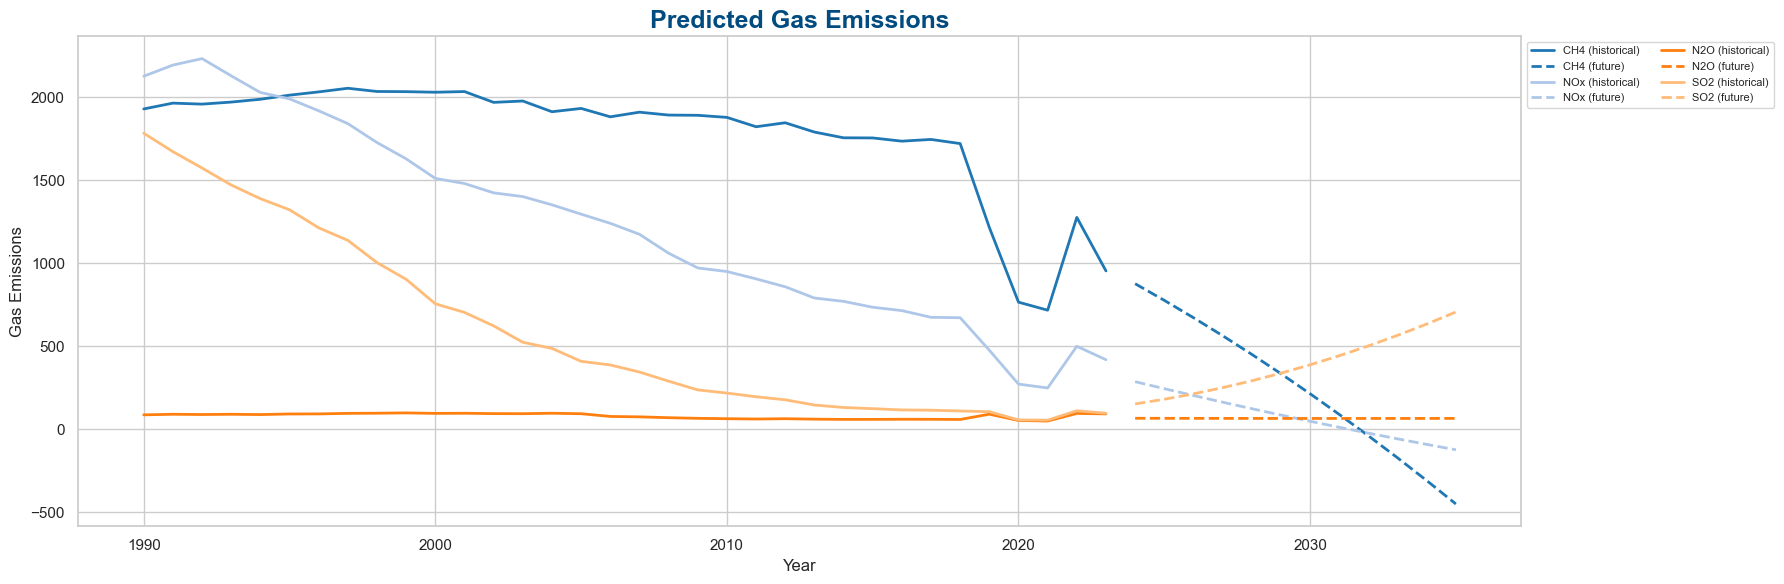

In [344]:
plt.figure(figsize=(18,6))

gases = df_no_co2['Gas']
palette = plt.cm.tab20.colors
color_map = {
    gas: palette[i % len(palette)]
    for i, gas in enumerate(gases)
}

years_hist = years.flatten()

# Linee storiche
for gas in gases:
    hist_values = (
        df_no_co2[df_no_co2['Gas'] == gas]
        .iloc[:, 1:]
        .values
        .flatten()
    )

    sns.lineplot(
        x=years_hist,
        y=hist_values,
        color=color_map[gas],
        linewidth=2,
        label=f"{gas} (historical)"
    )

    sns.lineplot(
        x=predictions['Year'],
        y=predictions[gas],
        color=color_map[gas],
        linestyle='--',
        linewidth=2,
        label=f"{gas} (future)"
    )

plt.title('Predicted Gas Emissions',fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Year')
plt.ylabel('Gas Emissions')

plt.legend(
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()


#### LSTM

In [345]:
# Parametri
sequence_length = 5 # lunghezza finestra temporale
future_steps = 12 # numero di anni futuri da predire

# Struttura dati per le predizioni
predictions_lstm = pd.DataFrame({'Year' : range(2024, 2024+future_steps)})

# DataFrame per memorizzare le metriche
metrics_df_lstm = pd.DataFrame(columns=['Gas', 'RMSE', 'R2'])

# Addestramento di un modello LSTM per ogni paese 
for gas in df_no_co2['Gas']:
    # Estrazione dati storici per Paese
    gas_data = df_no_co2[df_no_co2['Gas']==gas].iloc[:,1:].values.flatten()
    years = df_no_co2.columns[1:].astype(int)
    
    # Normalizzazione dei dati
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(gas_data.reshape(-1,1)).flatten()

    # Sequenze temporali
    X,y = prepare_lstm_data(scaled_data, sequence_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Creazione modello
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length,1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Addestramento modello
    model.fit(X, y, epochs=50, batch_size=16, verbose=0)

    # Predizione valori futuri
    future_input = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
    future_predictions = []

    for _ in range(future_steps):
        pred = model.predict(future_input, verbose=0)[0, 0]
        future_predictions.append(pred)
        future_input = np.append(future_input.flatten()[1:], pred).reshape(1, sequence_length, 1)
    
    # Inversione della scalatura
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1)).flatten()

    # Aggiunta presizioni al DF
    predictions_lstm[gas] = future_predictions

    # Calcolo metriche di valutazione
    y_train_pred_scaled = model.predict(X, verbose=0).flatten()
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1,1)).flatten()
    y_train = scaler.inverse_transform(y.reshape(-1,1)).flatten()

    mse = np.mean((y_train-y_train_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - (np.sum((y_train-y_train_pred) ** 2)) / np.sum((y_train-np.mean(y_train)) ** 2)

    # Salvataggio metriche
    metrics_df_lstm.loc[len(metrics_df_lstm)]={
        'Gas':gas,
        'RMSE':rmse,
        'R2':r2
    }

print(predictions_lstm.head())



c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola

   Year          CH4         NOx        N2O        SO2
0  2024  1165.781616  475.213165  77.344681  79.518547
1  2025  1167.272705  476.489319  75.478592  77.412537
2  2026  1214.695801  499.801636  78.146576  78.766655
3  2027  1272.451904  527.776367  81.510651  80.048645
4  2028  1276.154297  531.392212  79.360962  77.114403


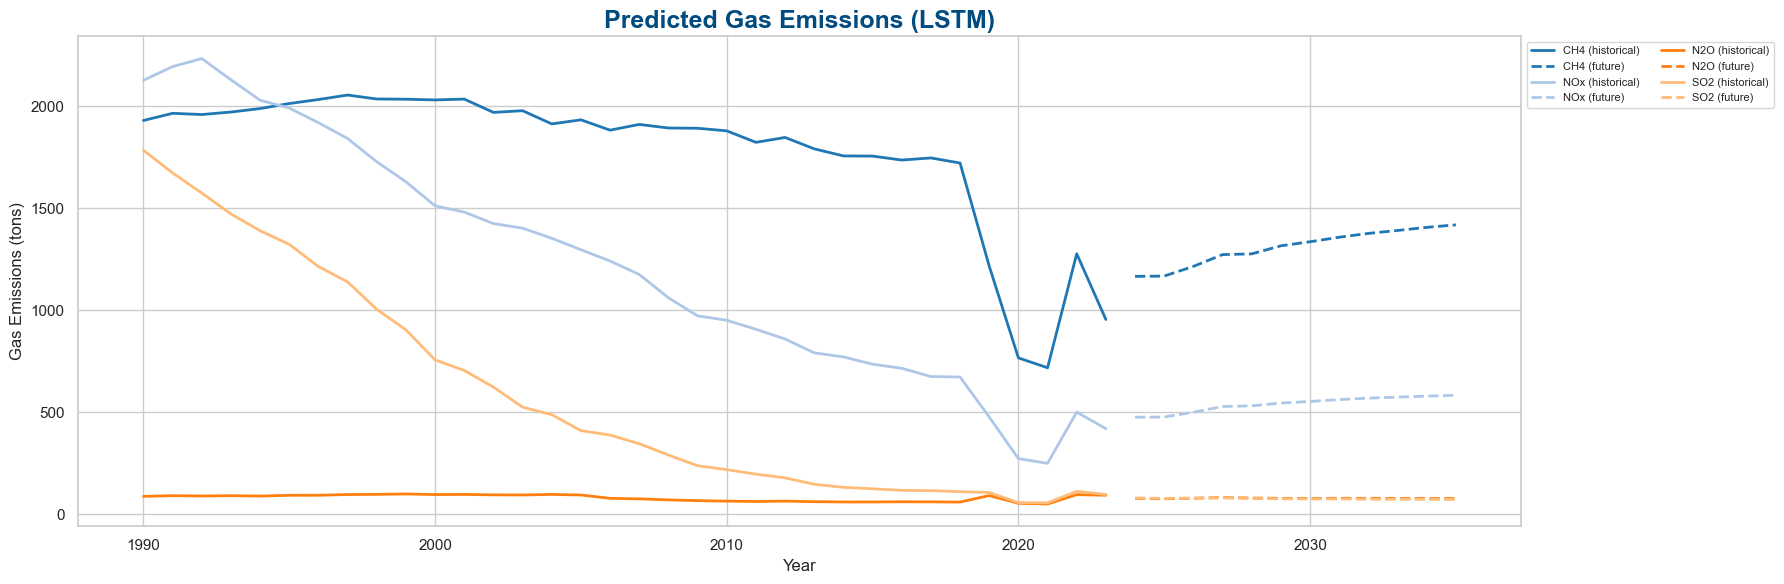

In [346]:
plt.figure(figsize=(18, 6))

gas = df_no_co2['Gas']
palette = plt.cm.tab20.colors
color_map = {
    gas: palette[i % len(palette)]
    for i, gas in enumerate(gas)
}

years_hist = df_no_co2.columns[1:].astype(int).values

#years_hist = years.flatten()

for gas in gases:
    # Dati storici
    hist_values = (df_no_co2[df_no_co2['Gas'] == gas].iloc[:, 1:].values.flatten())

    sns.lineplot(
        x=years_hist,
        y=hist_values,
        color=color_map[gas],
        linewidth=2,
        label=f'{gas} (historical)'
    )

    # Predizioni future
    sns.lineplot(
        x=predictions_lstm['Year'],
        y=predictions_lstm[gas],
        color=color_map[gas],
        linestyle='--',
        linewidth=2,
        label=f'{gas} (future)'
    )

plt.title(
    'Predicted Gas Emissions (LSTM)',
    fontsize=18, fontweight='bold', color='#004b7f'
)
plt.xlabel('Year')
plt.ylabel('Gas Emissions (tons)')

plt.legend(
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()

#### Visualizzazione metriche per confrontare i modelli

In [347]:
print(metrics_df)

   Gas        RMSE        R2
0  CH4  232.797251  0.563570
1  NOx   83.993811  0.979739
2  N2O   12.622977  0.382279
3  SO2  193.092462  0.872266


In [348]:
print(metrics_df_poly)

   Gas        RMSE        R2
0  CH4  153.466176  0.810336
1  NOx   72.989224  0.984700
2  N2O   12.500192  0.394238
3  SO2   33.208451  0.996222


In [349]:
print(metrics_df_lstm)

   Gas        RMSE        R2
0  CH4  243.752334  0.571081
1  NOx  113.126017  0.946250
2  N2O   12.320479  0.466549
3  SO2   26.344230  0.995069


### Emissioni di CO2 in Italia

#### Regressione Lineare

In [350]:
# Preparazione dei dati
years = np.array([int(year) for year in df_co2_it.columns[1:]]).reshape(-1,1)
future_years = np.array(range(2024, 2036)).reshape(-1,1)

In [351]:
# Struttura dati per le predizioni
predictions = pd.DataFrame({'Year' : range(2024, 2036)})

# DataFrame per memorizzare i risulati 
metrics_df = pd.DataFrame(columns=['Gas', 'RMSE', 'R2'])

# Addestramento di un modello di regressione lineare per ogni paese per predire i valori futuri
for gas in df_co2_it['Gas']:
    # Estrazione dati storici per Paese
    data = df_co2_it[df_co2_it['Gas']==gas].iloc[:,1:].values.flatten()
    
    # Addestramento modello
    model = LinearRegression()
    model.fit(years, data)

    y_pred = model.predict(years)

    # Predizione valori futuri
    future_pred = model.predict(future_years)

    # Aggiunta presizioni al DF
    predictions[gas] = future_pred

    # Calcolo metriche
    mse = mean_squared_error(data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(data, y_pred)

    # Salvataggio metriche
    metrics_df.loc[len(metrics_df)]={
        'Gas':gas,
        'RMSE':rmse,
        'R2':r2
    }

    

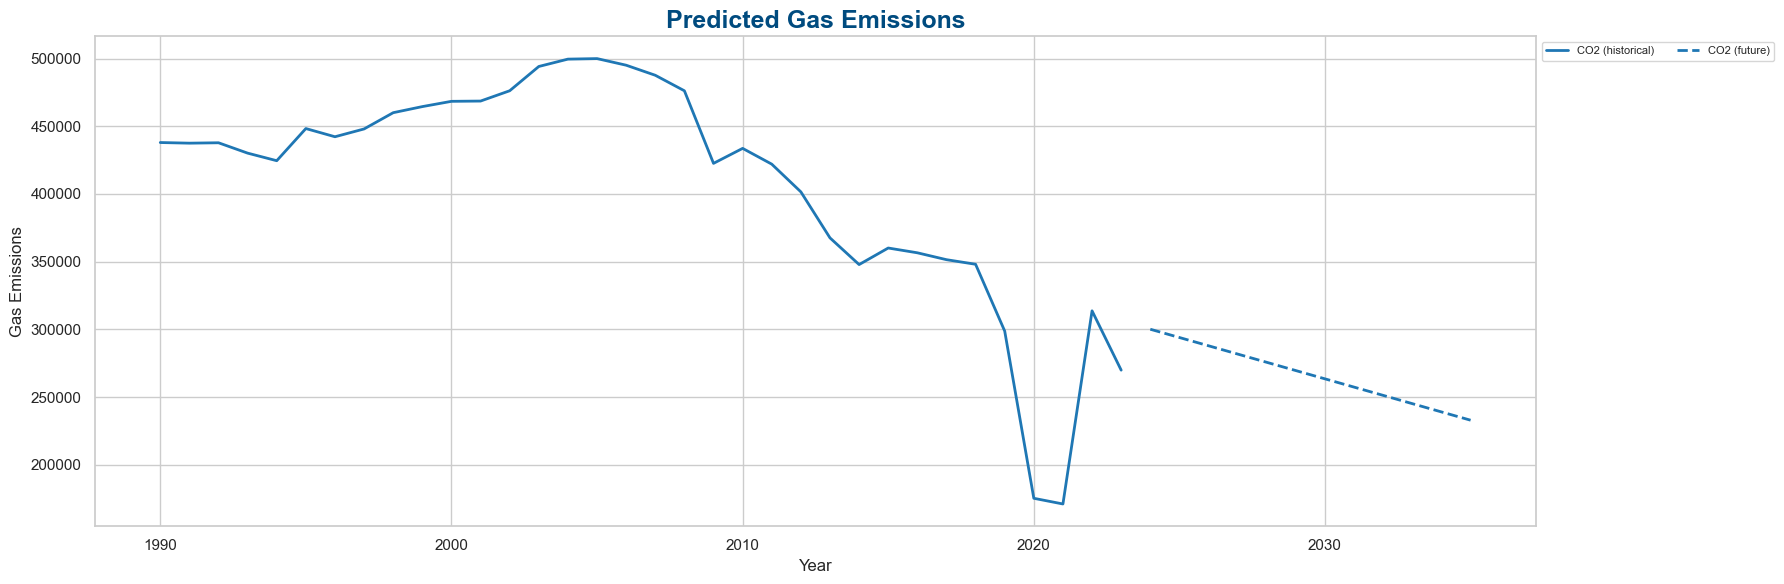

In [352]:
plt.figure(figsize=(18,6))

gases = df_co2_it['Gas']
palette = plt.cm.tab20.colors
color_map = {
    gas: palette[i % len(palette)]
    for i, gas in enumerate(gases)
}

years_hist = years.flatten()

# Linee storiche
for gas in gases:
    hist_values = (
        df_co2_it[df_co2_it['Gas'] == gas]
        .iloc[:, 1:]
        .values
        .flatten()
    )

    sns.lineplot(
        x=years_hist,
        y=hist_values,
        color=color_map[gas],
        linewidth=2,
        label=f"{gas} (historical)"
    )

    sns.lineplot(
        x=predictions['Year'],
        y=predictions[gas],
        color=color_map[gas],
        linestyle='--',
        linewidth=2,
        label=f"{gas} (future)"
    )

plt.title('Predicted Gas Emissions',fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Year')
plt.ylabel('Gas Emissions')

plt.legend(
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()


#### Regressione Lineare Polinomiale

In [353]:
# Struttura dati per le predizioni
predictions_poly = pd.DataFrame({'Year' : range(2024, 2036)})

# Grado del polinomio
degree =  2

# DataFrame per memorizzare le metriche
metrics_df_poly = pd.DataFrame(columns=['Gas', 'RMSE', 'R2'])

# Addestramento di un modello di regressione polinomiale per ogni paese 
for gas in df_co2_it['Gas']:
    # Estrazione dati storici per Paese
    data = df_co2_it[df_co2_it['Gas']==gas].iloc[:,1:].values.flatten()
    
    # Trasformazione anni in formato polinomiale
    poly = PolynomialFeatures(degree=degree)
    years_poly = poly.fit_transform(years)

    # Addestramento modello
    model = LinearRegression()
    model.fit(years_poly, data)

    # Predizione sullo stesso set di dati
    y_pred = model.predict(years_poly)

    # Calcolo metriche
    mse = mean_squared_error(data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(data, y_pred)

    # Salvataggio metriche
    metrics_df_poly.loc[len(metrics_df_poly)]={
        'Gas':gas,
        'RMSE':rmse,
        'R2':r2
    }

    # Predizione valori futuri
    future_years_poly = poly.transform(future_years)
    future_pred = model.predict(future_years_poly)


    # Aggiunta presizioni al DF
    predictions[gas] = future_pred



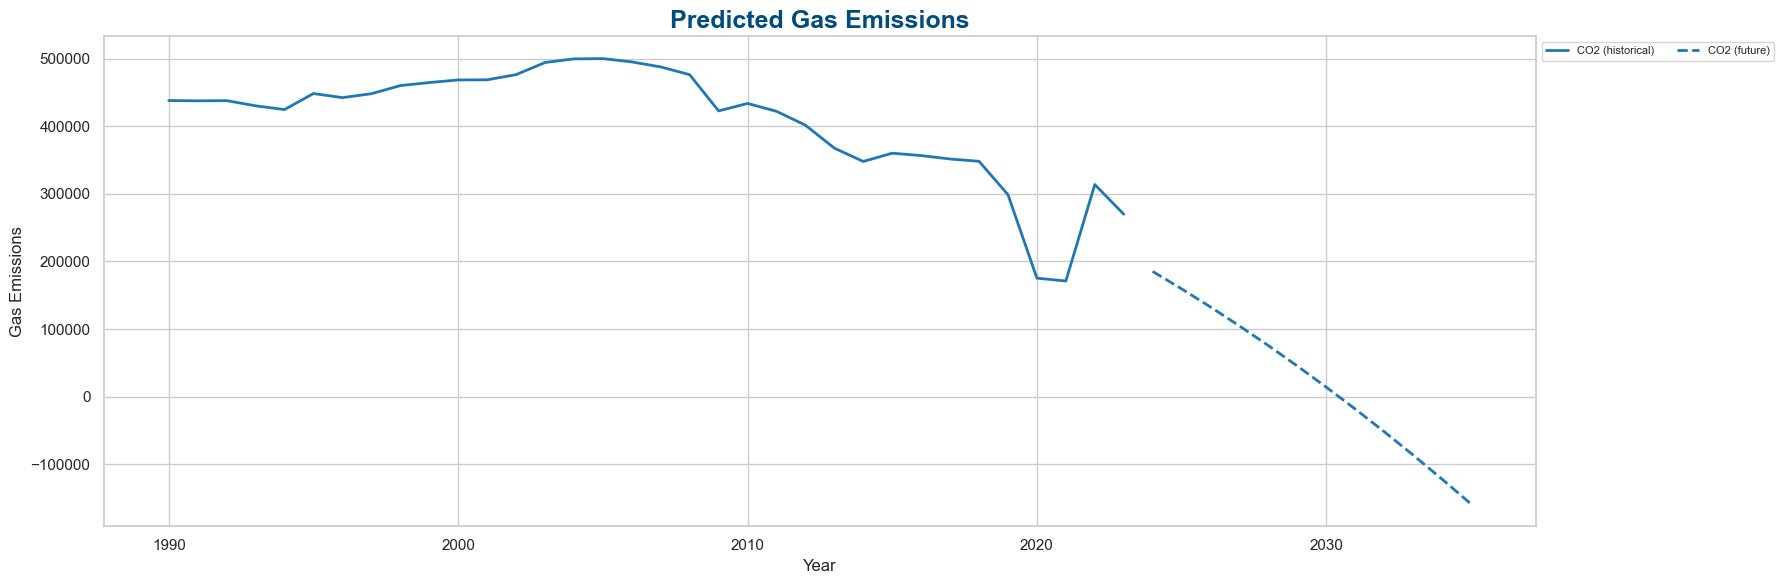

In [354]:
plt.figure(figsize=(18,6))

gases = df_co2_it['Gas']
palette = plt.cm.tab20.colors
color_map = {
    gas: palette[i % len(palette)]
    for i, gas in enumerate(gases)
}

years_hist = years.flatten()

# Linee storiche
for gas in gases:
    hist_values = (
        df_co2_it[df_co2_it['Gas'] == gas]
        .iloc[:, 1:]
        .values
        .flatten()
    )

    sns.lineplot(
        x=years_hist,
        y=hist_values,
        color=color_map[gas],
        linewidth=2,
        label=f"{gas} (historical)"
    )

    sns.lineplot(
        x=predictions['Year'],
        y=predictions[gas],
        color=color_map[gas],
        linestyle='--',
        linewidth=2,
        label=f"{gas} (future)"
    )

plt.title('Predicted Gas Emissions',fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Year')
plt.ylabel('Gas Emissions')

plt.legend(
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()


#### LSTM

In [355]:
# Parametri
sequence_length = 5 # lunghezza finestra temporale
future_steps = 12 # numero di anni futuri da predire

# Struttura dati per le predizioni
predictions_lstm = pd.DataFrame({'Year' : range(2024, 2024+future_steps)})

# DataFrame per memorizzare le metriche
metrics_df_lstm = pd.DataFrame(columns=['Gas', 'RMSE', 'R2'])

# Addestramento di un modello LSTM per ogni paese 
for gas in df_co2_it['Gas']:
    # Estrazione dati storici per Paese
    gas_data = df_co2_it[df_co2_it['Gas']==gas].iloc[:,1:].values.flatten()
    years = df_co2_it.columns[1:].astype(int)
    
    # Normalizzazione dei dati
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(gas_data.reshape(-1,1)).flatten()

    # Sequenze temporali
    X,y = prepare_lstm_data(scaled_data, sequence_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Creazione modello
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length,1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Addestramento modello
    model.fit(X, y, epochs=50, batch_size=16, verbose=0)

    # Predizione valori futuri
    future_input = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
    future_predictions = []

    for _ in range(future_steps):
        pred = model.predict(future_input, verbose=0)[0, 0]
        future_predictions.append(pred)
        future_input = np.append(future_input.flatten()[1:], pred).reshape(1, sequence_length, 1)
    
    # Inversione della scalatura
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1)).flatten()

    # Aggiunta presizioni al DF
    predictions_lstm[gas] = future_predictions

    # Calcolo metriche di valutazione
    y_train_pred_scaled = model.predict(X, verbose=0).flatten()
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1,1)).flatten()
    y_train = scaler.inverse_transform(y.reshape(-1,1)).flatten()

    mse = np.mean((y_train-y_train_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - (np.sum((y_train-y_train_pred) ** 2)) / np.sum((y_train-np.mean(y_train)) ** 2)

    # Salvataggio metriche
    metrics_df_lstm.loc[len(metrics_df_lstm)]={
        'Gas':gas,
        'RMSE':rmse,
        'R2':r2
    }

print(predictions_lstm.head())



c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   Year           CO2
0  2024  291840.00000
1  2025  291196.21875
2  2026  304751.84375
3  2027  320925.81250
4  2028  321412.84375


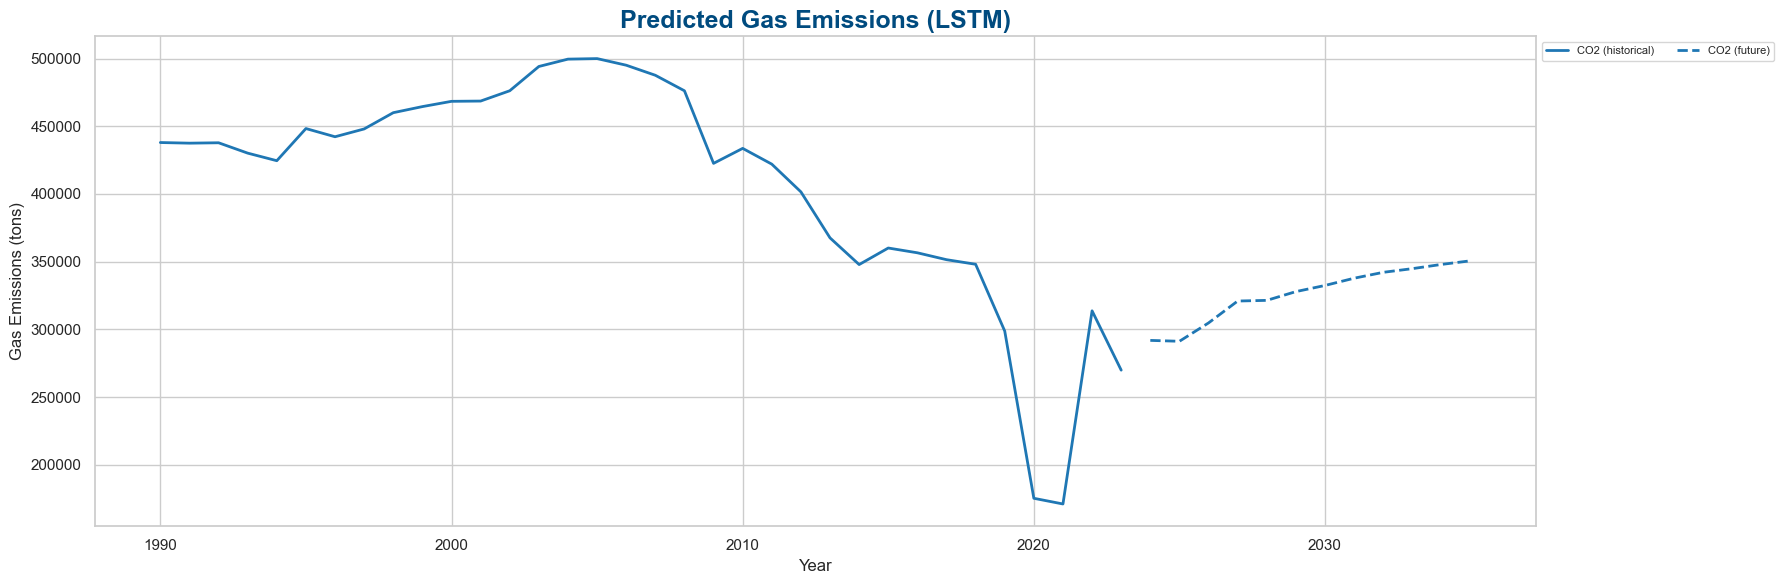

In [356]:
plt.figure(figsize=(18, 6))

gas = df_co2_it['Gas']
palette = plt.cm.tab20.colors
color_map = {
    gas: palette[i % len(palette)]
    for i, gas in enumerate(gas)
}

years_hist = df_co2_it.columns[1:].astype(int).values

#years_hist = years.flatten()

for gas in gases:
    # Dati storici
    hist_values = (df_co2_it[df_co2_it['Gas'] == gas].iloc[:, 1:].values.flatten())

    sns.lineplot(
        x=years_hist,
        y=hist_values,
        color=color_map[gas],
        linewidth=2,
        label=f'{gas} (historical)'
    )

    # Predizioni future
    sns.lineplot(
        x=predictions_lstm['Year'],
        y=predictions_lstm[gas],
        color=color_map[gas],
        linestyle='--',
        linewidth=2,
        label=f'{gas} (future)'
    )

plt.title(
    'Predicted Gas Emissions (LSTM)',
    fontsize=18, fontweight='bold', color='#004b7f'
)
plt.xlabel('Year')
plt.ylabel('Gas Emissions (tons)')

plt.legend(
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()

#### Visualizzazione metriche per confrontare i modelli

In [357]:
print(metrics_df)

   Gas          RMSE        R2
0  CO2  58113.377776  0.515387


In [358]:
print(metrics_df_poly)

   Gas          RMSE        R2
0  CO2  34127.690881  0.832869


In [359]:
print(metrics_df_lstm)

   Gas          RMSE       R2
0  CO2  56162.844749  0.60679


### Utilizzo delle Energie Rinnovabili in Italia



In [360]:
df_italy_renew

2005   2006   2007  2008   2009  2010   2011   2012   2013   2014  \
100  17.04  16.87  15.66  18.4  22.76  23.7  24.74  27.56  33.67  37.28   

      2015   2016   2017  2018  2019   2020  2021   2022   2023  
100  32.35  31.43  29.67  28.3  28.2  29.05  28.9  30.26  28.71

#### Regressione Lineare

In [361]:
# Preparazione dei dati
years = np.array([int(year) for year in df_italy_renew.columns[1:]]).reshape(-1,1)
future_years = np.array(range(2024, 2036)).reshape(-1,1)

In [362]:
# Struttura dati per le predizioni
predictions = pd.DataFrame({'Year' : range(2024, 2036)})

# DataFrame per memorizzare i risulati 
metrics_df = pd.DataFrame(columns=['RMSE', 'R2'])

# Addestramento di un modello di regressione lineare per ogni paese per predire i valori futuri

# Estrazione dati storici per Paese
data = df_italy_renew.iloc[0,1:].values.flatten()

# Addestramento modello
model = LinearRegression()
model.fit(years, data)

y_pred = model.predict(years)

# Predizione valori futuri
future_pred = model.predict(future_years)

# Aggiunta presizioni al DF
predictions['Renewable Energy'] = future_pred

# Calcolo metriche
mse = mean_squared_error(data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(data, y_pred)

# Salvataggio metriche
metrics_df.loc[len(metrics_df)]={
    'RMSE':rmse,
    'R2':r2
}

    

In [363]:
print(metrics_df)

       RMSE       R2
0  4.239367  0.43183


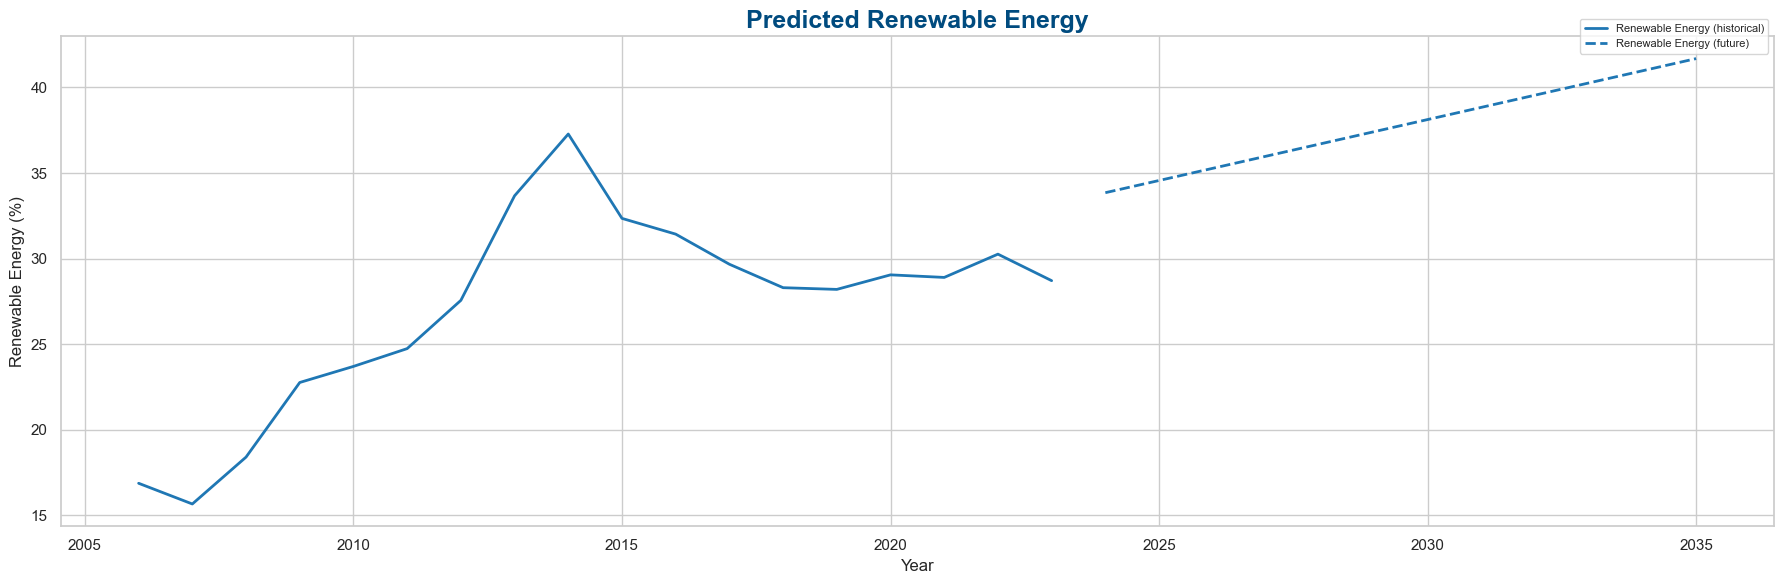

In [364]:
plt.figure(figsize=(18,6))

palette = plt.cm.tab20.colors
color_map = {'Renewable Energy':palette[0]}

years_hist = years.flatten()

# Linee storiche
hist_values = (df_italy_renew.iloc[0, 1:].values.flatten())

sns.lineplot(
    x=years_hist,
    y=hist_values,
    color=color_map['Renewable Energy'],
    linewidth=2,
    label=f"Renewable Energy (historical)"
)

sns.lineplot(
    x=predictions['Year'],
    y=predictions['Renewable Energy'],
    color=color_map['Renewable Energy'],
    linestyle='--',
    linewidth=2,
    label=f"Renewable Energy (future)"
)

plt.title('Predicted Renewable Energy',fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Year')
plt.ylabel('Renewable Energy (%)')

plt.legend(
    ncol=1,
    loc='right',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()


#### Regressione Lineare Polinomiale

In [365]:
# Struttura dati per le predizioni
predictions_poly = pd.DataFrame({'Year' : range(2024, 2036)})

# Grado del polinomio
degree =  2

# DataFrame per memorizzare le metriche
metrics_df_poly = pd.DataFrame(columns=['RMSE', 'R2'])

# Addestramento di un modello di regressione polinomiale per ogni paese 
# Estrazione dati storici per Paese
data = df_italy_renew.iloc[0,1:].values.flatten()
    
# Trasformazione anni in formato polinomiale
poly = PolynomialFeatures(degree=degree)
years_poly = poly.fit_transform(years)

# Addestramento modello
model = LinearRegression()
model.fit(years_poly, data)

# Predizione sullo stesso set di dati
y_pred = model.predict(years_poly)

# Calcolo metriche
mse = mean_squared_error(data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(data, y_pred)

# Salvataggio metriche
metrics_df_poly.loc[len(metrics_df_poly)]={
    'RMSE':rmse,
    'R2':r2
}

# Predizione valori futuri
future_years_poly = poly.transform(future_years)
future_pred = model.predict(future_years_poly)

# Aggiunta presizioni al DF
predictions['Renewable Energy'] = future_pred



In [366]:
print(metrics_df_poly)

       RMSE        R2
0  2.558501  0.793059


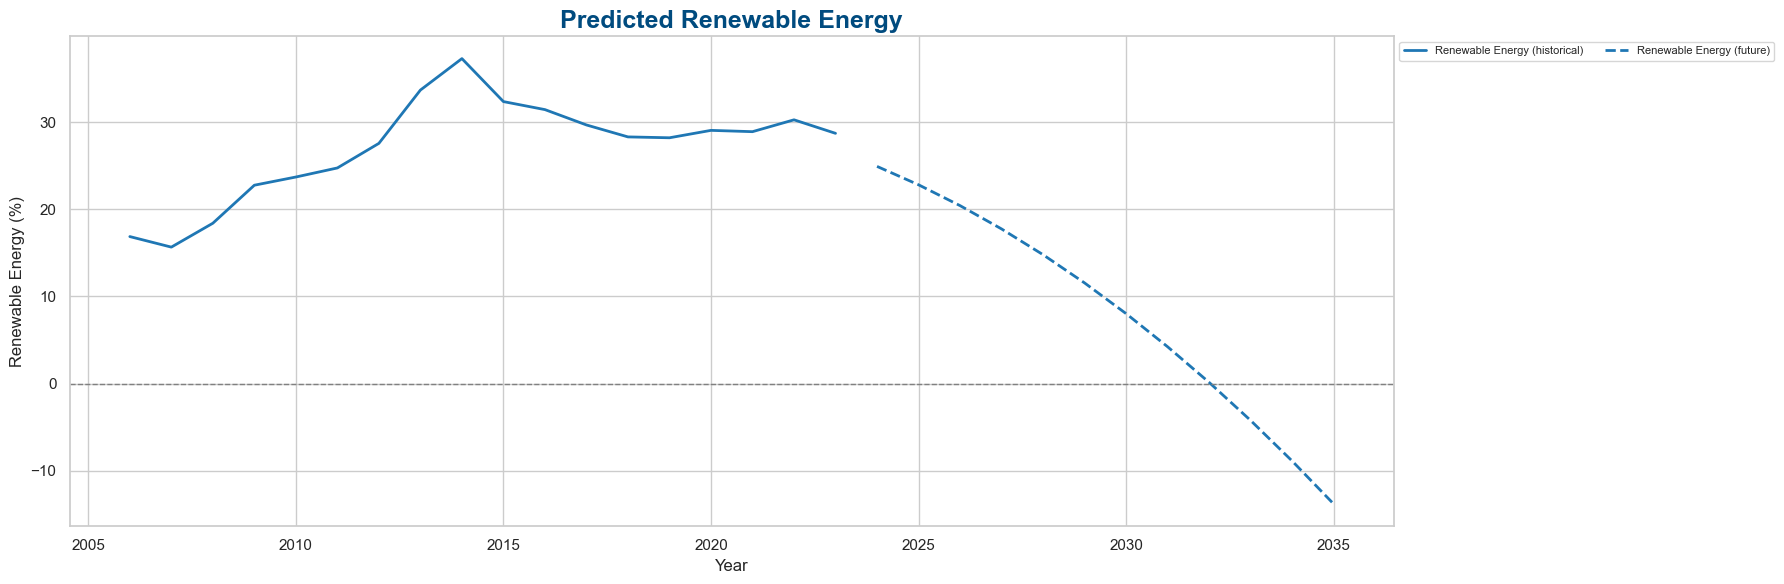

In [367]:
plt.figure(figsize=(18,6))

palette = plt.cm.tab20.colors
color_map = {'Renewable Energy':palette[0]}

years_hist = years.flatten()

# Linee storiche

hist_values = (
    df_italy_renew
    .iloc[0, 1:]
    .values
    .flatten()
)

sns.lineplot(
    x=years_hist,
    y=hist_values,
    color=color_map['Renewable Energy'],
    linewidth=2,
    label=f"Renewable Energy (historical)"
)

sns.lineplot(
    x=predictions['Year'],
    y=predictions['Renewable Energy'],
    color=color_map['Renewable Energy'],
    linestyle='--',
    linewidth=2,
    label=f"Renewable Energy (future)"
)

plt.title('Predicted Renewable Energy',fontsize=18, fontweight='bold', color='#004b7f')
plt.xlabel('Year')
plt.ylabel('Renewable Energy (%)')

plt.legend(
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8
)
plt.axhline(0, color='grey', linestyle='--', linewidth=1) # Linea dello zero
plt.tight_layout()
plt.show()


#### LSTM

In [368]:
# Parametri
sequence_length = 5 # lunghezza finestra temporale
future_steps = 12 # numero di anni futuri da predire

# Struttura dati per le predizioni
predictions_lstm = pd.DataFrame({'Year' : range(2024, 2024+future_steps)})

# DataFrame per memorizzare le metriche
metrics_df_lstm = pd.DataFrame(columns=['RMSE', 'R2'])

# Addestramento di un modello LSTM per ogni paese 
# Estrazione dati storici per Paese
data = df_italy_renew.iloc[0,1:].values.flatten()
years = df_italy_renew.columns[1:].astype(int)

# Normalizzazione dei dati
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data.reshape(-1,1)).flatten()

# Sequenze temporali
X,y = prepare_lstm_data(scaled_data, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Creazione modello
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Addestramento modello
model.fit(X, y, epochs=50, batch_size=16, verbose=0)

# Predizione valori futuri
future_input = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input, verbose=0)[0, 0]
    future_predictions.append(pred)
    future_input = np.append(future_input.flatten()[1:], pred).reshape(1, sequence_length, 1)

# Inversione della scalatura
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1)).flatten()

# Aggiunta presizioni al DF
predictions_lstm['Renewable Energy'] = future_predictions

# Calcolo metriche di valutazione
y_train_pred_scaled = model.predict(X, verbose=0).flatten()
y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1,1)).flatten()
y_train = scaler.inverse_transform(y.reshape(-1,1)).flatten()

mse = np.mean((y_train-y_train_pred) ** 2)
rmse = np.sqrt(mse)
r2 = 1 - (np.sum((y_train-y_train_pred) ** 2)) / np.sum((y_train-np.mean(y_train)) ** 2)

# Salvataggio metriche
metrics_df_lstm.loc[len(metrics_df_lstm)]={
    'RMSE':rmse,
    'R2':r2
}

print(predictions_lstm.head())



c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   Year  Renewable Energy
0  2024         30.738300
1  2025         31.089201
2  2026         31.337637
3  2027         31.685747
4  2028         31.843529


In [369]:
print(metrics_df_lstm)

      RMSE        R2
0  3.96866 -0.739062


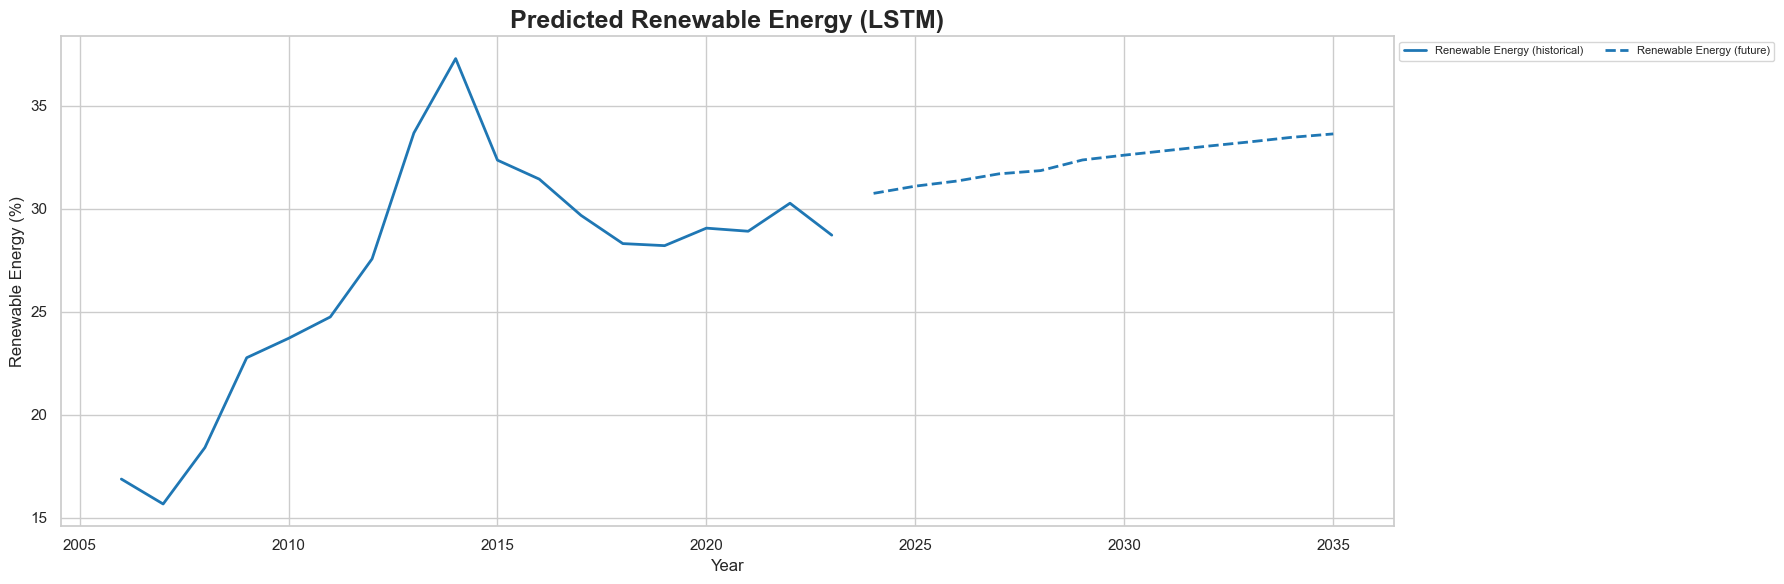

In [370]:
plt.figure(figsize=(18, 6))

palette = plt.cm.tab20.colors
color_map = {'Renewable Energy':palette[0]}

#years_hist = df_co2_it.columns[1:].astype(int).values

years_hist = years

# Dati storici
hist_values = df_italy_renew.iloc[0, 1:].values.flatten()

sns.lineplot(
    x=years_hist,
    y=hist_values,
    color=color_map['Renewable Energy'],
    linewidth=2,
    label=f'Renewable Energy (historical)'
)

# Predizioni future
sns.lineplot(
    x=predictions_lstm['Year'],
    y=predictions_lstm['Renewable Energy'],
    color=color_map['Renewable Energy'],
    linestyle='--',
    linewidth=2,
    label=f'Renewable Energy (future)'
)

plt.title(
    'Predicted Renewable Energy (LSTM)',
    fontsize=18,
    fontweight='bold'
)
plt.xlabel('Year')
plt.ylabel('Renewable Energy (%)')

plt.legend(
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()